In [54]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [98]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [187]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [188]:
# Problem 2.1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    a = np.sum(np.square(X), axis=0) # a[k] denotes a_k as in defn
    n, m = X.shape
    
    not_stop = True
    iter_count = 0
    
    w, w0 = Initialw(X, y)
    prev_w = np.copy(w)
    prev_w0 = w0
    
    iterations = []
    F_w_w0 = []
    F_w_w0.append(0.5*np.sum(np.square(y - (np.dot(X, w)+w0))) + lmda*np.sum(abs(w)))
    for i in range(max_iter):
        for k in range(m+1):
            w_copy = np.copy(w)
            
            if k == 0:
                r_k = y - np.dot(X, w_copy)
                c_k = np.dot(r_k, np.ones(n))
                w0 = c_k/(n)               
            else:
                w_copy[k-1] = 0
                r_k = y - (np.dot(X, w_copy)+w0)
                c_k =  np.dot(r_k, X[:,k-1])

                if c_k < -lmda:
                    w[k-1] = (c_k + lmda)/a[k-1]
                elif c_k > lmda:
                    w[k-1] = (c_k - lmda)/a[k-1]
                else:
                    w[k-1] = 0
        F_w = 0.5*np.sum(np.square(y - (np.dot(X, w)+w0))) + lmda*np.sum(abs(w))
        F_w_w0.append(F_w)
        
        if max(np.max(np.abs(w - prev_w)), np.abs(w0 - prev_w0)) <= epsilon:
            break;        

        prev_w = np.copy(w)
        prev_w0 = w0
        
    if draw_curve:
        fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
        plt.plot(F_w_w0)
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('loss', fontsize=14)
        plt.title('Loss vs iteration ($\lambda =$' + str(lmda) + ')', fontsize=14)
        plt.show()

    return (w,w0)

In [189]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

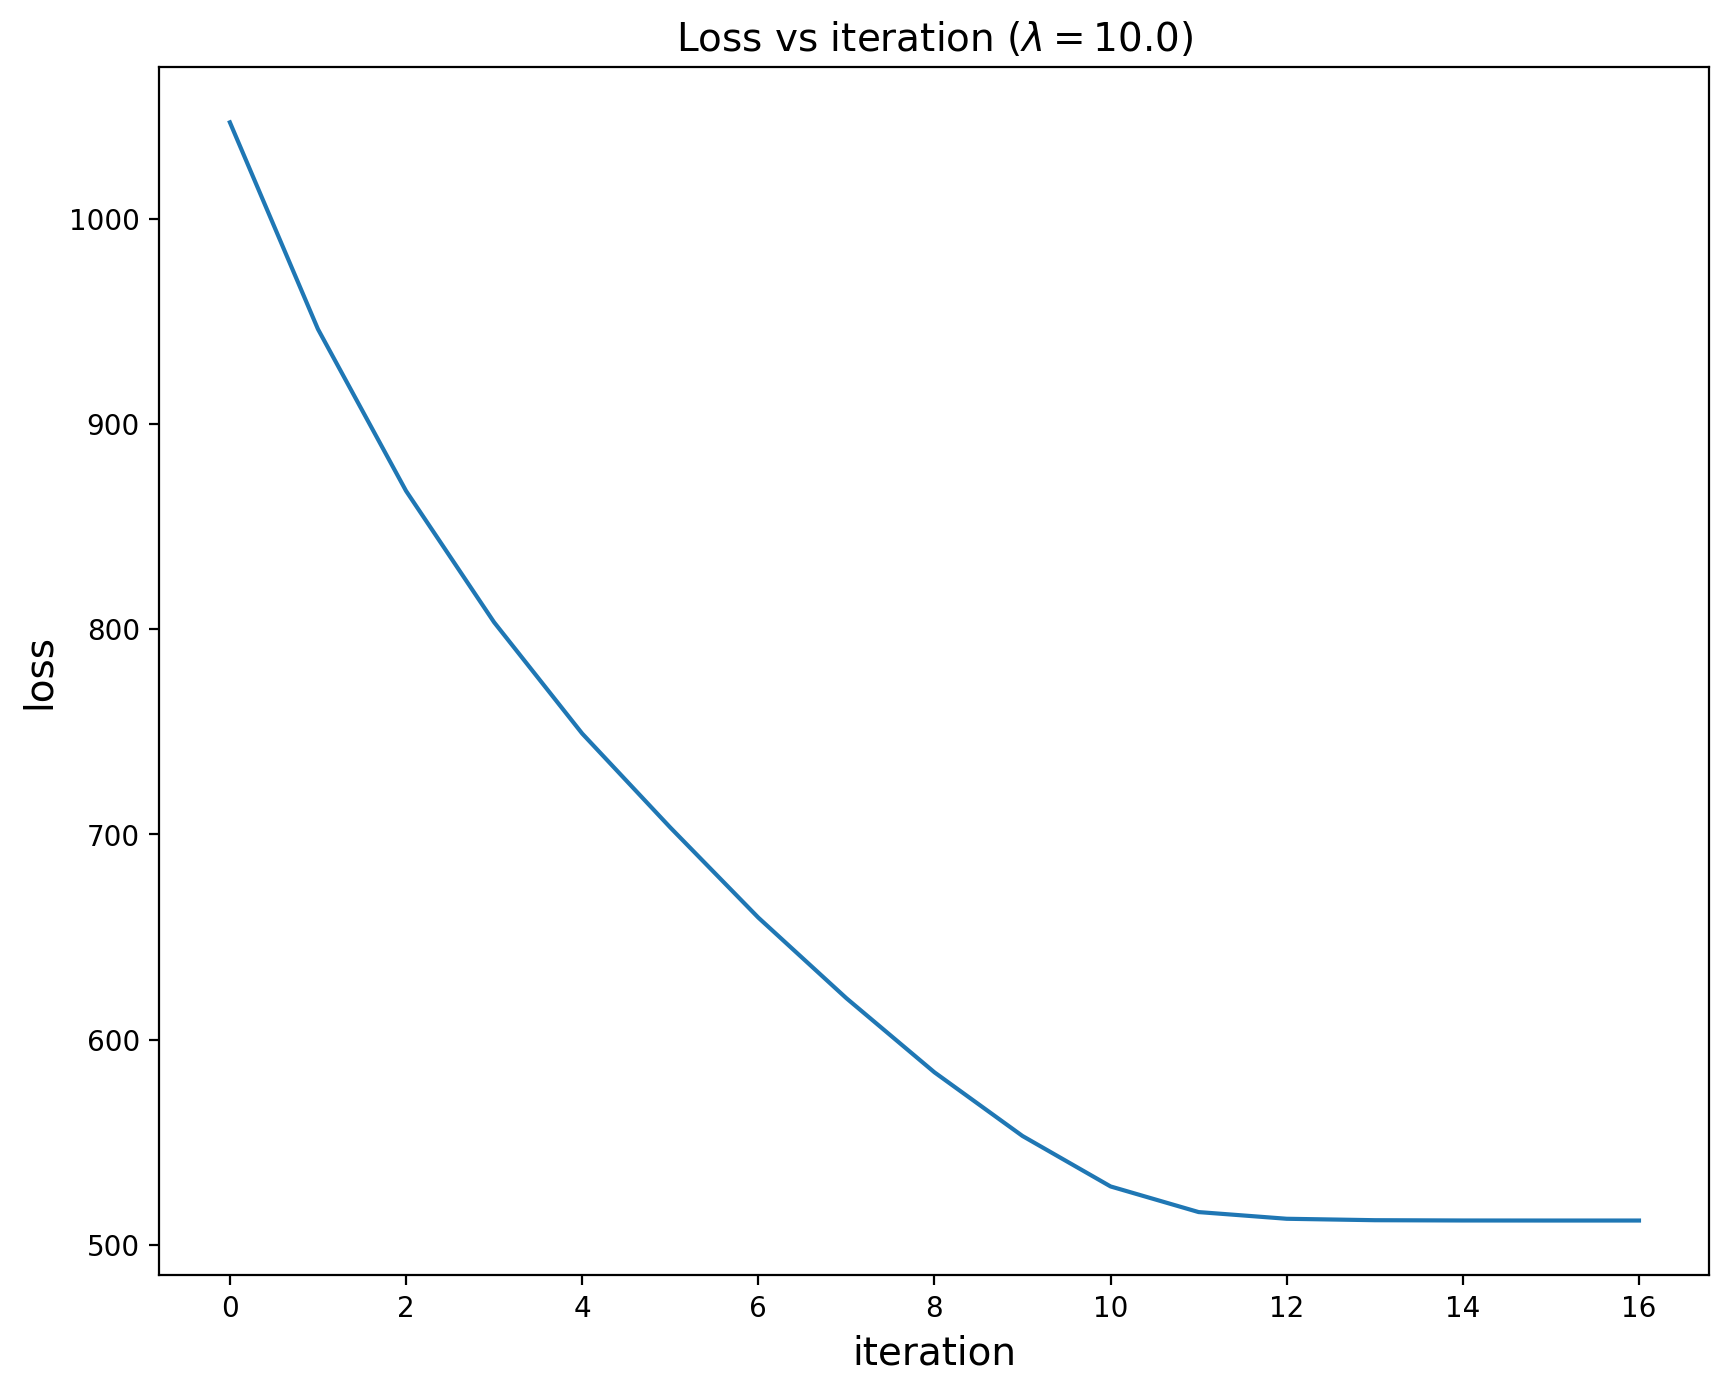

[ 9.79800273e+00 -9.68563056e+00 -9.69063071e+00  9.82989917e+00
  9.94349830e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18879243e-02
  1.52358387e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40473375e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609939e-02  0.00000000e+00
 -7.13625305e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777959e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [190]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
# print non-zero w_lasso indices
# print (w_lasso.nonzero()[0])
non_zero_entries = w_lasso.nonzero()[0]
for idx in non_zero_entries:
    print("%d : %.6f"%(idx, w_lasso[idx]))

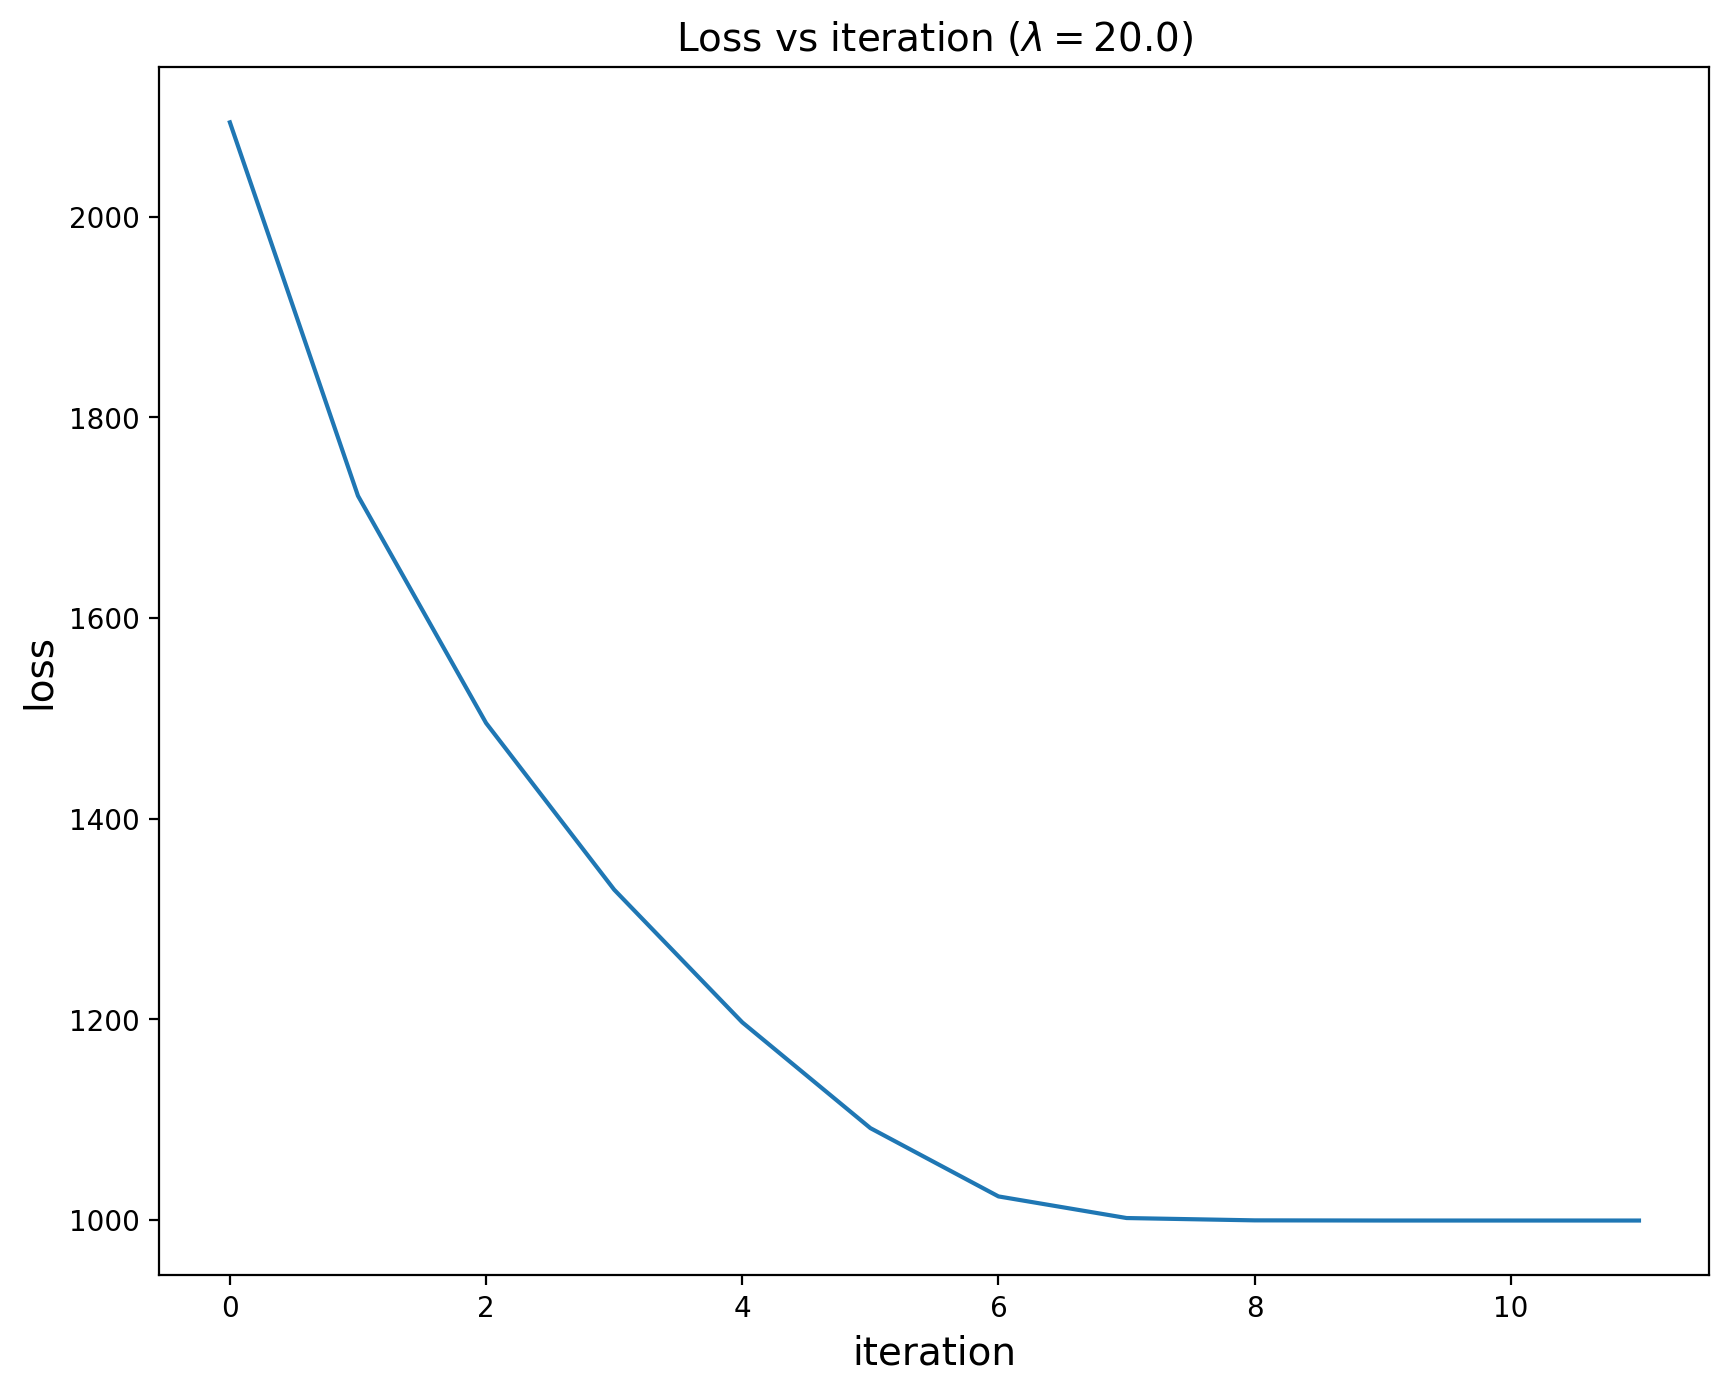

[ 9.61499604 -9.52933669 -9.53904424  9.58129263  9.73744372  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.1557888   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
0 : 9.614996
1 : -9.529337
2 : -9.539044
3 : 9.581293
4 : 9.737444
52 : 0.155789


In [191]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
# changed lambda to 20
w_lasso_mod, w0_lasso_mod = lasso(X, y, lmda = 20.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso_mod)
non_zero_entries = w_lasso_mod.nonzero()[0]
for idx in non_zero_entries:
    print("%d : %.6f"%(idx, w_lasso_mod[idx]))

In [192]:
# Problem 2.2
# TODO: evaluation function of lasso model

def root_mean_square_error(pred, y):
    #TODO
    n = y.shape[0]
    rmse = np.sqrt(np.sum(np.square(y - pred))/n)
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    true_nonzero_indices = w_true.nonzero()[0]
    opt_nonzero_indices = w.nonzero()[0]
    
    sparsity_w = len(w.nonzero()[0])
    numerator = len(set(true_nonzero_indices).intersection(set(opt_nonzero_indices)))
    
    if len(w.nonzero()[0]) != 0:
        precision_w = numerator / len(w.nonzero()[0])
    else:
        precision_w = 0
    try:
        recall_w = numerator /len(w_true.nonzero()[0])
    except:
        recall_w = 0
    
    pred = X.dot(w)+w0
    rmse = root_mean_square_error(pred, y)
    
    return (rmse, sparsity_w, precision_w, recall_w)

In [193]:
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print ("RMSE: %5f \n Sparsity: %d \n Precision: %.3f \n Recall: %.3f"%(Emetric[0], Emetric[1], Emetric[2], Emetric[3]))

RMSE: 0.826463 
 Sparsity: 13 
 Precision: 0.385 
 Recall: 1.000


In [194]:
# using modified lambda of 20.0
Emetric = Evaluate(X, y, w_lasso_mod, w0_lasso_mod, w_true, w0_true)
print ("RMSE: %5f \n Sparsity: %d \n Precision: %.3f \n Recall: %.3f"%(Emetric[0], Emetric[1], Emetric[2], Emetric[3]))

RMSE: 1.207899 
 Sparsity: 6 
 Precision: 0.833 
 Recall: 1.000


In [195]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    lambda_max = np.max(np.abs(X.T.dot(y - np.mean(y))))
    print ("Lambda max %.5f"%lambda_max)
    lambda_min = 0
    Lmda = np.linspace(lambda_min, lambda_max, 50)
    print ("Set of Lambdas %s"%Lmda)
    num_lmda = len(Lmda)
    n, m = X.shape
    
    W = np.zeros((num_lmda, m))
    W0 = np.zeros(num_lmda)
    for (i,lmda) in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(X, y, lmda, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        W[i, :] = w_lasso
        W0[i] = w0_lasso
        
    return (W, W0, Lmda)

In [196]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    num_lmda = len(Lmda)
    RMSE, Sparsity, Precision, Recall = [], [], [], []
    
    for i in range(num_lmda):        
        rmse, sparsity, precision, recall = Evaluate(X, y, W[i,:], W0[i], w_true, w0_true)
        RMSE.append(rmse)
        Sparsity.append(sparsity)
        Precision.append(precision)
        Recall.append(recall)
    
    return (RMSE, Sparsity, Precision, Recall)

In [199]:
from matplotlib.lines import Line2D

# defined another method that aggregates all the results (from LassoPath and EvaluatePath) and does all the plotting.
def Aggregate(X, y, w_true, w0_true,sigma=1.0, print_pr=False):
    W, W0, Lmda = LassoPath(X, y)
    RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
    print ("Sparsity: %s"%Sparsity)
    non_neg_indices = list(w_true.nonzero()[0])
    n,m = X.shape
    
    if print_pr:
        for i, lmda in enumerate(Lmda):
            print ("For lambda %.5f, precision = %.2f, recall = %.2f"%(lmda, Precision[i], Recall[i]))

    fig, ax = plt.subplots(figsize=(30, 20))
    
    for i in range(m):
        if i in non_neg_indices:
            plt.plot(Lmda, W[:,i], c='red', label=str(i+1), marker='o')
        else:
            plt.plot(Lmda, W[:,i], c='blue', label=str(i+1), marker='o')
    plt.plot(Lmda, W0, c='green', label='0', marker='o')
    colors = ['red', 'blue', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = [r'imp $\theta$', r'remaining $\theta$', r'$\theta_{0}$']
    plt.legend(lines, labels, fontsize=16)
    plt.xlabel('lambda', fontsize=20)
    plt.ylabel('Value of theta', fontsize=20)
    plt.title(r'Variation of $\theta$ wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + '$,  \sigma = $' + str(sigma) +')', fontsize=24)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    plt.plot(Lmda, Precision, c='red', label='precision', marker='o')
    plt.plot(Lmda, Recall, c='green', label='recall', marker='o')
    plt.legend(loc='best', fontsize=10)
    plt.xlabel('lambda', fontsize=12)
    plt.ylabel('Precision/Recall value', fontsize=12)
    plt.title(r'Variation of Precision and Recall wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=14)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.plot(Lmda, RMSE, c='red', label='RMSE', marker='o')
    plt.xlabel('lambda', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title(r'Variation of RMSE wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=14)
    plt.show()    
    
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.plot(Lmda, Sparsity, c='red', label='Sparsity', marker='o')
    plt.xlabel('lambda', fontsize=12)
    plt.ylabel('Sparsity', fontsize=12)
    plt.title(r'Variation of Sparsity wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=14)
    plt.show()        

Lambda max 528.25690
Set of Lambdas [  0.          10.78075311  21.56150621  32.34225932  43.12301243
  53.90376553  64.68451864  75.46527175  86.24602486  97.02677796
 107.80753107 118.58828418 129.36903728 140.14979039 150.9305435
 161.7112966  172.49204971 183.27280282 194.05355593 204.83430903
 215.61506214 226.39581525 237.17656835 247.95732146 258.73807457
 269.51882767 280.29958078 291.08033389 301.861087   312.6418401
 323.42259321 334.20334632 344.98409942 355.76485253 366.54560564
 377.32635874 388.10711185 398.88786496 409.66861807 420.44937117
 431.23012428 442.01087739 452.79163049 463.5723836  474.35313671
 485.13388981 495.91464292 506.69539603 517.47614914 528.25690224]
Sparsity: [75, 11, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 0]


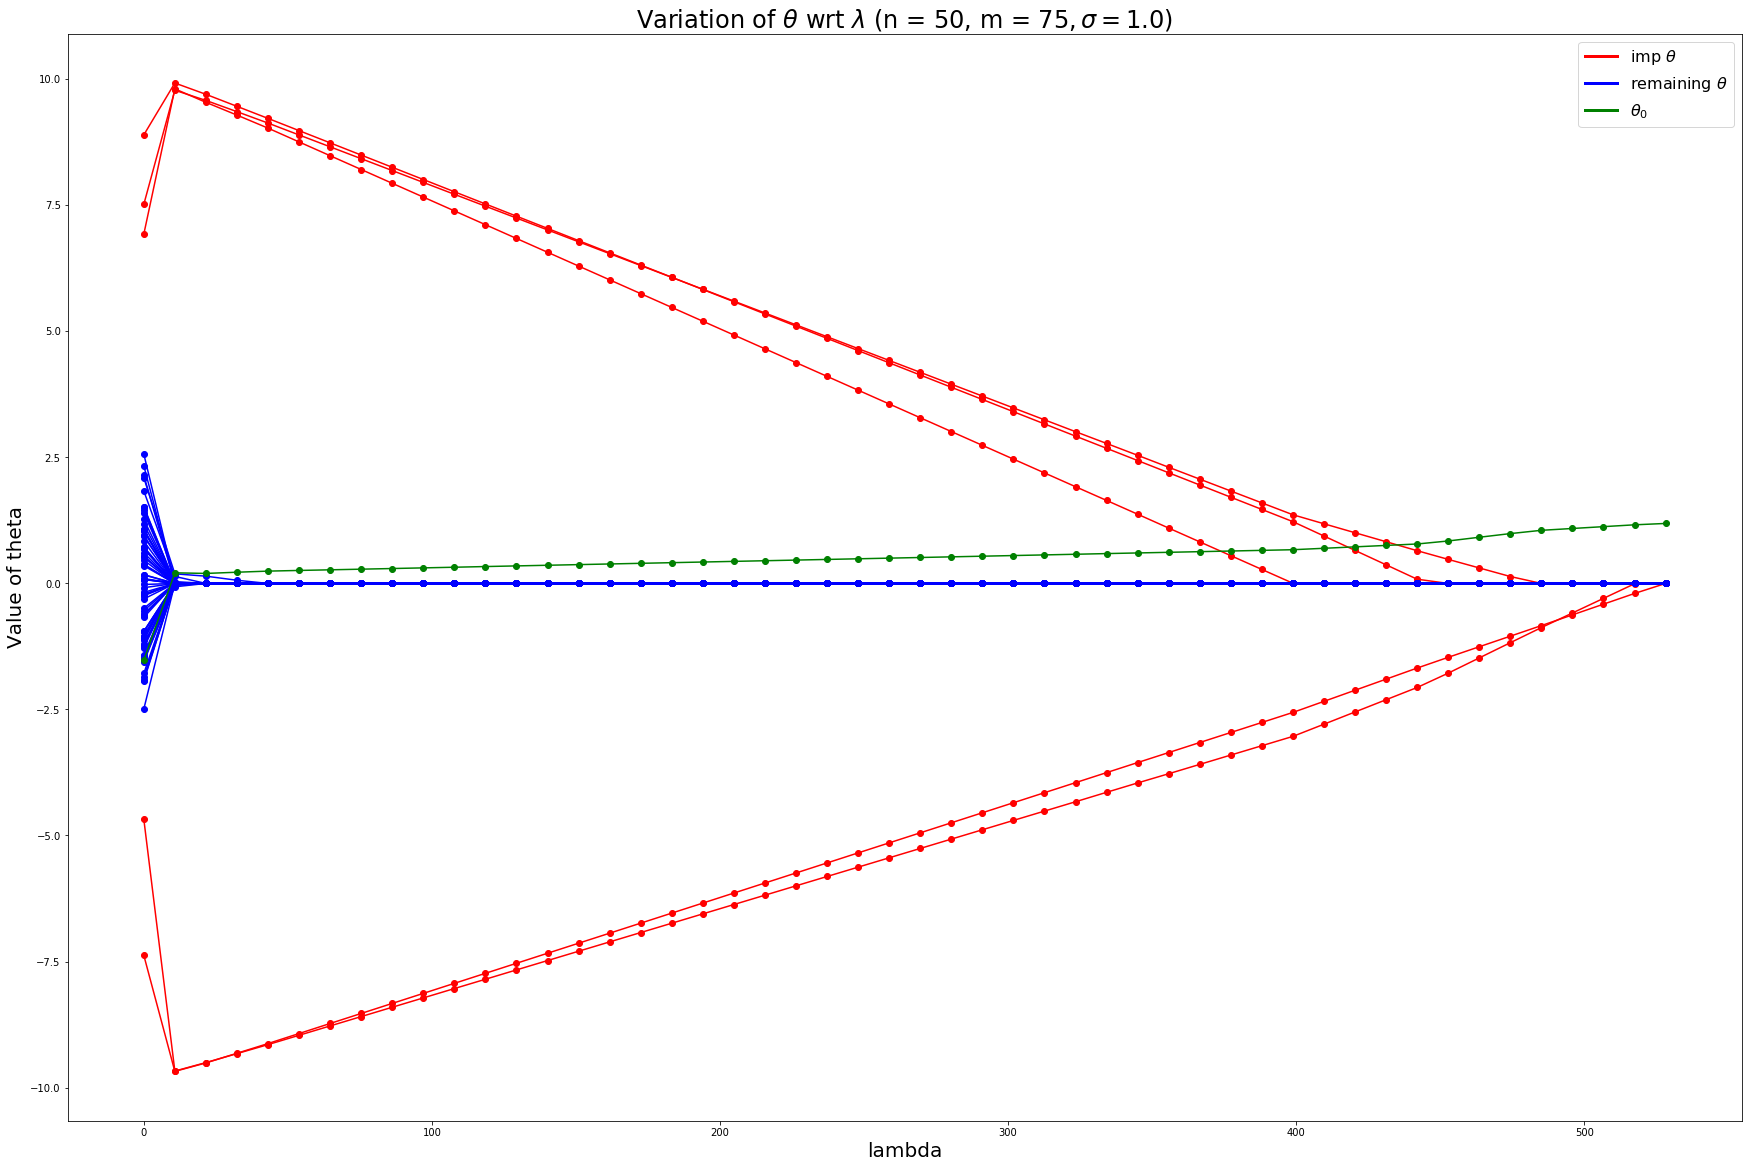

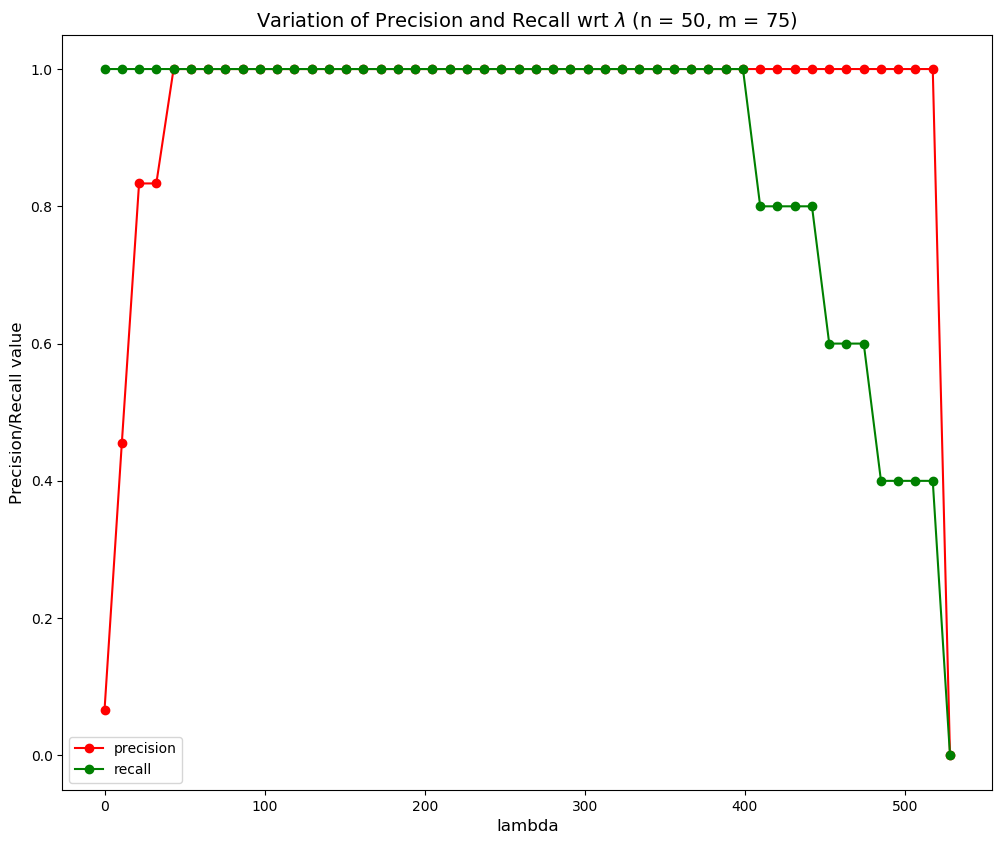

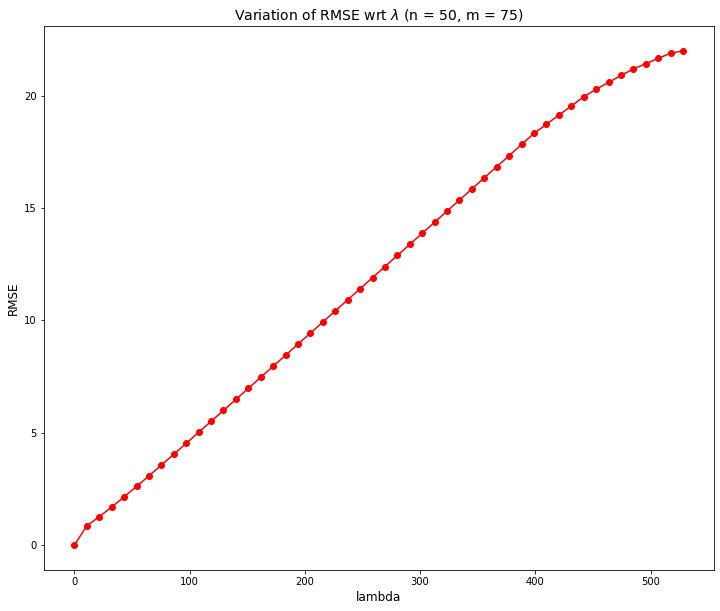

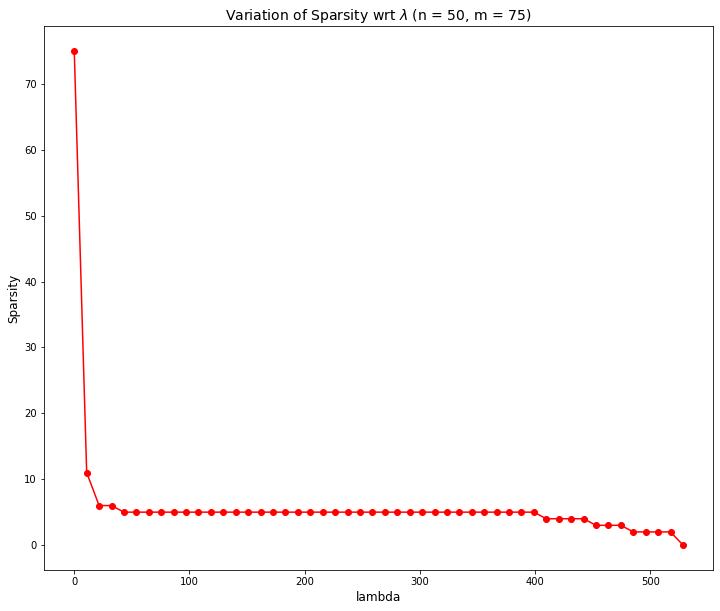

In [200]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
Aggregate(X, y, w_true, w0_true, sigma=1.0)

Lambda max 516.31162
Set of Lambdas [  0.          10.53697182  21.07394364  31.61091546  42.14788728
  52.6848591   63.22183092  73.75880274  84.29577456  94.83274638
 105.3697182  115.90669002 126.44366184 136.98063366 147.51760548
 158.0545773  168.59154912 179.12852094 189.66549276 200.20246458
 210.7394364  221.27640822 231.81338004 242.35035186 252.88732367
 263.42429549 273.96126731 284.49823913 295.03521095 305.57218277
 316.10915459 326.64612641 337.18309823 347.72007005 358.25704187
 368.79401369 379.33098551 389.86795733 400.40492915 410.94190097
 421.47887279 432.01584461 442.55281643 453.08978825 463.62676007
 474.16373189 484.70070371 495.23767553 505.77464735 516.31161917]
Sparsity: [75, 40, 36, 28, 21, 20, 18, 18, 14, 13, 12, 10, 10, 10, 8, 8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 2, 0]


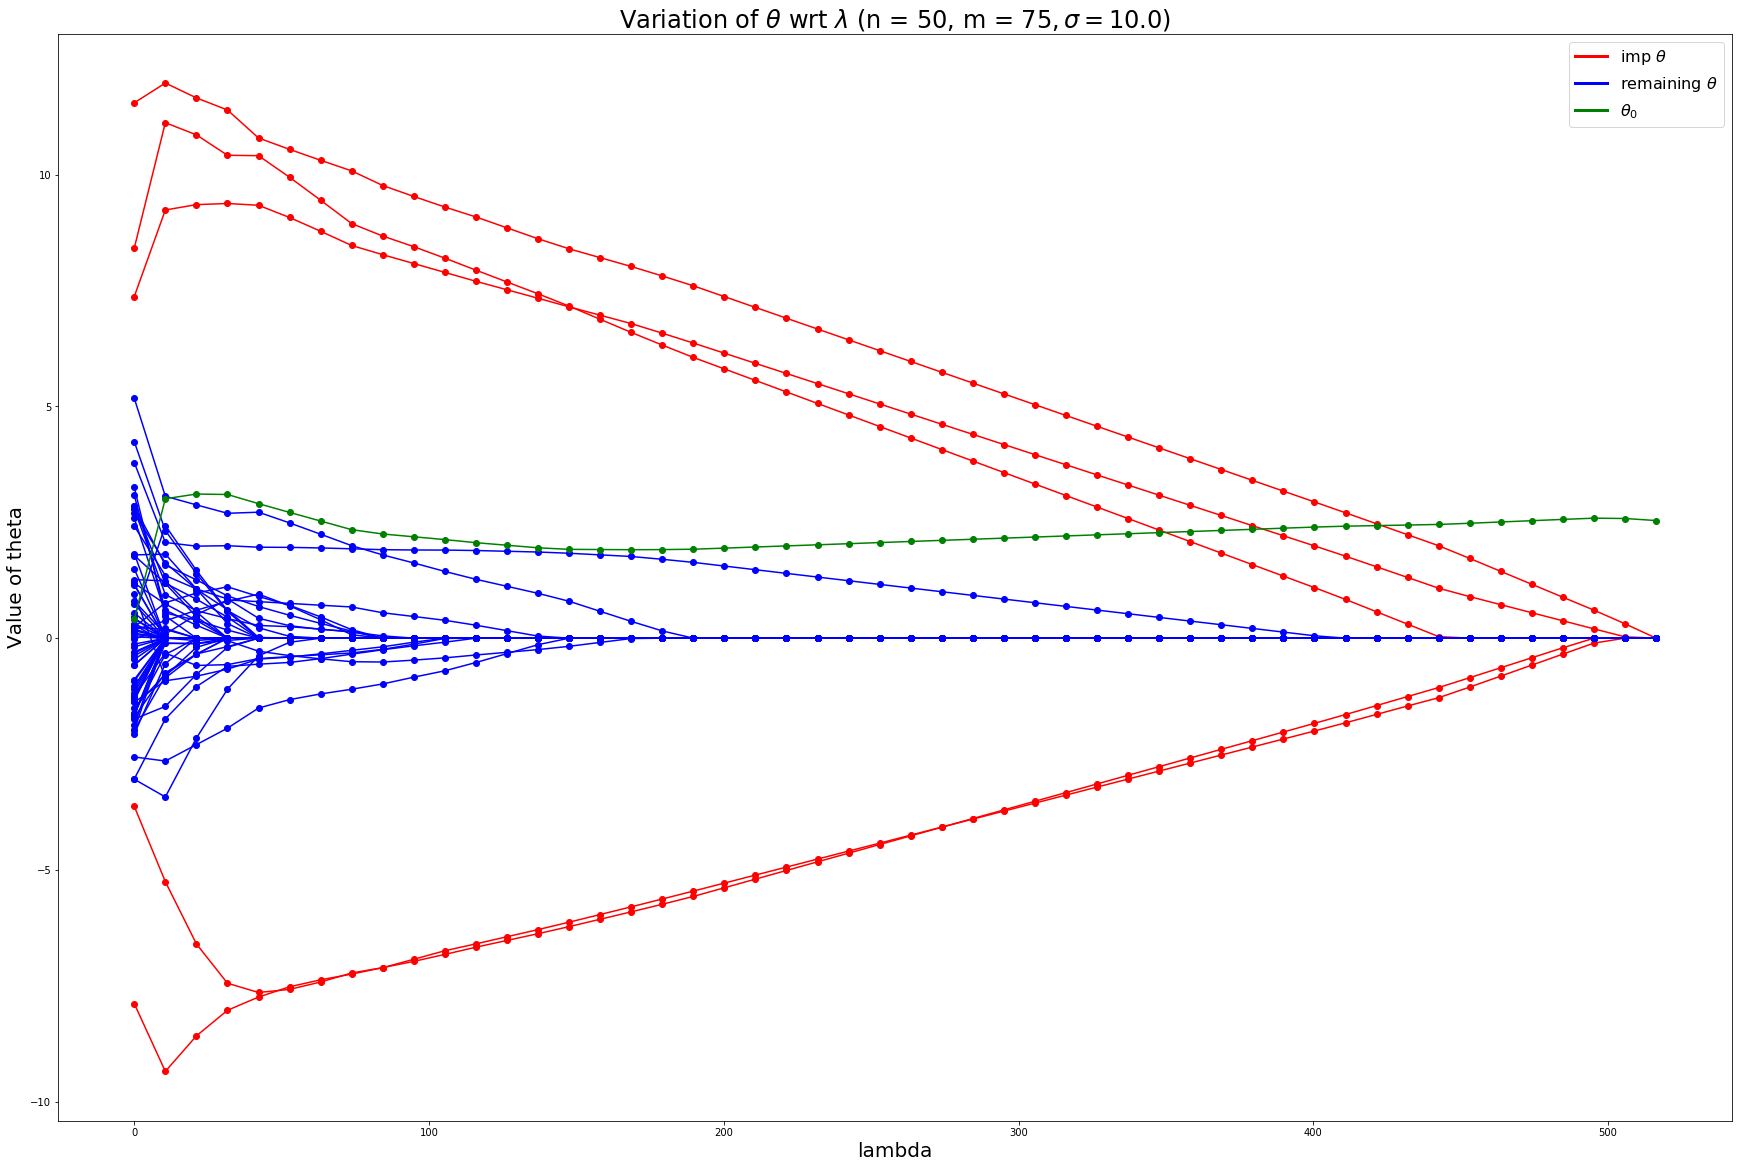

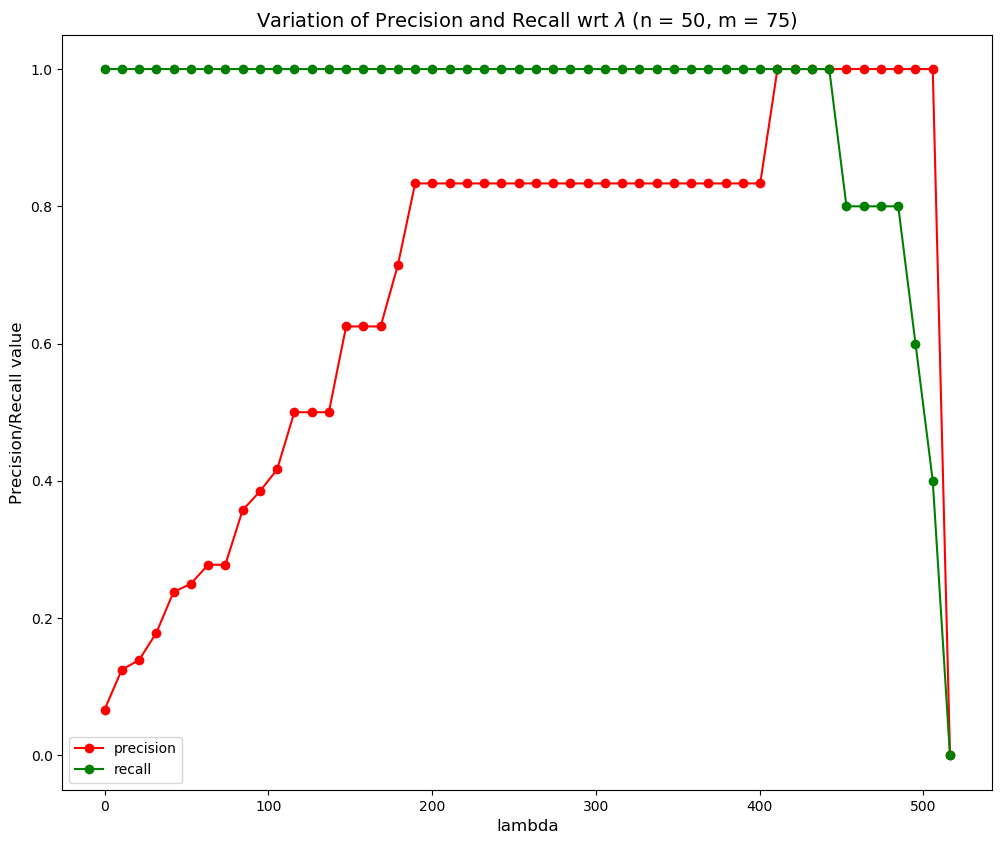

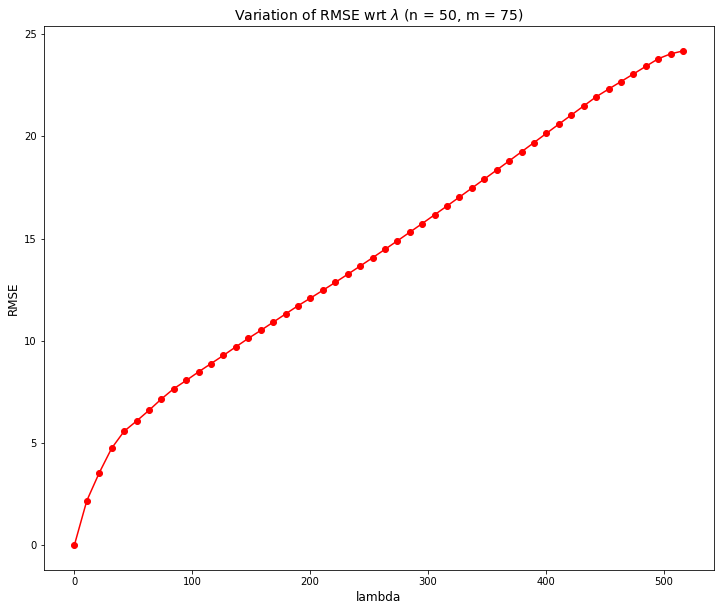

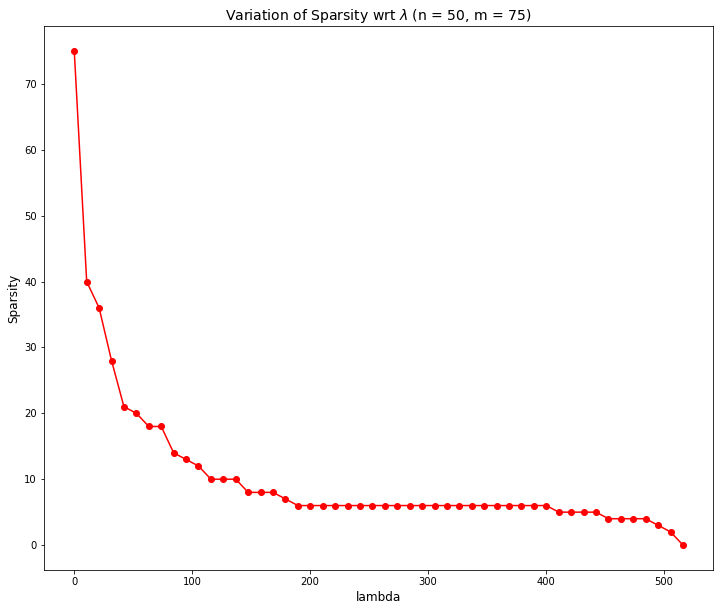

In [201]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
Aggregate(X, y, w_true, w0_true, sigma=10.0)

Lambda max 528.25690
Set of Lambdas [  0.          10.78075311  21.56150621  32.34225932  43.12301243
  53.90376553  64.68451864  75.46527175  86.24602486  97.02677796
 107.80753107 118.58828418 129.36903728 140.14979039 150.9305435
 161.7112966  172.49204971 183.27280282 194.05355593 204.83430903
 215.61506214 226.39581525 237.17656835 247.95732146 258.73807457
 269.51882767 280.29958078 291.08033389 301.861087   312.6418401
 323.42259321 334.20334632 344.98409942 355.76485253 366.54560564
 377.32635874 388.10711185 398.88786496 409.66861807 420.44937117
 431.23012428 442.01087739 452.79163049 463.5723836  474.35313671
 485.13388981 495.91464292 506.69539603 517.47614914 528.25690224]
Sparsity: [75, 11, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 0]
For lambda 0.00000, precision = 0.07, recall = 1.00
For lambda 10.78075, precision = 0.45, recall = 1.00
For lambda 21.56151, precision = 0.83

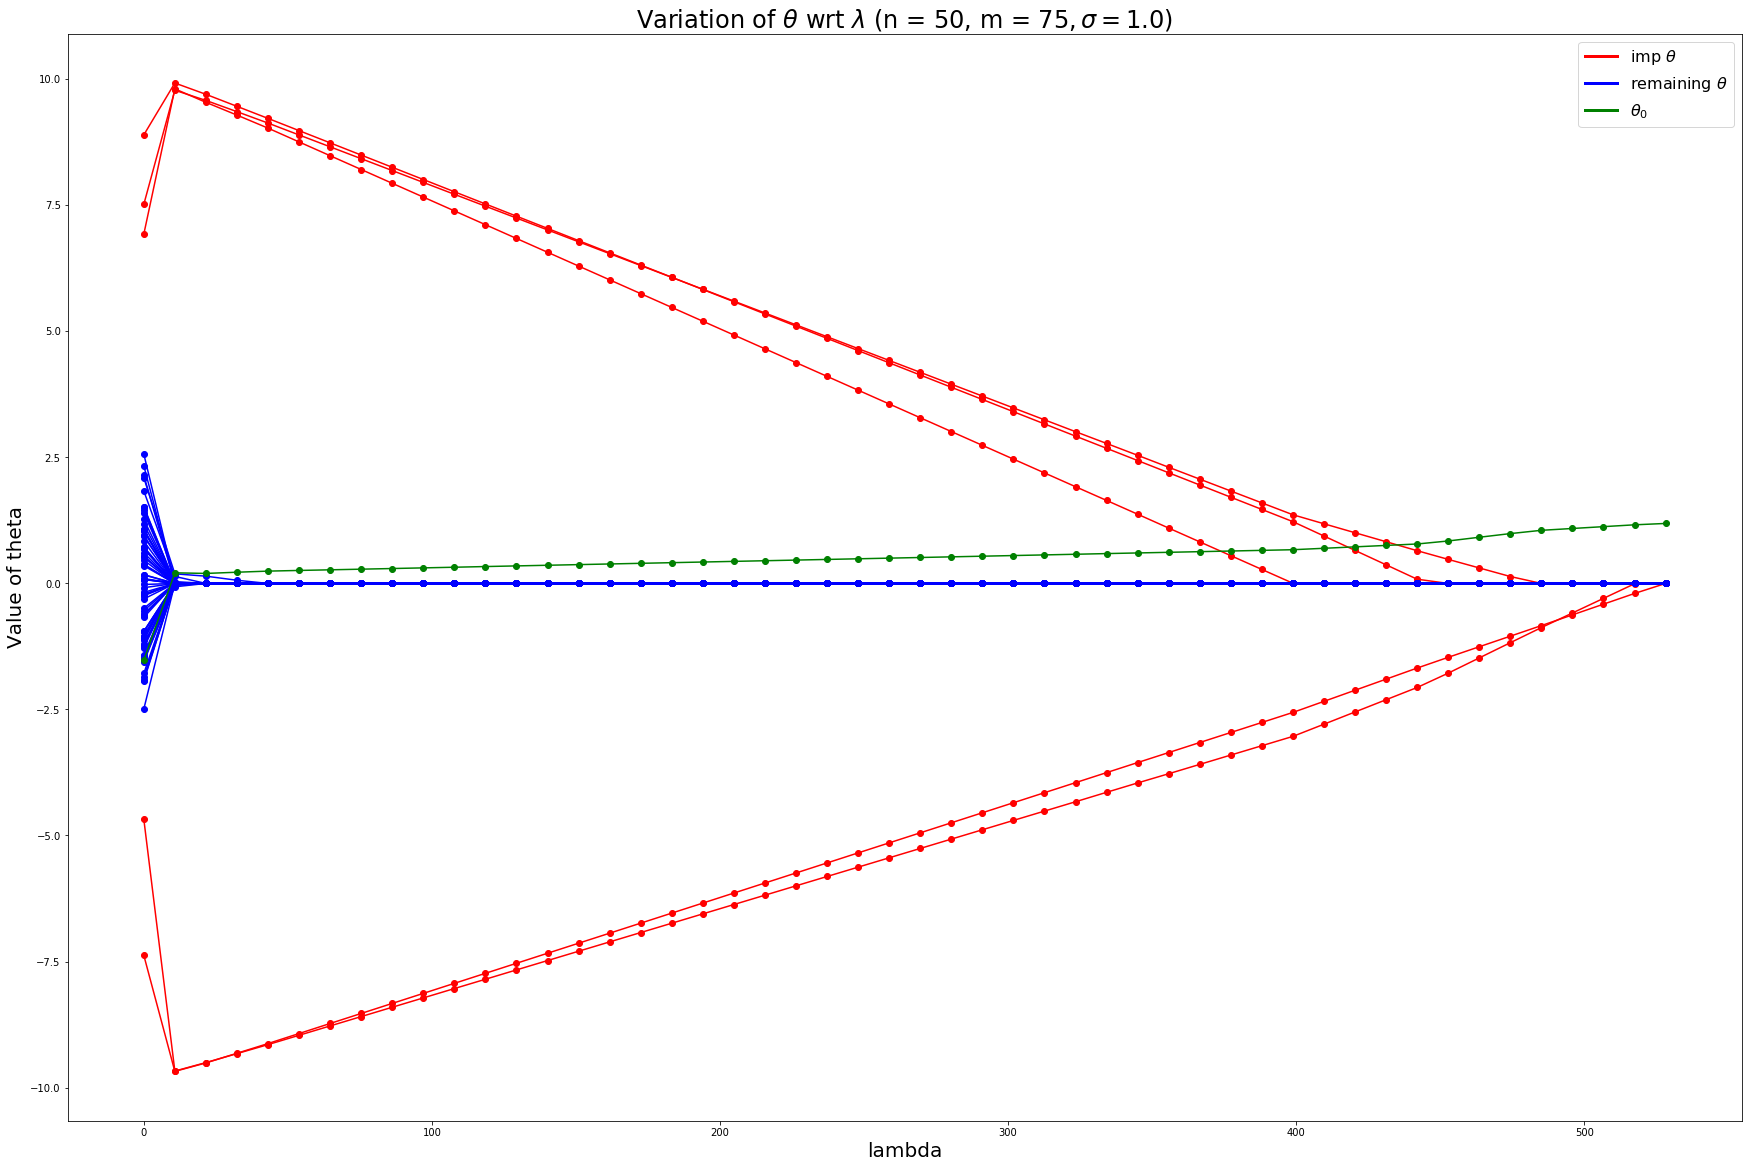

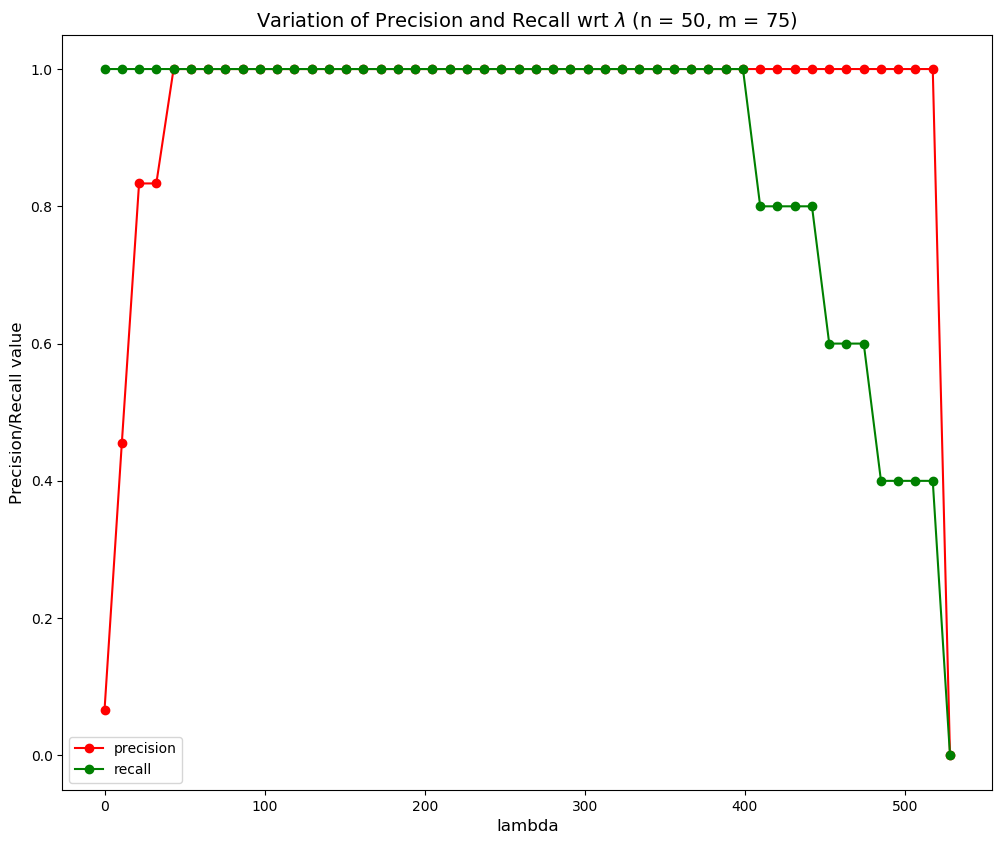

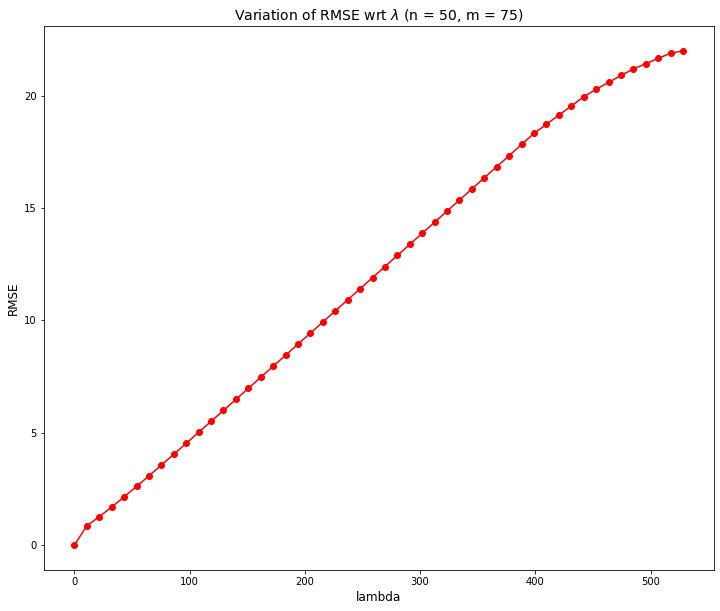

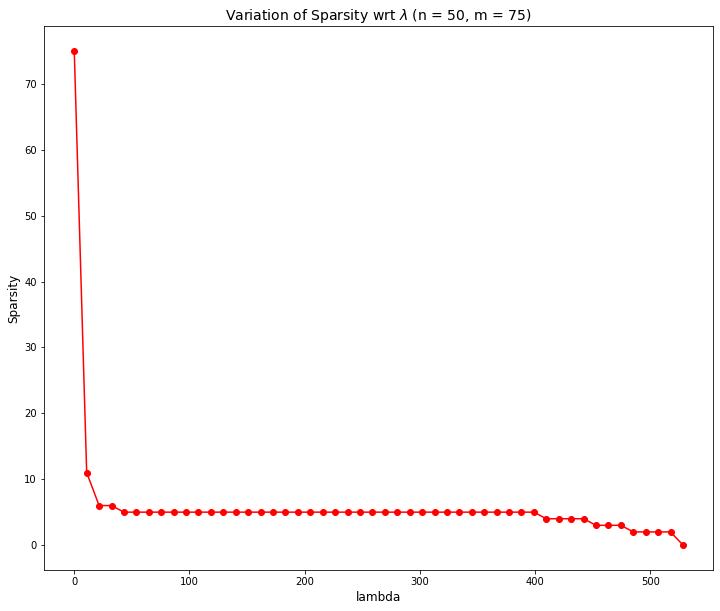

Lambda max 882.77161
Set of Lambdas [  0.          18.01574708  36.03149416  54.04724124  72.06298832
  90.0787354  108.09448248 126.11022956 144.12597665 162.14172373
 180.15747081 198.17321789 216.18896497 234.20471205 252.22045913
 270.23620621 288.25195329 306.26770037 324.28344745 342.29919453
 360.31494161 378.33068869 396.34643577 414.36218286 432.37792994
 450.39367702 468.4094241  486.42517118 504.44091826 522.45666534
 540.47241242 558.4881595  576.50390658 594.51965366 612.53540074
 630.55114782 648.5668949  666.58264198 684.59838907 702.61413615
 720.62988323 738.64563031 756.66137739 774.67712447 792.69287155
 810.70861863 828.72436571 846.74011279 864.75585987 882.77160695]
Sparsity: [150, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.03, recall = 1.00
For lambda 18.01575, precision = 0.62, recall = 1.00
For lambda 36.03149, precision = 1.

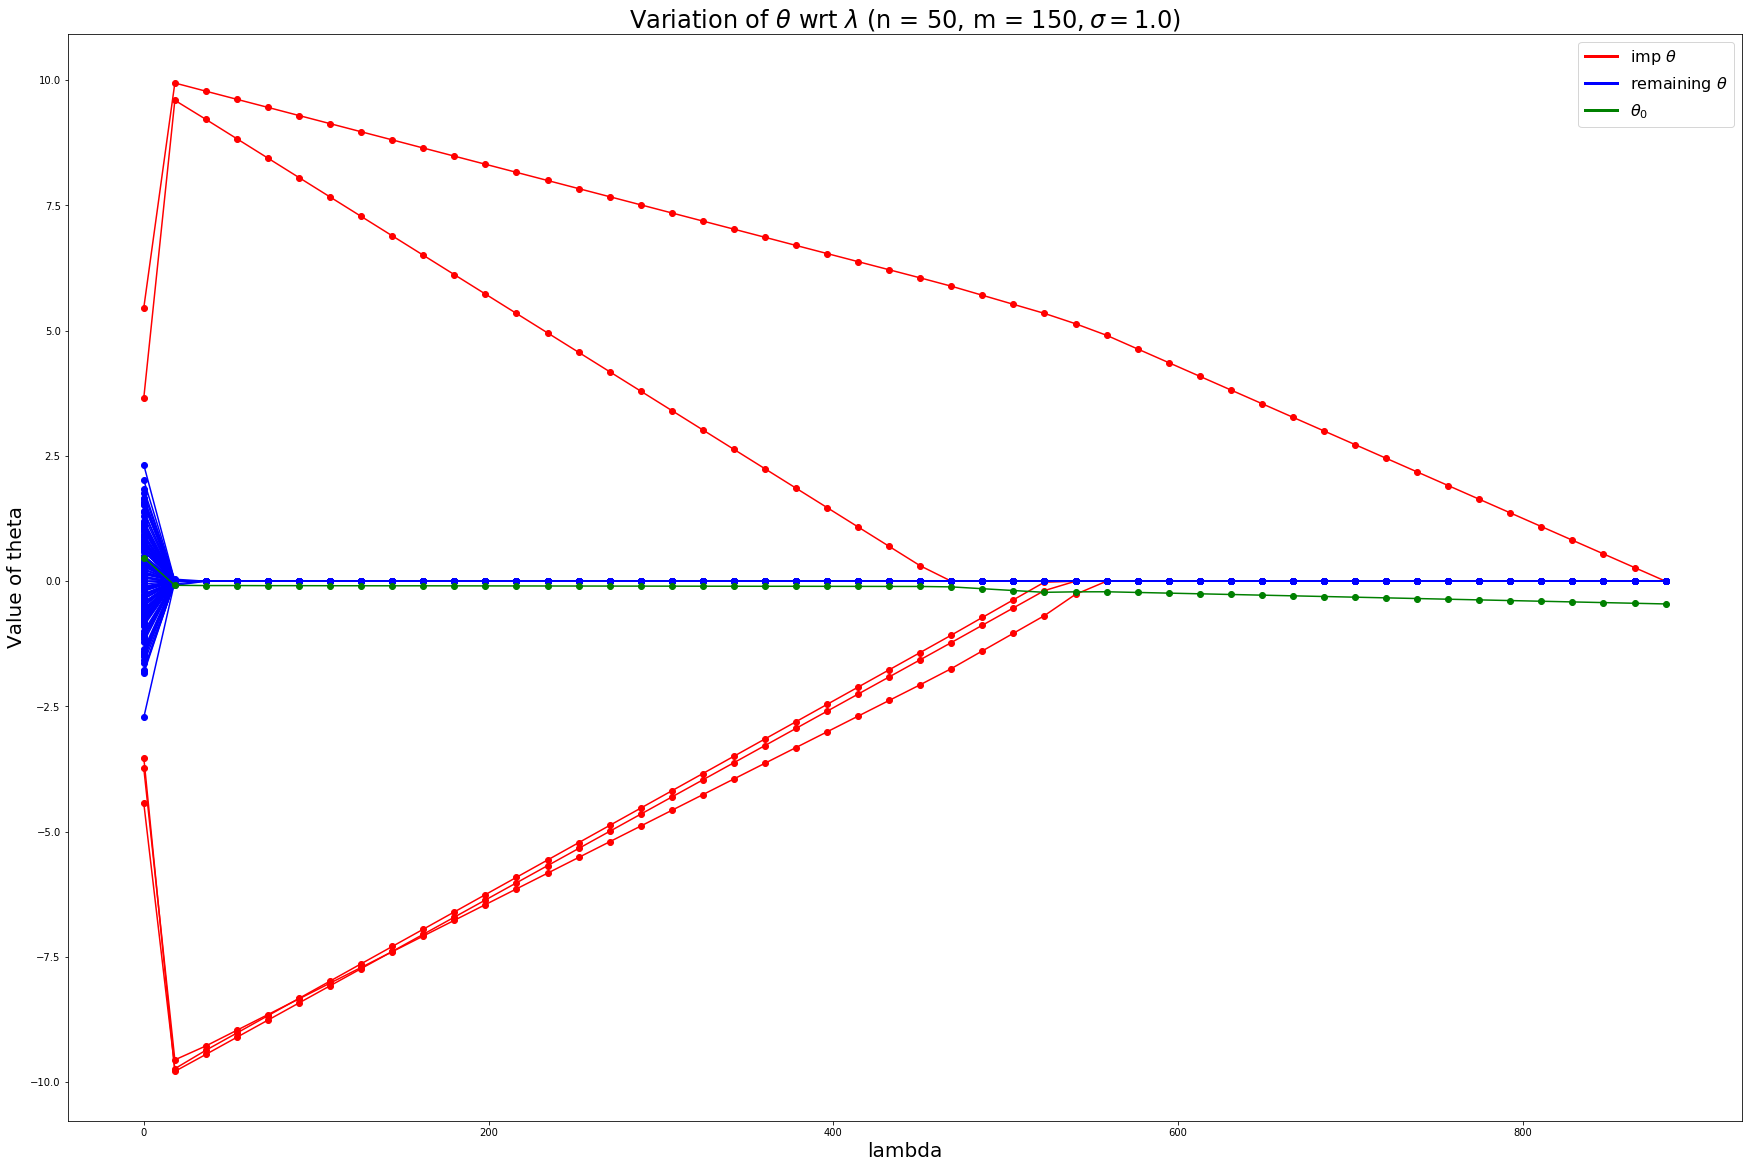

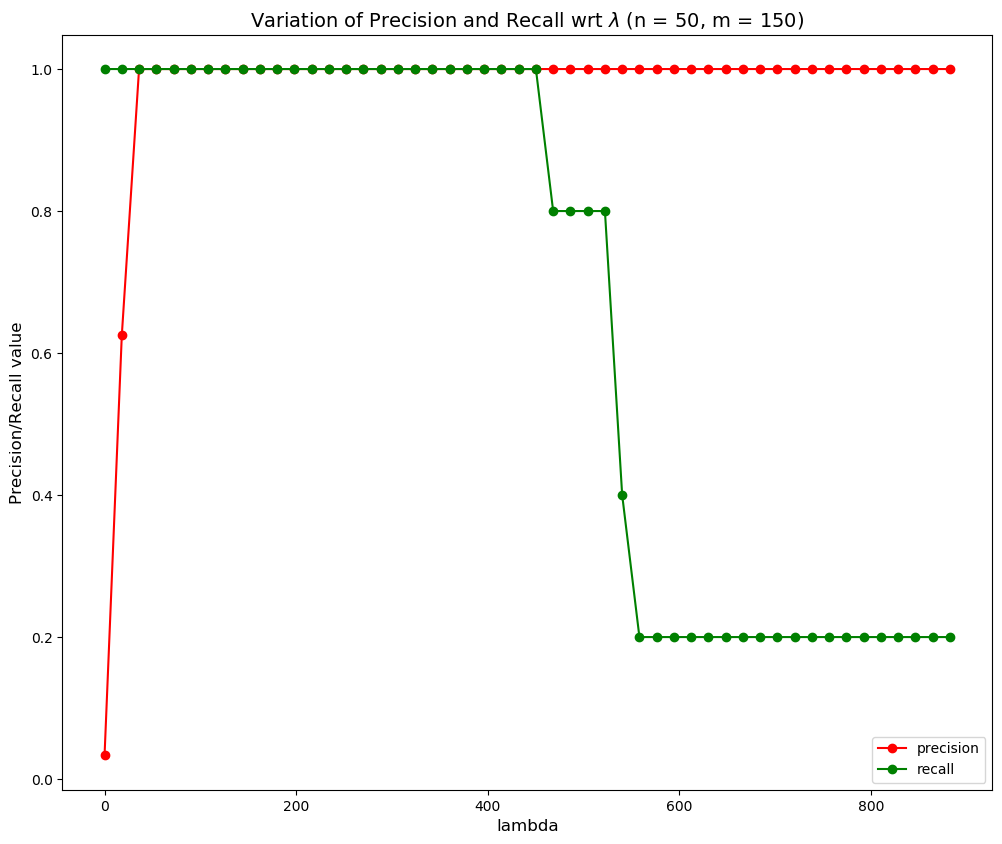

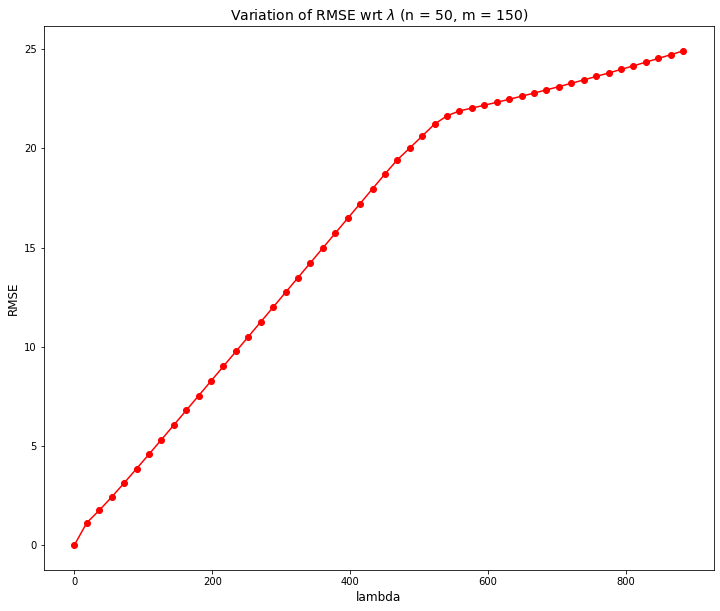

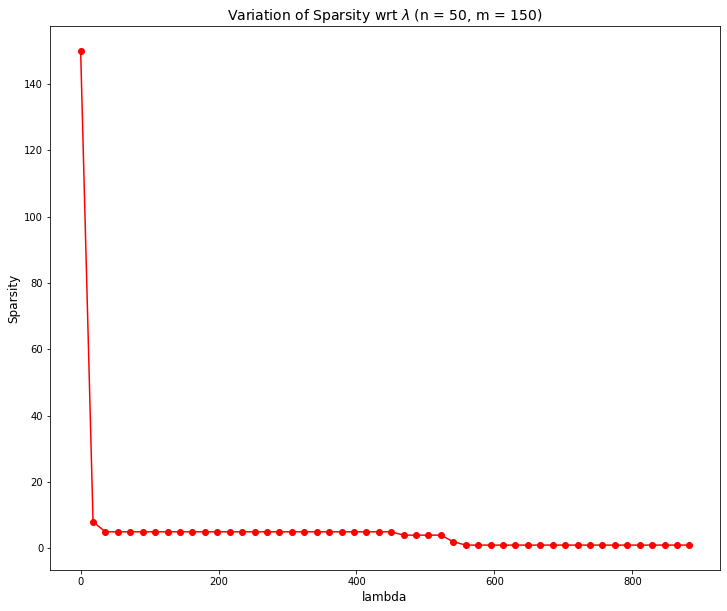

Lambda max 892.92059
Set of Lambdas [  0.          18.22286913  36.44573825  54.66860738  72.89147651
  91.11434563 109.33721476 127.56008389 145.78295301 164.00582214
 182.22869127 200.45156039 218.67442952 236.89729865 255.12016777
 273.3430369  291.56590603 309.78877515 328.01164428 346.23451341
 364.45738253 382.68025166 400.90312079 419.12598991 437.34885904
 455.57172817 473.79459729 492.01746642 510.24033555 528.46320467
 546.6860738  564.90894293 583.13181205 601.35468118 619.57755031
 637.80041943 656.02328856 674.24615769 692.46902682 710.69189594
 728.91476507 747.1376342  765.36050332 783.58337245 801.80624158
 820.0291107  838.25197983 856.47484896 874.69771808 892.92058721]
Sparsity: [1000, 16, 10, 10, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
For lambda 0.00000, precision = 0.01, recall = 1.00
For lambda 18.22287, precision = 0.31, recall = 1.00
For lambda 36.44574, precision 

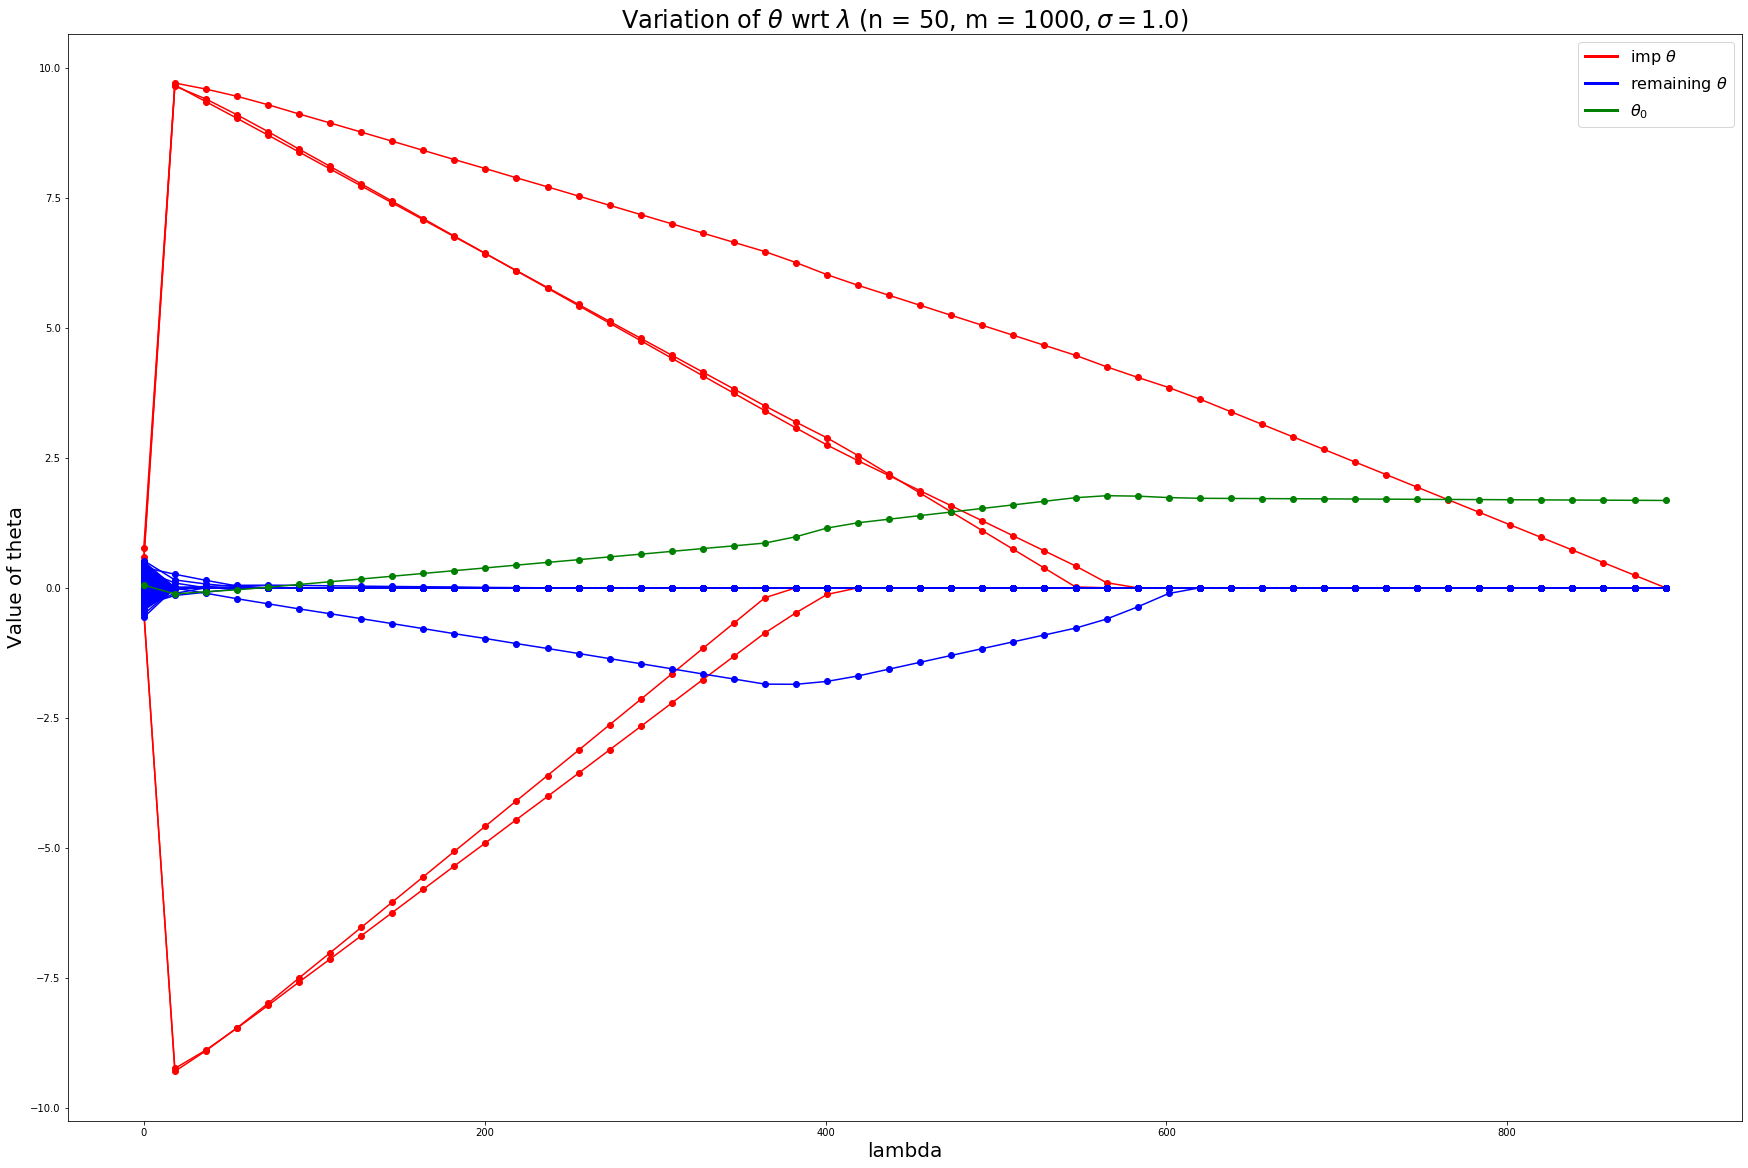

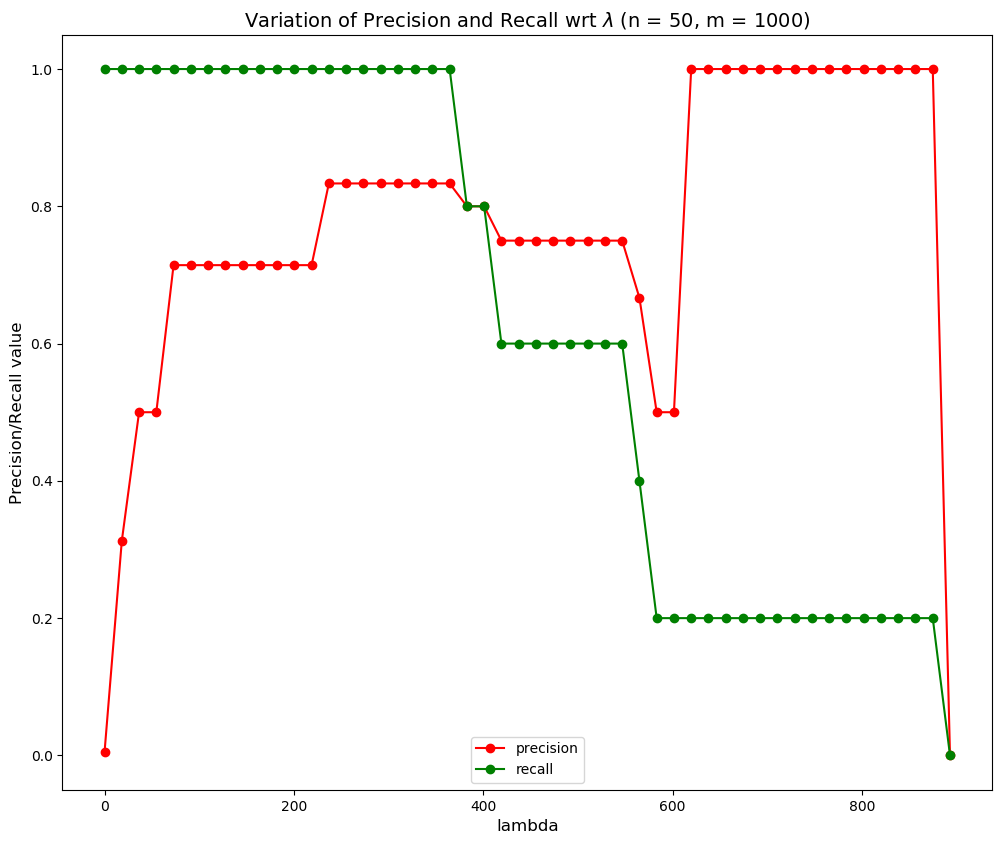

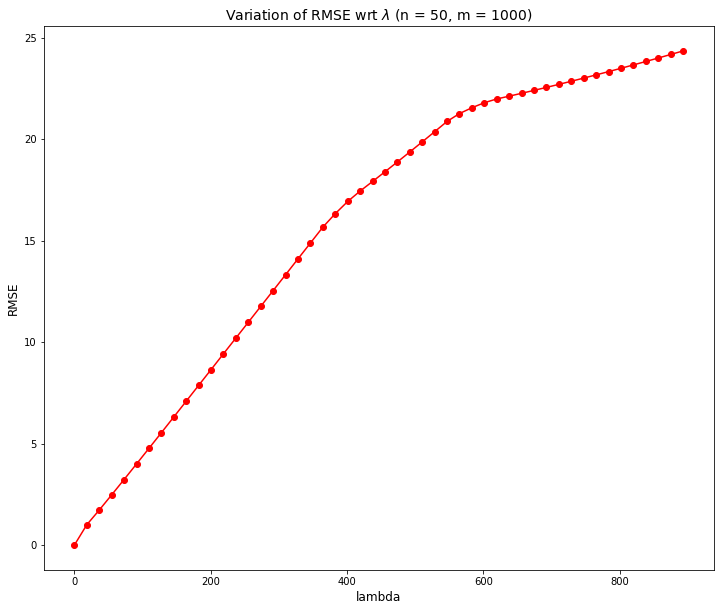

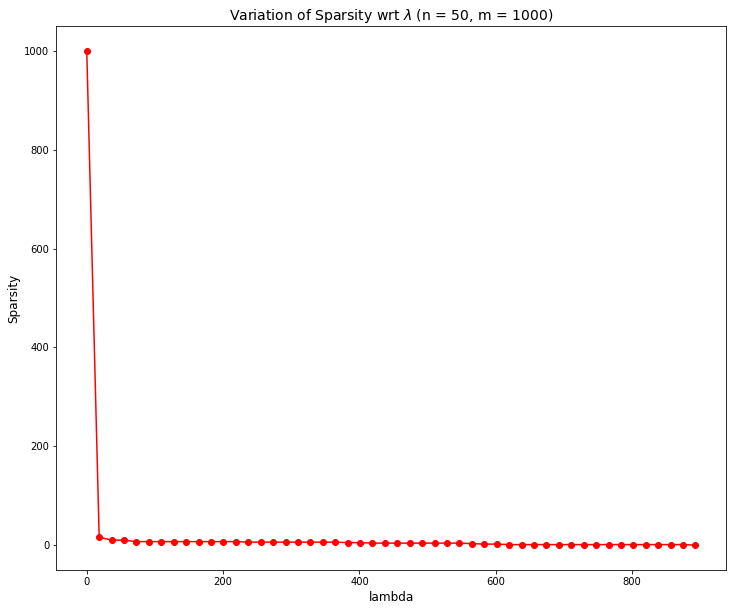

Lambda max 1654.02744
Set of Lambdas [   0.           33.7556621    67.51132419  101.26698629  135.02264838
  168.77831048  202.53397258  236.28963467  270.04529677  303.80095886
  337.55662096  371.31228306  405.06794515  438.82360725  472.57926934
  506.33493144  540.09059354  573.84625563  607.60191773  641.35757982
  675.11324192  708.86890402  742.62456611  776.38022821  810.1358903
  843.8915524   877.64721449  911.40287659  945.15853869  978.91420078
 1012.66986288 1046.42552497 1080.18118707 1113.93684917 1147.69251126
 1181.44817336 1215.20383545 1248.95949755 1282.71515965 1316.47082174
 1350.22648384 1383.98214593 1417.73780803 1451.49347013 1485.24913222
 1519.00479432 1552.76045641 1586.51611851 1620.27178061 1654.0274427 ]


/Users/lkumari/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Sparsity: [75, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.07, recall = 1.00
For lambda 33.75566, precision = 1.00, recall = 1.00
For lambda 67.51132, precision = 1.00, recall = 1.00
For lambda 101.26699, precision = 1.00, recall = 1.00
For lambda 135.02265, precision = 1.00, recall = 1.00
For lambda 168.77831, precision = 1.00, recall = 1.00
For lambda 202.53397, precision = 1.00, recall = 1.00
For lambda 236.28963, precision = 1.00, recall = 1.00
For lambda 270.04530, precision = 1.00, recall = 1.00
For lambda 303.80096, precision = 1.00, recall = 1.00
For lambda 337.55662, precision = 1.00, recall = 1.00
For lambda 371.31228, precision = 1.00, recall = 1.00
For lambda 405.06795, precision = 1.00, recall = 1.00
For lambda 438.82361, precision = 1.00, recall = 1.00
For lambda 472.57927, precision = 1.00, recall = 1.00
For lambda 506.33493, precision 

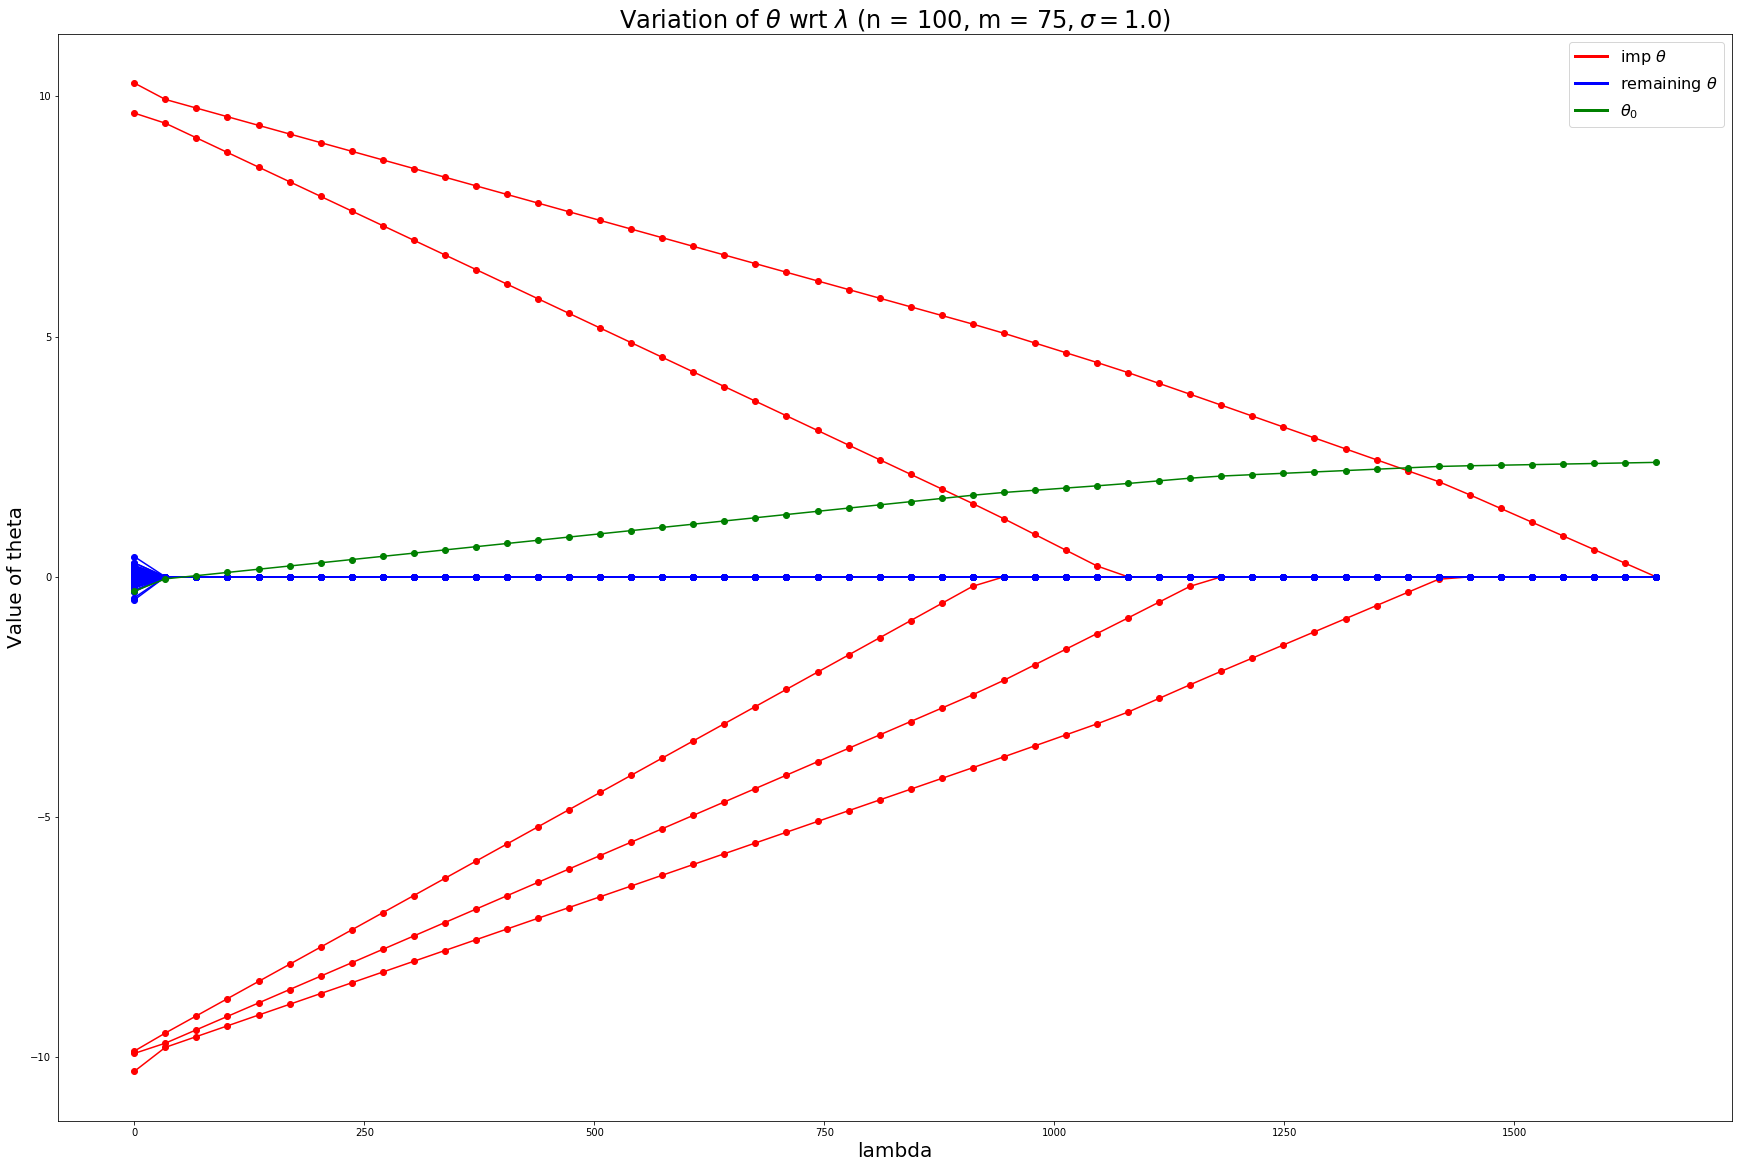

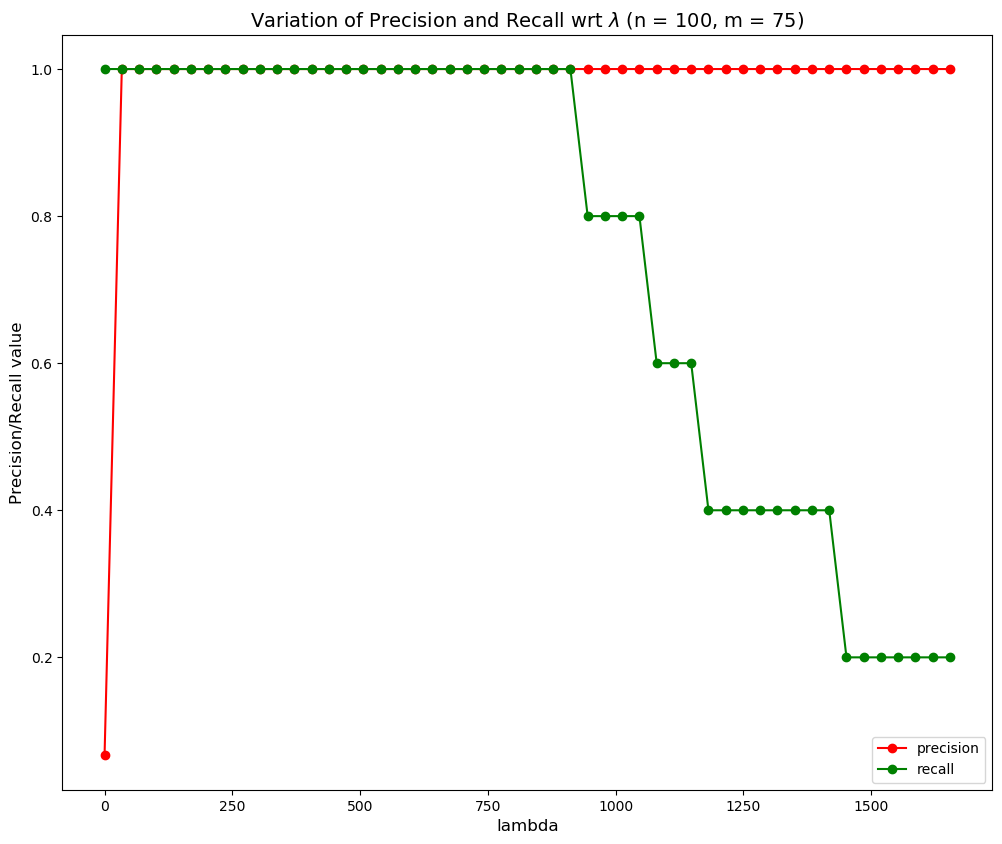

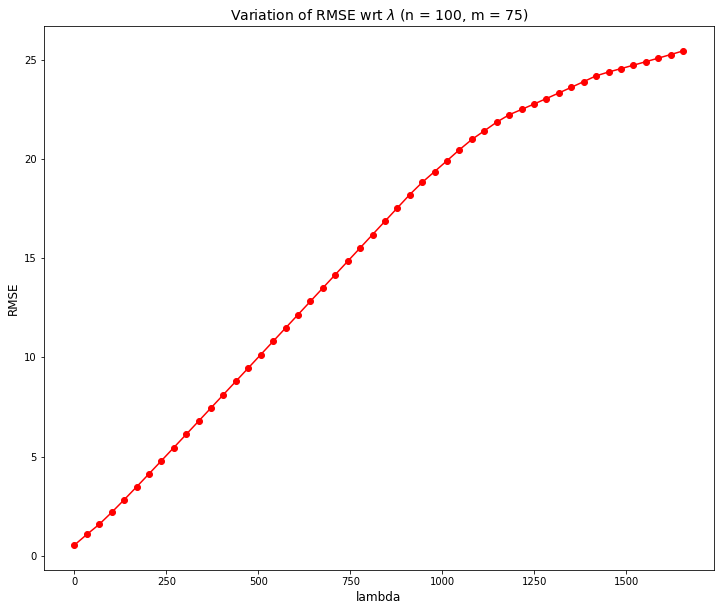

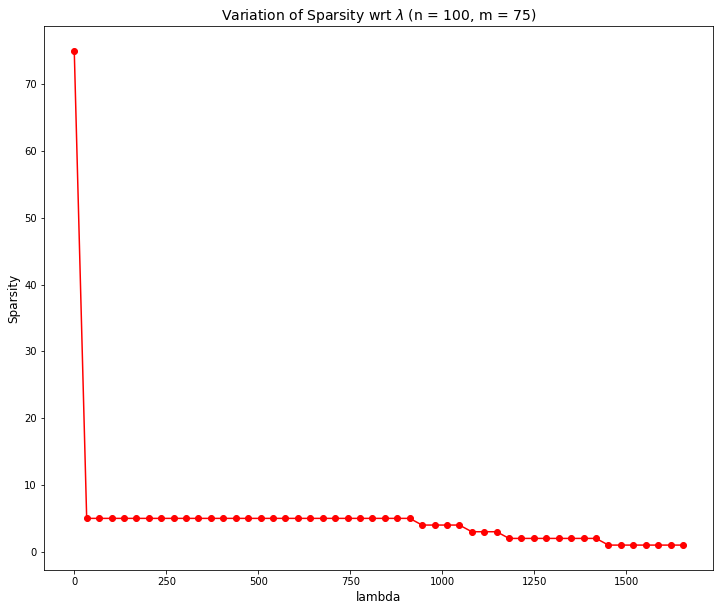

Lambda max 1020.19058
Set of Lambdas [   0.           20.820216     41.640432     62.460648     83.280864
  104.10107999  124.92129599  145.74151199  166.56172799  187.38194399
  208.20215999  229.02237599  249.84259199  270.66280799  291.48302399
  312.30323998  333.12345598  353.94367198  374.76388798  395.58410398
  416.40431998  437.22453598  458.04475198  478.86496798  499.68518397
  520.50539997  541.32561597  562.14583197  582.96604797  603.78626397
  624.60647997  645.42669597  666.24691197  687.06712796  707.88734396
  728.70755996  749.52777596  770.34799196  791.16820796  811.98842396
  832.80863996  853.62885596  874.44907196  895.26928795  916.08950395
  936.90971995  957.72993595  978.55015195  999.37036795 1020.19058395]
Sparsity: [150, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.03, recall = 1.00
For lambda 20.82022, precision = 0.50,

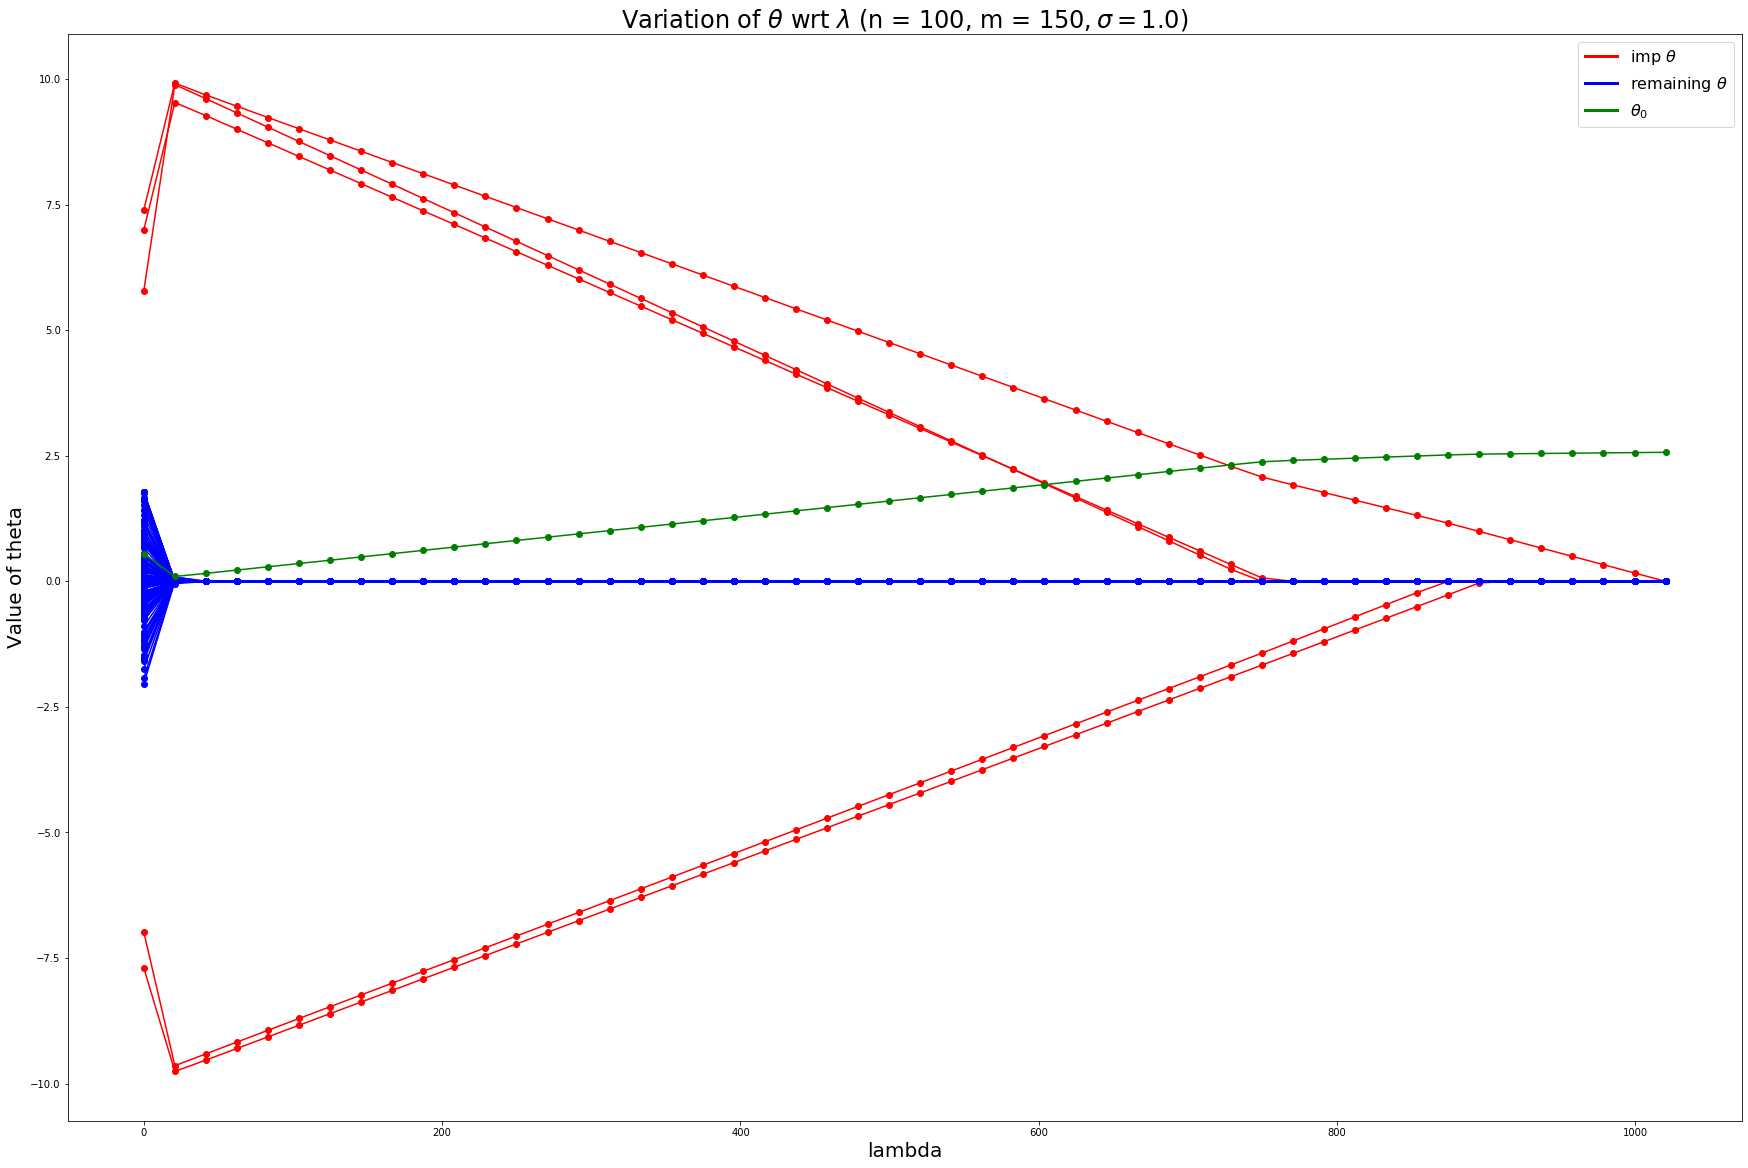

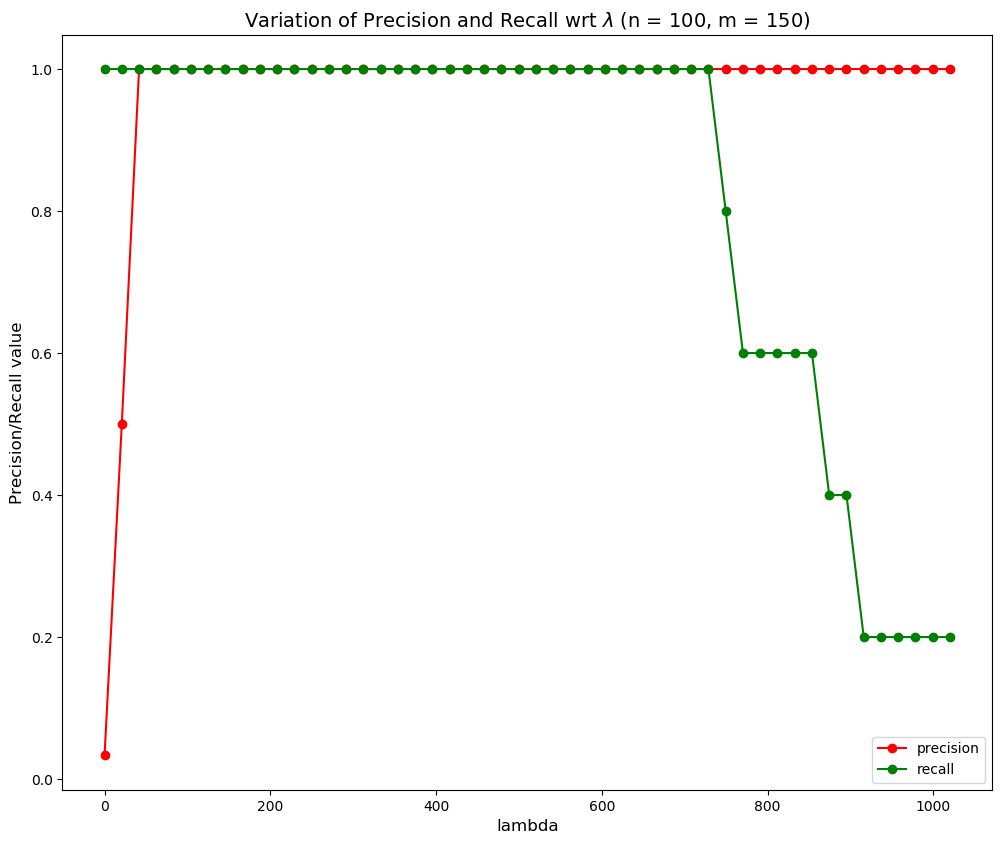

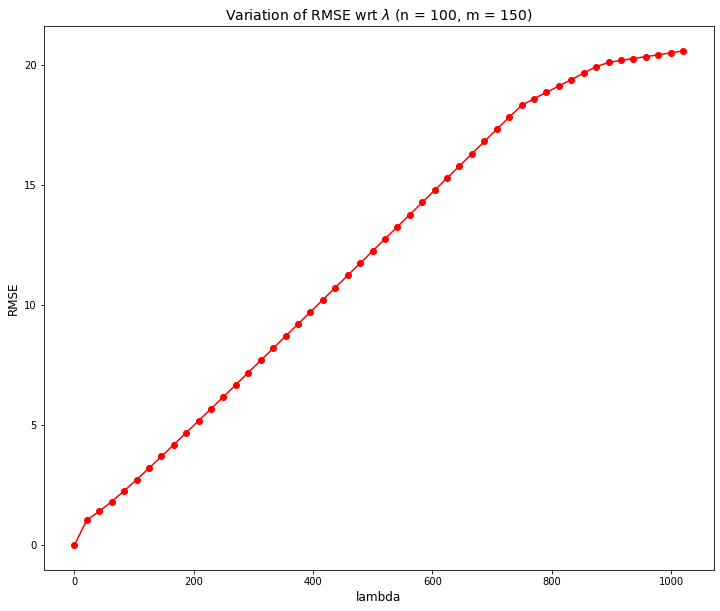

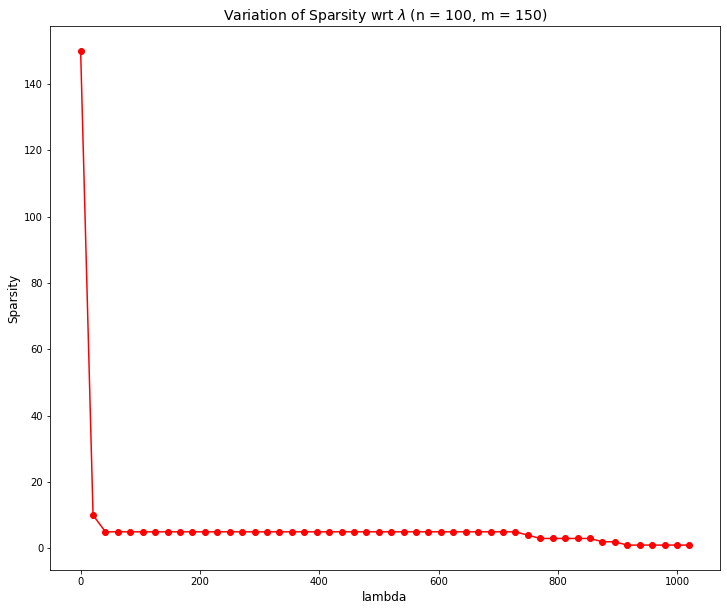

Lambda max 1203.84734
Set of Lambdas [   0.           24.568313     49.136626     73.704939     98.273252
  122.841565    147.409878    171.978191    196.546504    221.114817
  245.68313     270.251443    294.819756    319.388069    343.956382
  368.524695    393.093008    417.661321    442.229634    466.797947
  491.36626001  515.93457301  540.50288601  565.07119901  589.63951201
  614.20782501  638.77613801  663.34445101  687.91276401  712.48107701
  737.04939001  761.61770301  786.18601601  810.75432901  835.32264201
  859.89095501  884.45926801  909.02758101  933.59589401  958.16420701
  982.73252001 1007.30083301 1031.86914601 1056.43745901 1081.00577201
 1105.57408501 1130.14239801 1154.71071101 1179.27902401 1203.84733701]
Sparsity: [1000, 24, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 0]
For lambda 0.00000, precision = 0.01, recall = 1.00
For lambda 24.56831, precision = 0.21, reca

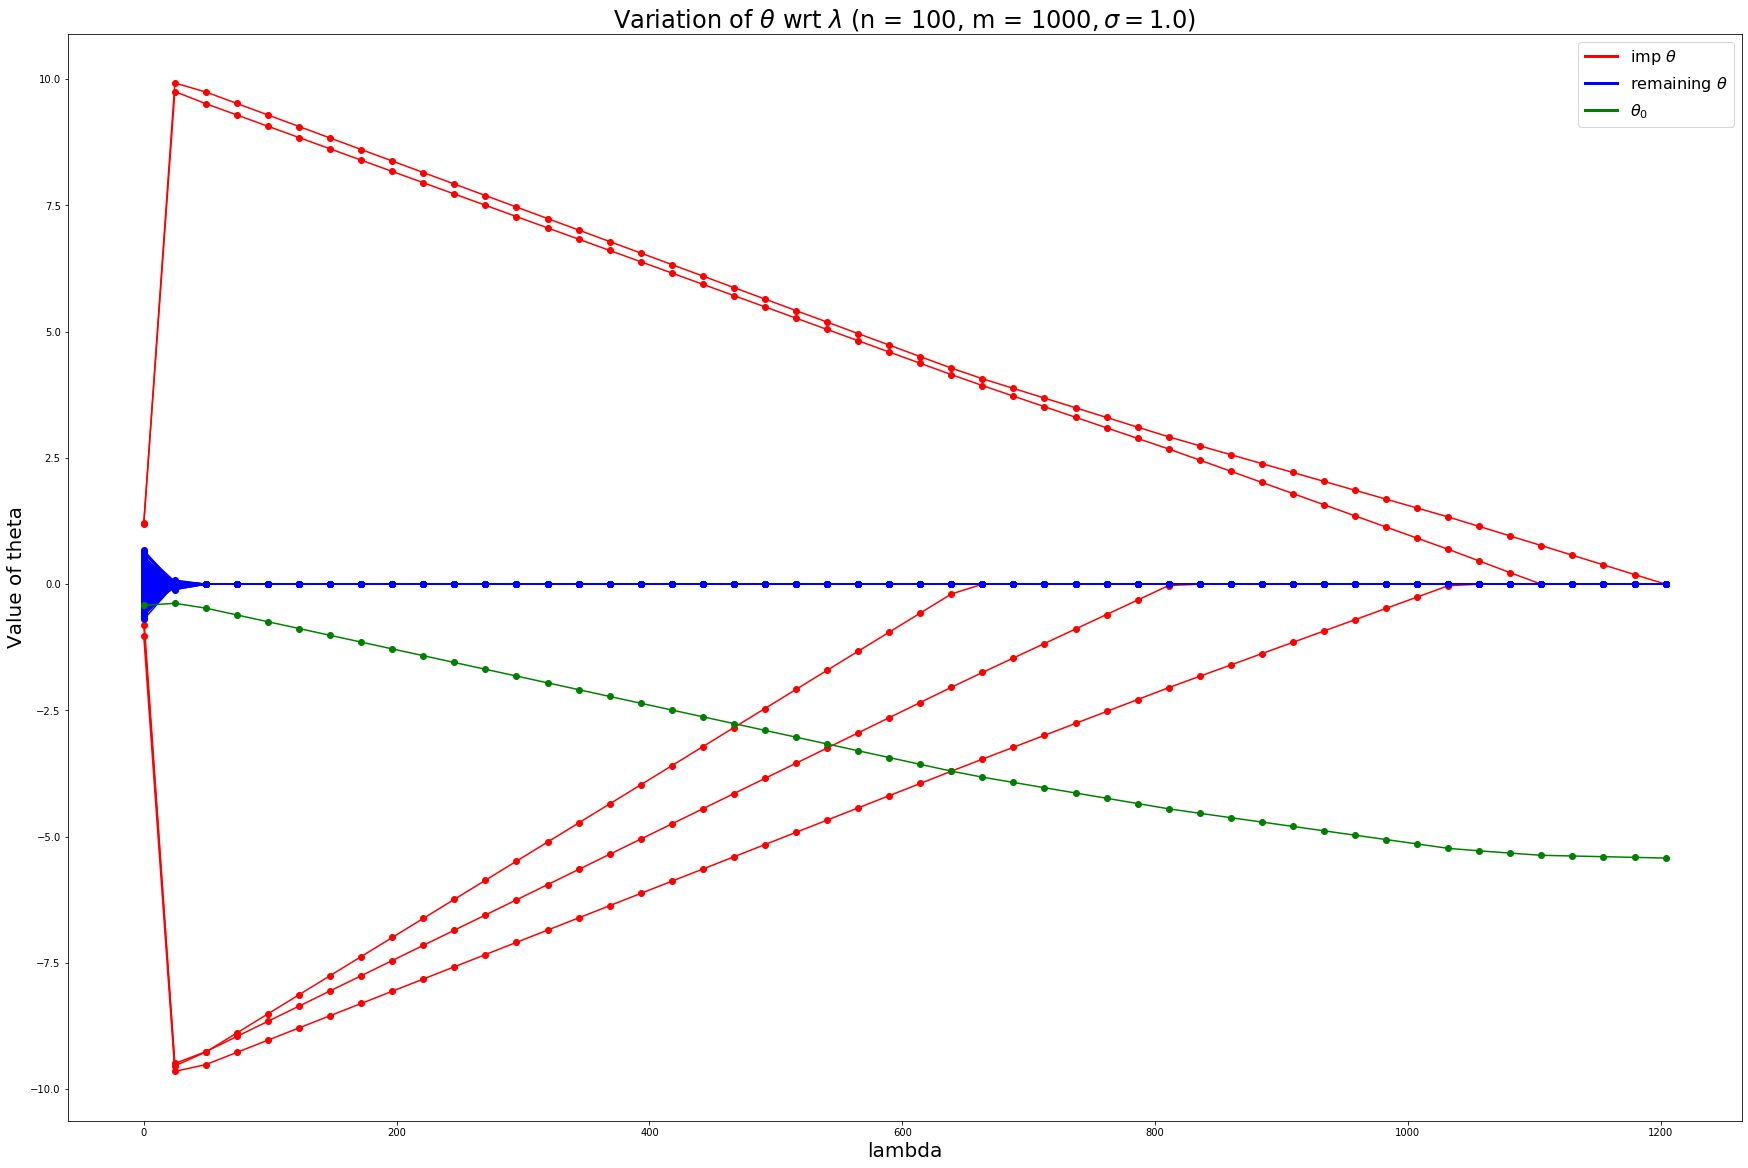

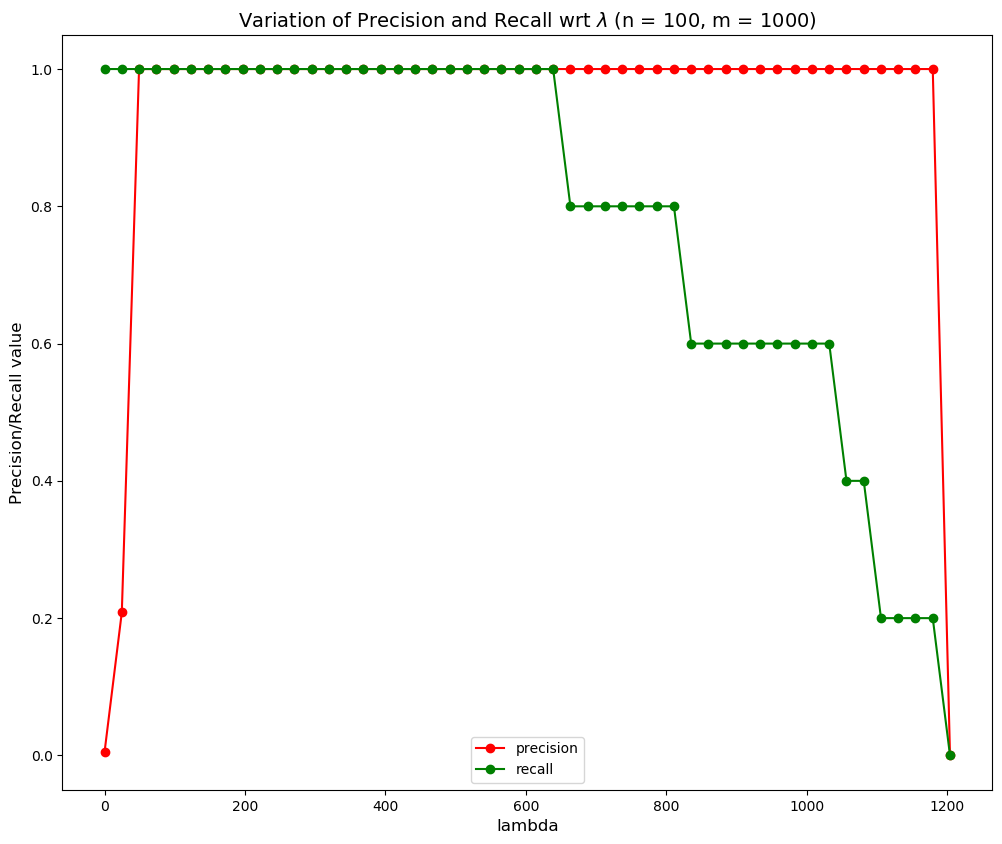

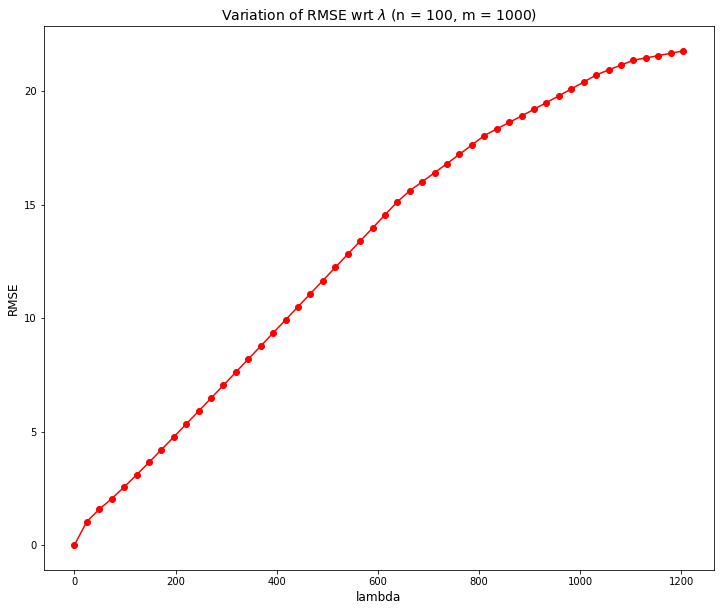

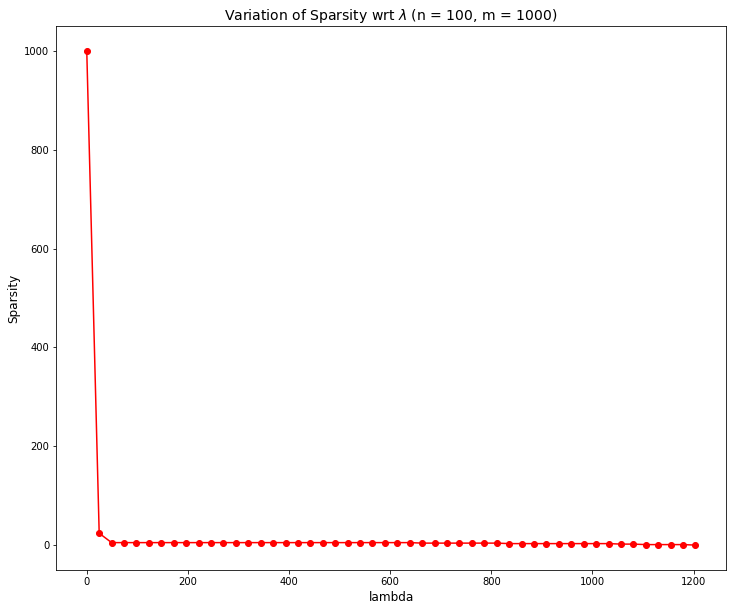

In [202]:
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity

n_d_values = [(50,75), (50,150), (50,1000), (100,75), (100,150), (100,1000)]

for n_d in n_d_values:
    n, d = n_d[0], n_d[1]
    X, y, w_true, w0_true = DataGenerator(n, d, k=5, sigma=1.0)
    Aggregate(X, y, w_true, w0_true, print_pr=True)


Lambda max 1363.58862
Set of Lambdas [   0.           27.82833917   55.65667835   83.48501752  111.3133567
  139.14169587  166.97003505  194.79837422  222.62671339  250.45505257
  278.28339174  306.11173092  333.94007009  361.76840927  389.59674844
  417.42508761  445.25342679  473.08176596  500.91010514  528.73844431
  556.56678349  584.39512266  612.22346183  640.05180101  667.88014018
  695.70847936  723.53681853  751.36515771  779.19349688  807.02183605
  834.85017523  862.6785144   890.50685358  918.33519275  946.16353193
  973.9918711  1001.82021027 1029.64854945 1057.47688862 1085.3052278
 1113.13356697 1140.96190615 1168.79024532 1196.61858449 1224.44692367
 1252.27526284 1280.10360202 1307.93194119 1335.76028037 1363.58861954]
Sparsity: [10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.50, recall = 1.00
For lambda 27.82834, precision = 1.00, r

/Users/lkumari/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


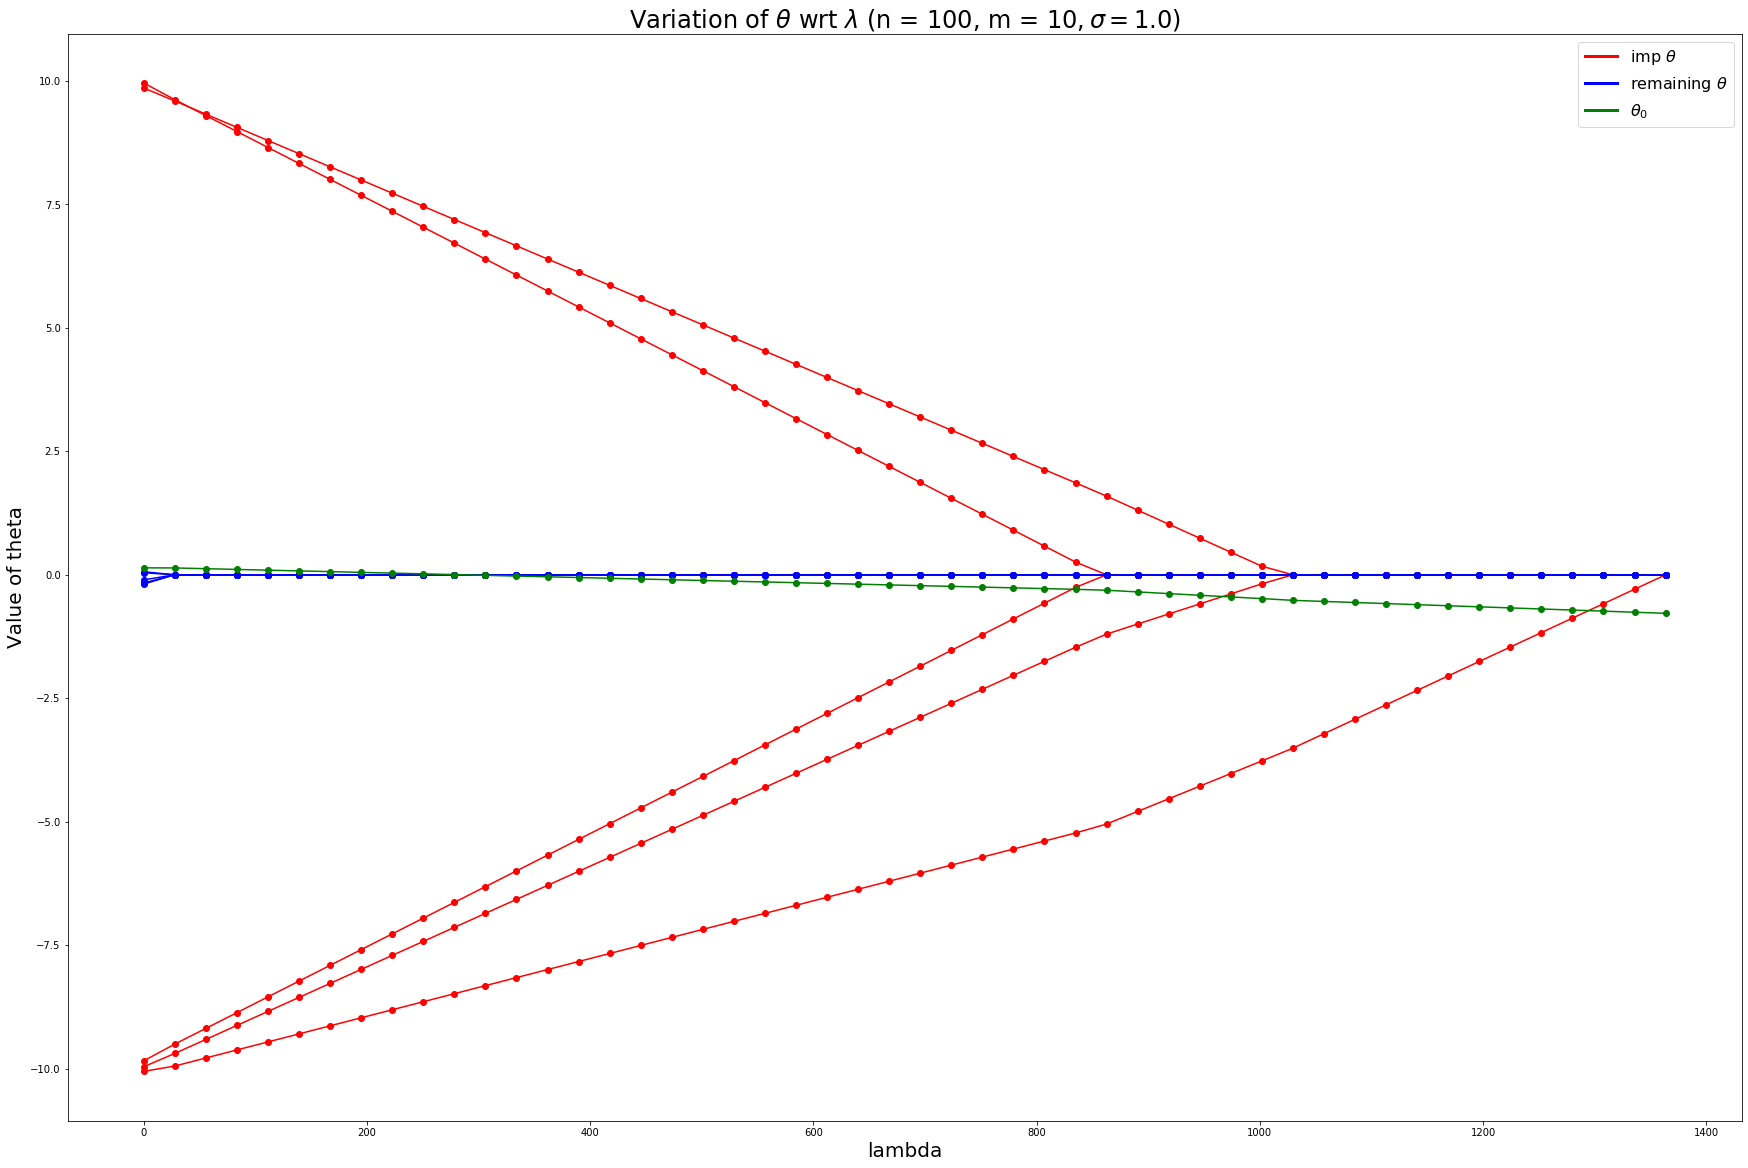

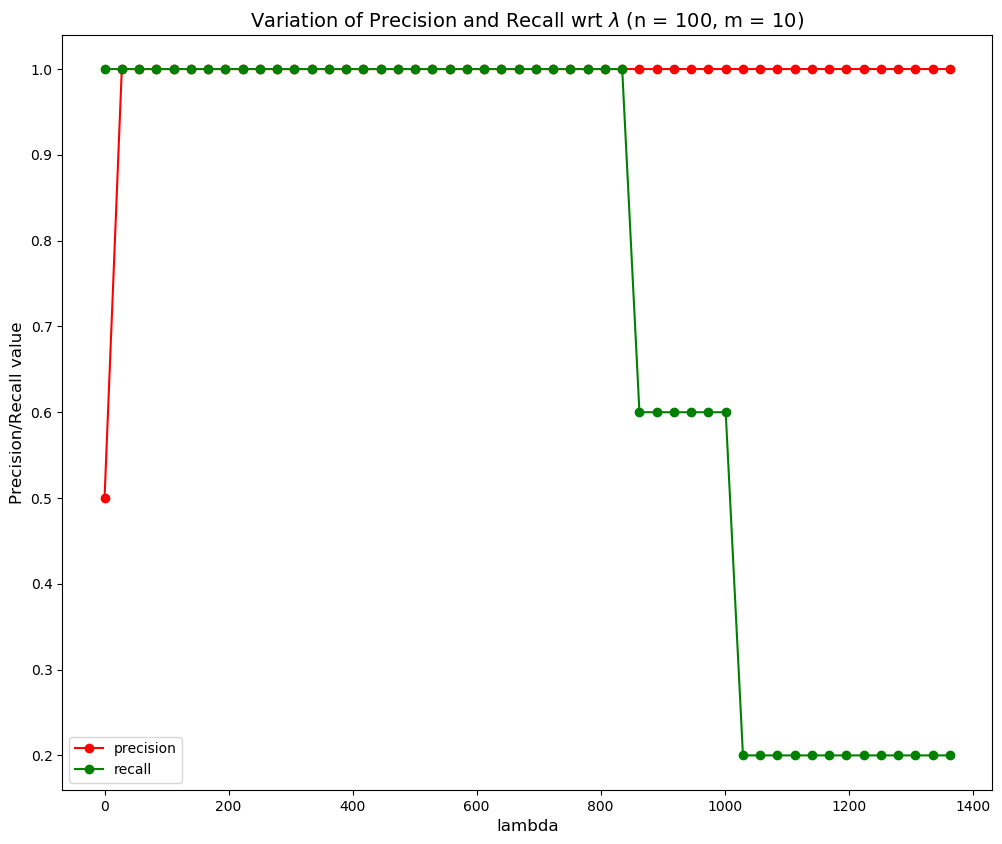

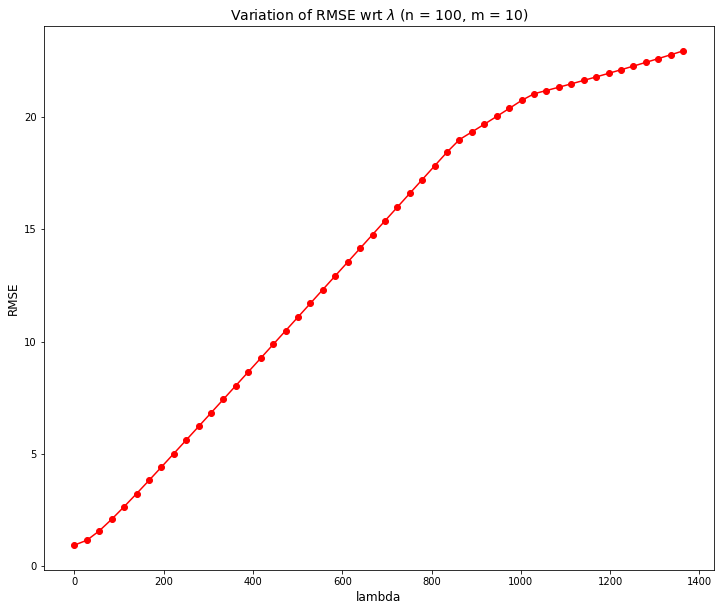

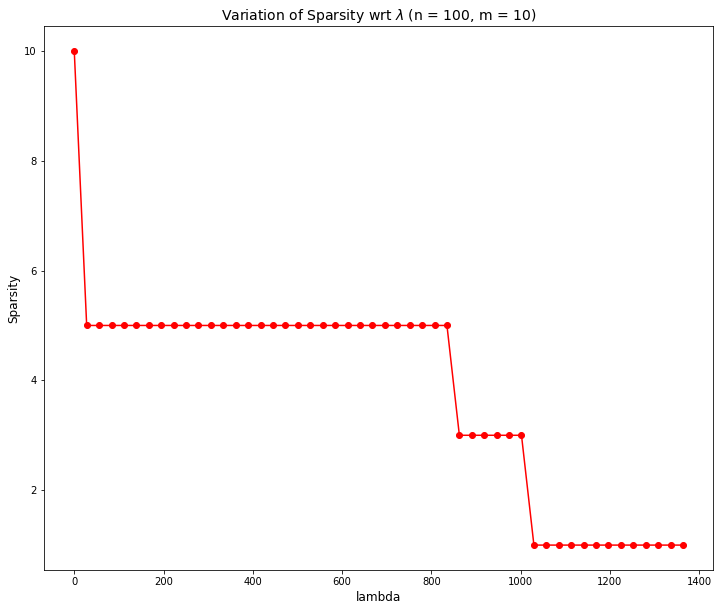

Lambda max 7088.90172
Set of Lambdas [   0.          144.67146365  289.34292731  434.01439096  578.68585462
  723.35731827  868.02878192 1012.70024558 1157.37170923 1302.04317289
 1446.71463654 1591.38610019 1736.05756385 1880.7290275  2025.40049116
 2170.07195481 2314.74341846 2459.41488212 2604.08634577 2748.75780943
 2893.42927308 3038.10073674 3182.77220039 3327.44366404 3472.1151277
 3616.78659135 3761.45805501 3906.12951866 4050.80098231 4195.47244597
 4340.14390962 4484.81537328 4629.48683693 4774.15830058 4918.82976424
 5063.50122789 5208.17269155 5352.8441552  5497.51561885 5642.18708251
 5786.85854616 5931.53000982 6076.20147347 6220.87293712 6365.54440078
 6510.21586443 6654.88732809 6799.55879174 6944.23025539 7088.90171905]
Sparsity: [25, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.20, recall = 1.00
For lambda 144.67146, precision = 1.00,

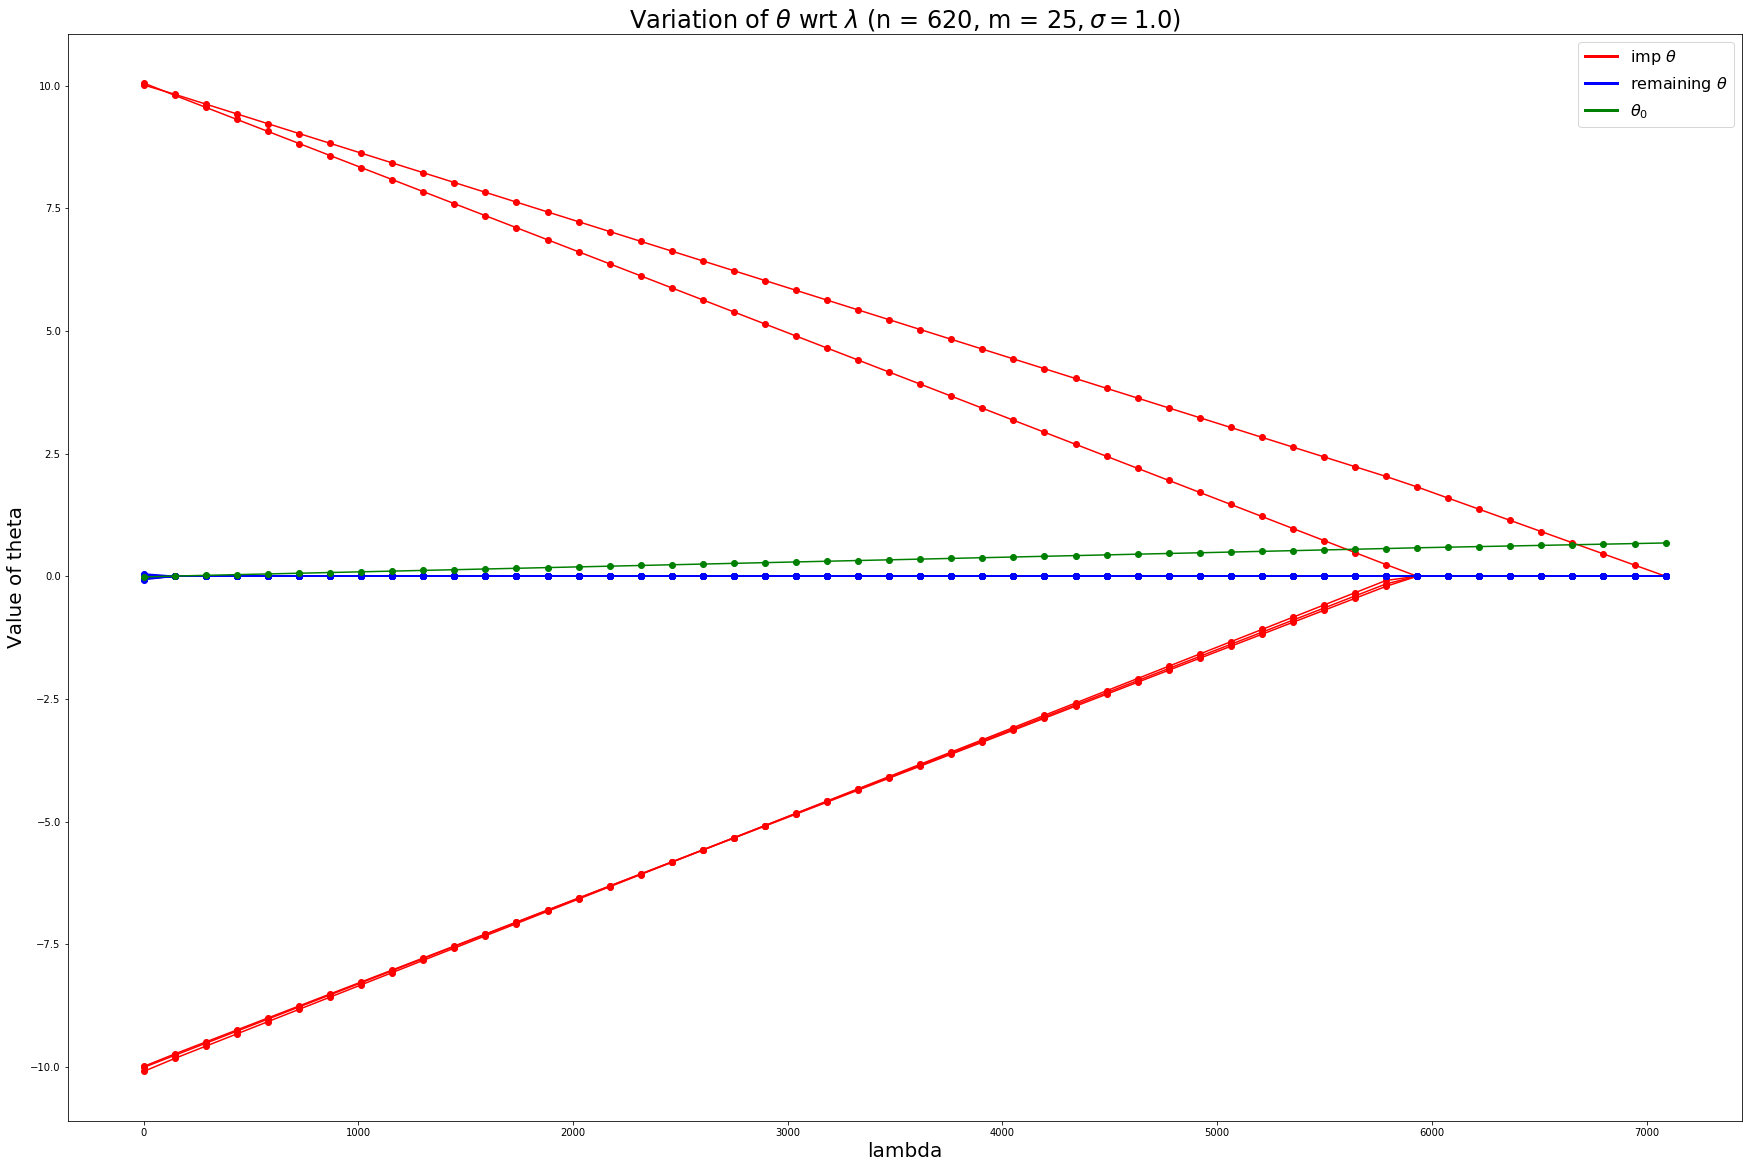

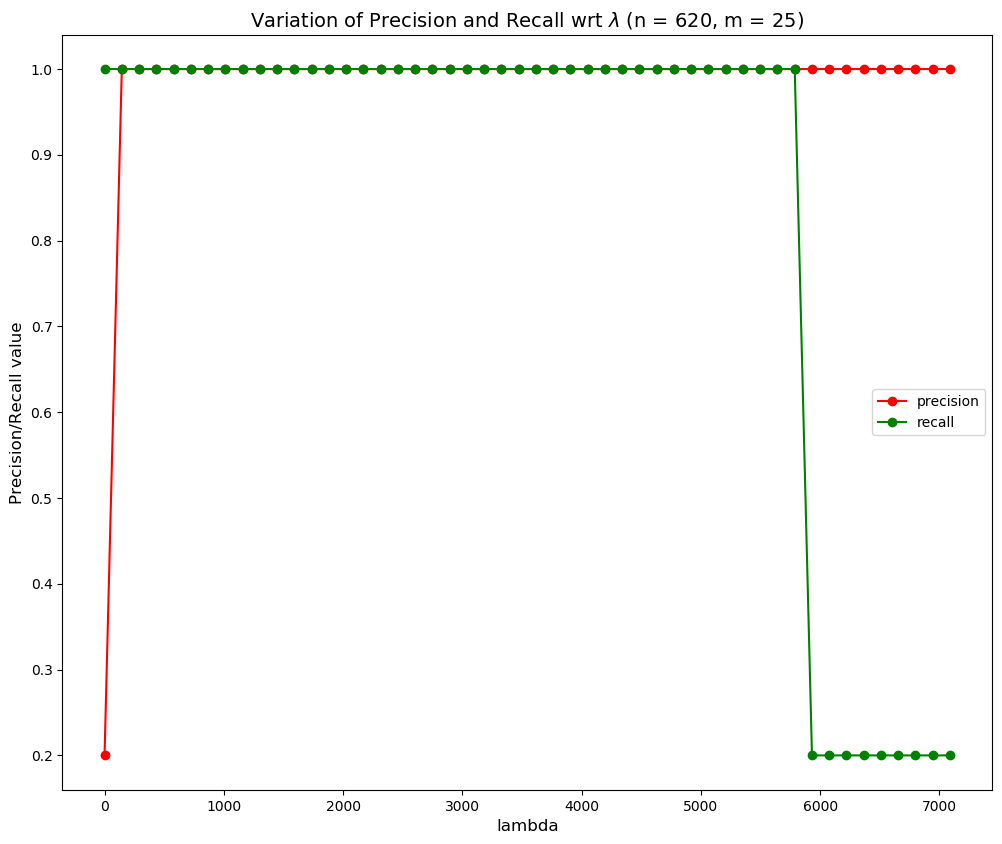

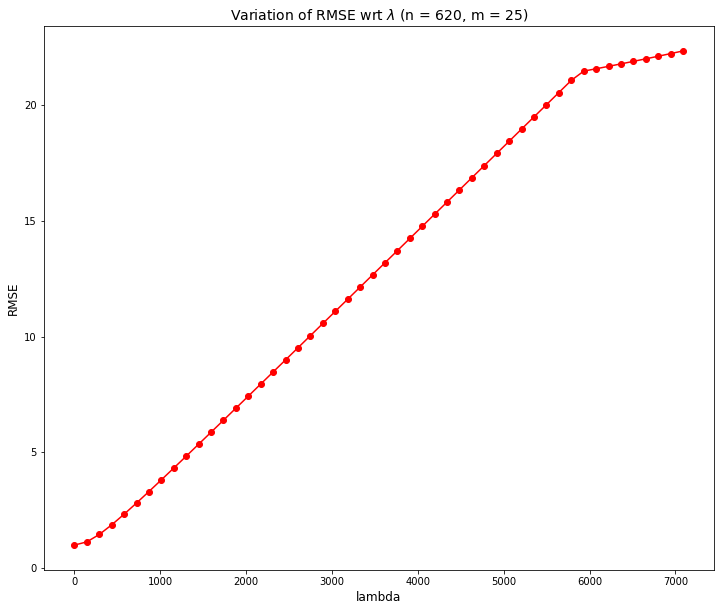

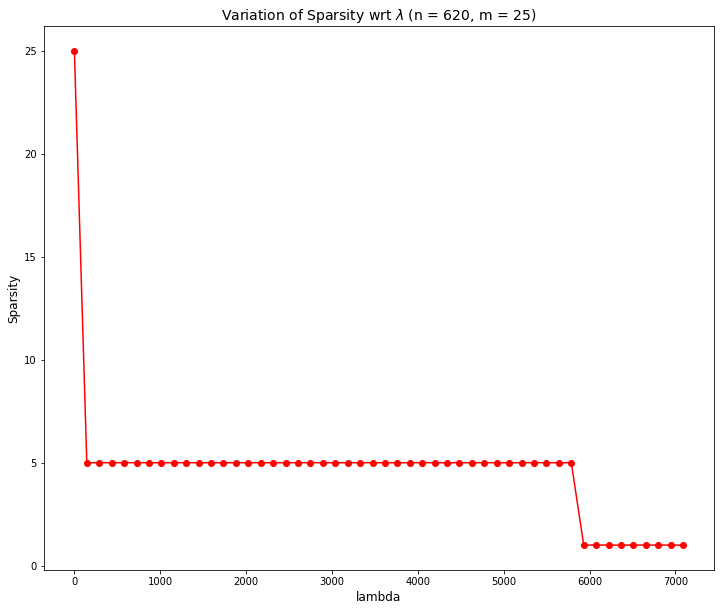

Lambda max 568.29893
Set of Lambdas [  0.          11.59793738  23.19587476  34.79381214  46.39174952
  57.9896869   69.58762428  81.18556166  92.78349904 104.38143643
 115.97937381 127.57731119 139.17524857 150.77318595 162.37112333
 173.96906071 185.56699809 197.16493547 208.76287285 220.36081023
 231.95874761 243.55668499 255.15462237 266.75255975 278.35049713
 289.94843451 301.5463719  313.14430928 324.74224666 336.34018404
 347.93812142 359.5360588  371.13399618 382.73193356 394.32987094
 405.92780832 417.5257457  429.12368308 440.72162046 452.31955784
 463.91749522 475.5154326  487.11336999 498.71130737 510.30924475
 521.90718213 533.50511951 545.10305689 556.70099427 568.29893165]
Sparsity: [50, 10, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.10, recall = 1.00
For lambda 11.59794, precision = 0.50, recall = 1.00
For lambda 23.19587, precision = 0.

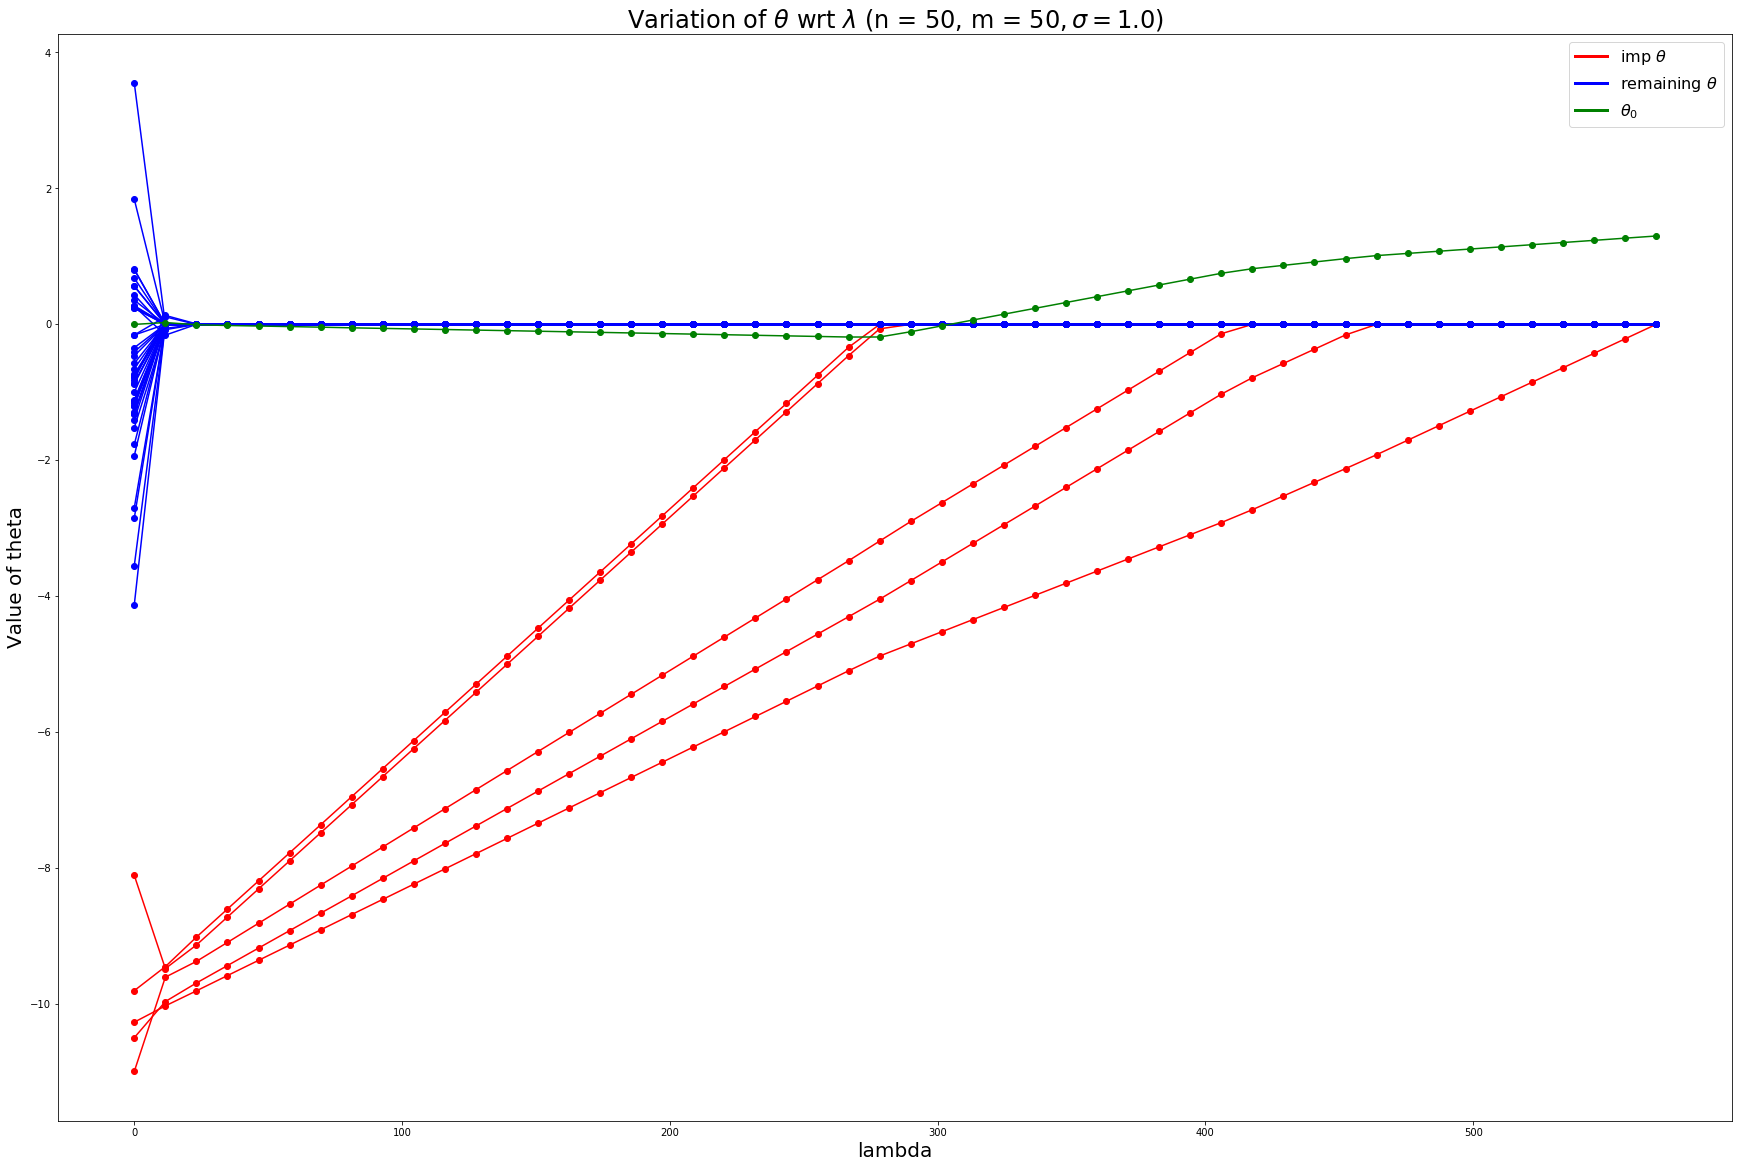

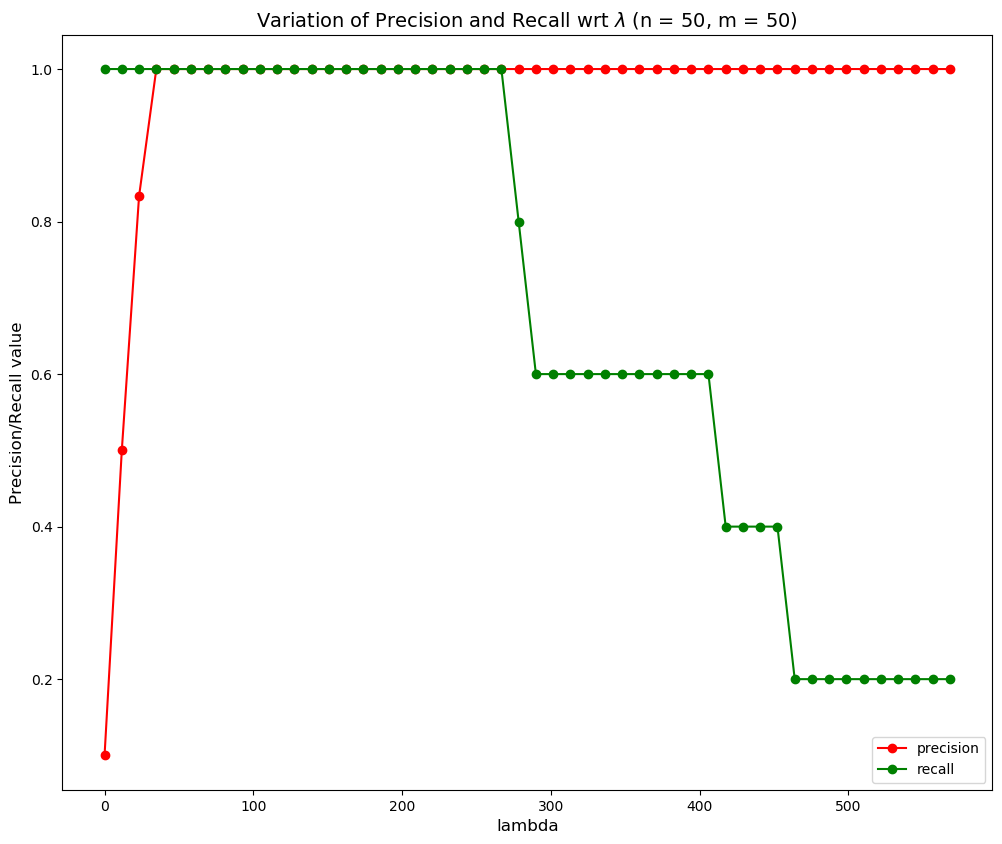

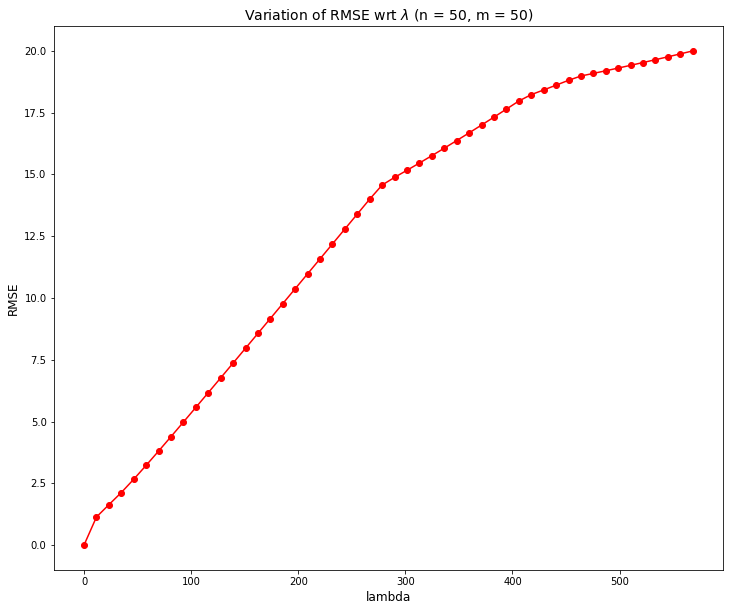

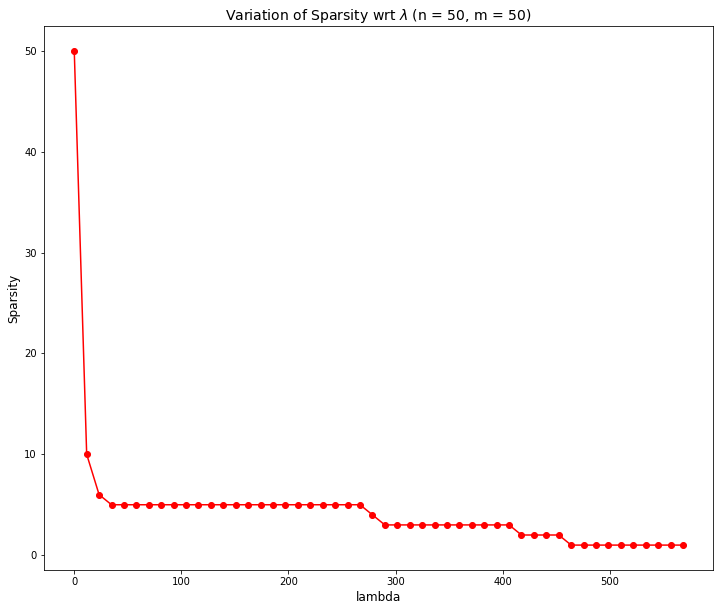

Lambda max 153.97767
Set of Lambdas [  0.           3.1424014    6.28480279   9.42720419  12.56960558
  15.71200698  18.85440837  21.99680977  25.13921116  28.28161256
  31.42401395  34.56641535  37.70881675  40.85121814  43.99361954
  47.13602093  50.27842233  53.42082372  56.56322512  59.70562651
  62.84802791  65.9904293   69.1328307   72.27523209  75.41763349
  78.56003489  81.70243628  84.84483768  87.98723907  91.12964047
  94.27204186  97.41444326 100.55684465 103.69924605 106.84164744
 109.98404884 113.12645024 116.26885163 119.41125303 122.55365442
 125.69605582 128.83845721 131.98085861 135.12326    138.2656614
 141.40806279 144.55046419 147.69286559 150.83526698 153.97766838]
Sparsity: [1000, 13, 9, 9, 9, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
For lambda 0.00000, precision = 0.01, recall = 1.00
For lambda 3.14240, precision = 0.00, recall = 0.00
For lambda 6.28480, precision = 0.0

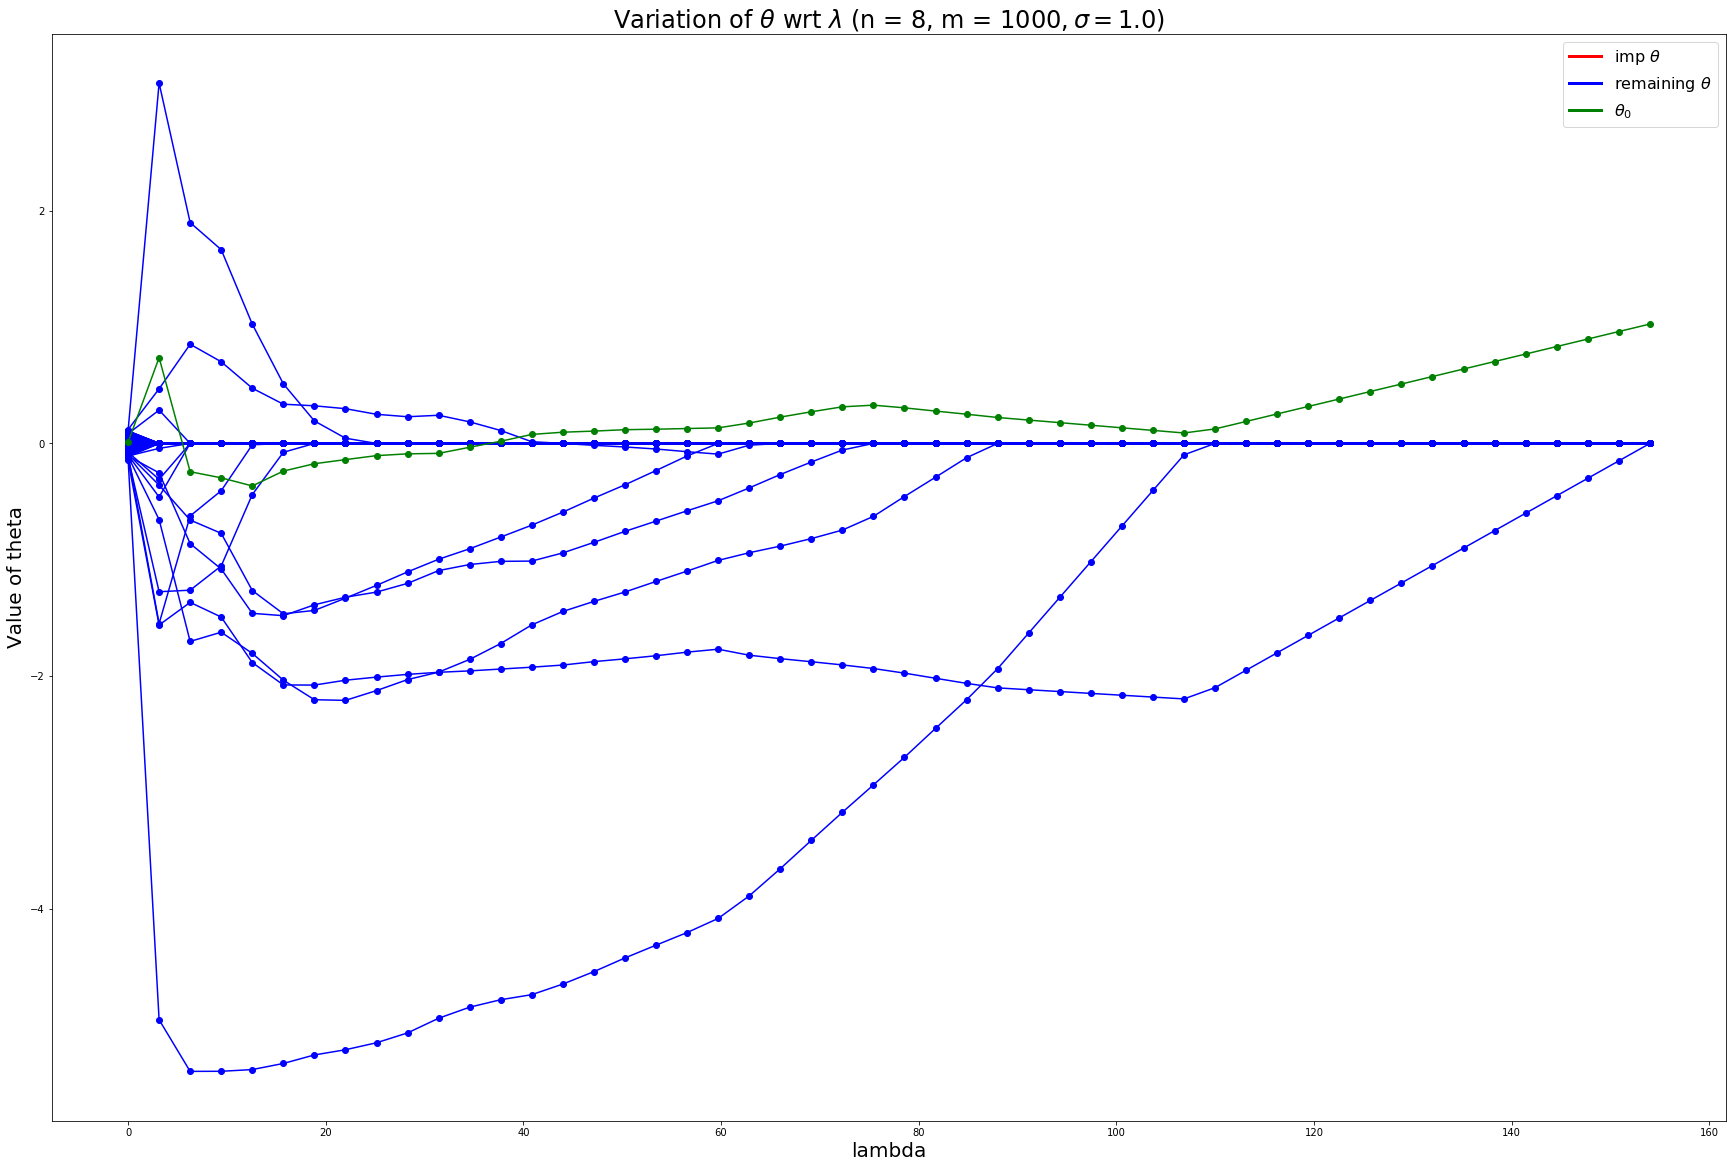

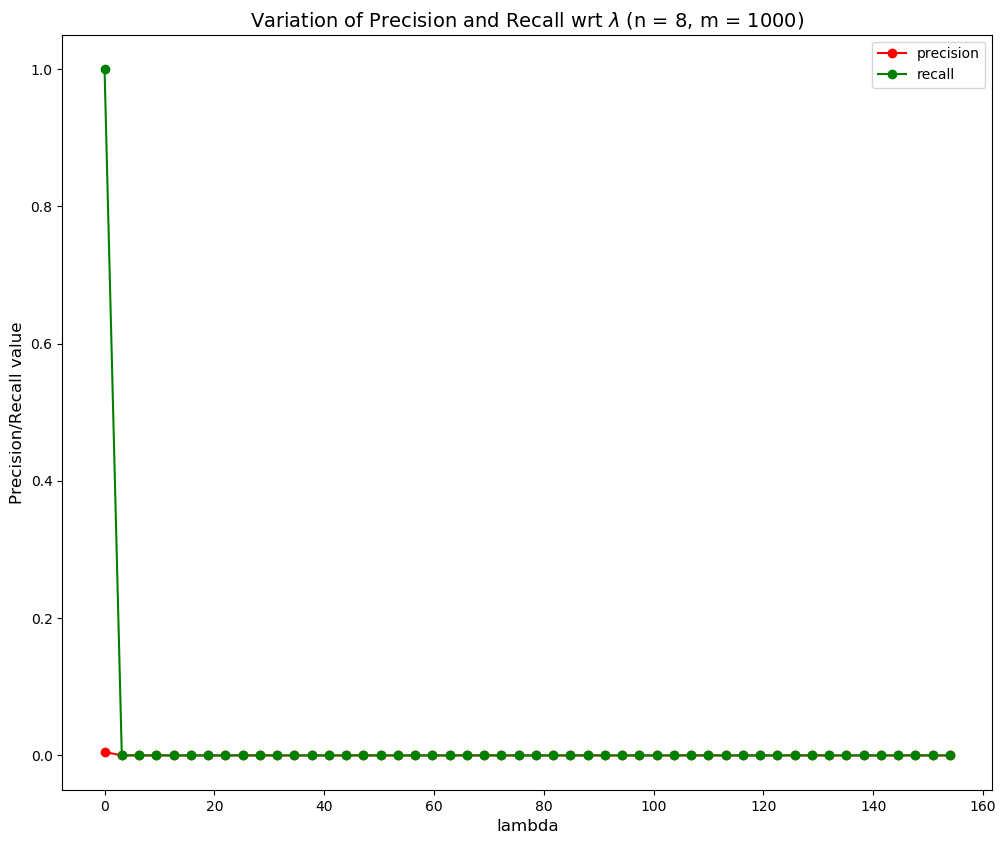

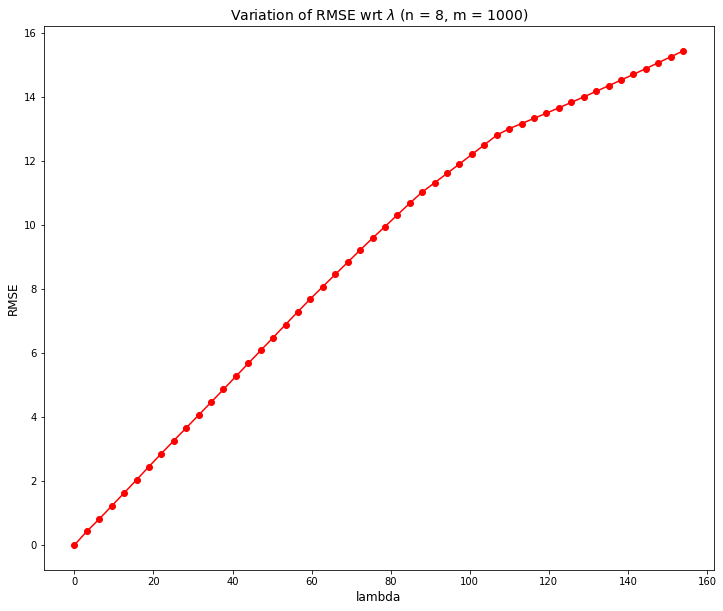

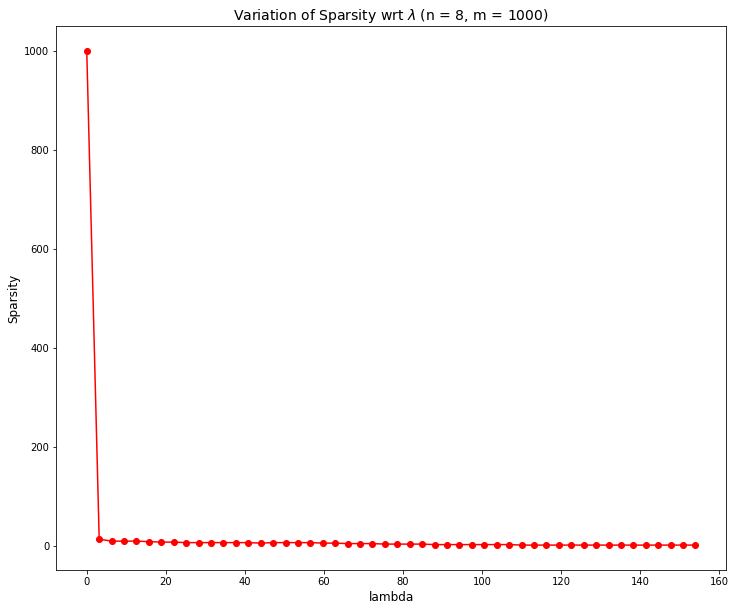

In [205]:
# Problem 2.4
# TODO: trying to find empirically the lasso sample complexity

n_d_values = [(100,10), (620,25), (50,50), (8,1000)]

for n_d in n_d_values:
    n, d = n_d[0], n_d[1]
    X, y, w_true, w0_true = DataGenerator(n, d, k=5, sigma=1.0)
    Aggregate(X, y, w_true, w0_true, print_pr=True)


In [215]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [216]:
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    
    #########TODO##########
    a = (np.sum(X.power(2), axis=0)).reshape(-1,1)  # a[k] denotes a_k as in defn
    n, m = X.shape
    
    not_stop = True
    iter_count = 0
    
    w, w0 = Initialw(X, y)
    prev_w = np.copy(w)
    prev_w0 = w0
    time_taken = []
    iterations = []
    F_w_w0 = []
    F_w_w0.append(0.5*np.sum(np.square(y - (X.dot(w)+w0))) + lmda*np.sum(abs(w)))

    for i in range(max_iter):
        start_time = time.time()
        for k in range(m+1):
            w_copy = np.copy(w)
            if k == 0:
                r_k = y - X.dot(w_copy)
                c_k = np.dot(r_k, np.ones(n))
                w0 = c_k/(n)
            else:   
                w_copy[k-1] = 0
                r_k = y - (X.dot(w_copy)+w0)
                c_k = (np.dot(r_k, X[:,k-1].todense())).reshape(-1,1)
                if c_k < -lmda:
                    w[k-1] = (c_k + lmda)/a[k-1]
                elif c_k > lmda:
                    w[k-1] = (c_k - lmda)/a[k-1]
                else:
                    w[k-1] = 0

        F_w = 0.5*np.sum(np.square(y - (X.dot(w)+w0))) + lmda*np.sum(abs(w))
        print (F_w, i)
        iterations.append(i)
        F_w_w0.append(F_w)

        if max(np.max(np.abs(w - prev_w)), np.abs(w0 - prev_w0)) <= epsilon:
            break;

        prev_w = np.copy(w)
        prev_w0 = w0
        time_taken.append(time.time()-start_time)
        
    if draw_curve:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(F_w_w0)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    return (w,w0)

In [217]:
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):

    lambda_max = np.max(np.abs(X.T.dot(y - np.mean(y))))
    print ("Lambda max: %.7f"%lambda_max)
    lambda_min = 0.05 * lambda_max
    Lmda = np.linspace(lambda_min, lambda_max, 20)
    num_lmda = len(Lmda)
    n, m = X.shape
    
    W = np.zeros((num_lmda, m))
    W0 = np.zeros(num_lmda)
    for (i,lmda) in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(X, y, lmda, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
        W[i, :] = w_lasso
        W0[i] = w0_lasso
        print (f"Lambda = {lmda} done......")
        
    return (W, W0, Lmda)

In [218]:
def evaluate_rmse(X, y, w, w0):
    pred = X.dot(w) + w0
    rmse = root_mean_square_error(pred, y)
    return rmse

In [220]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    
    W, W0, Lmda = LassoPath(X_train, y_train)
    
    best_rmse = np.inf
    for i, lmda in enumerate(Lmda):
        rmse = evaluate_rmse(X_valid, y_valid, W[i,:], W0[i])
        if rmse < best_rmse:
            best_rmse = rmse
            lmda_best = lmda
            w_lasso = W[i,:]
            w0_lasso = W0[i]
            
    n,m = X_train.shape
    fig, ax = plt.subplots(figsize=(30, 20), dpi=300)
    for i in range(m):
        plt.plot(Lmda, W[:,i], c='red', label=str(i+1), marker='o')
    plt.plot(Lmda, W0, c='green', label='0', marker='o')
    colors = ['red', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = [r'$\theta$', r'$\theta_{0}$']
    plt.legend(lines, labels, fontsize=16)
    plt.xlabel('lambda', fontsize=20)
    plt.ylabel('Value of theta', fontsize=20)
    plt.title(r'Variation of $\theta$ wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=24)
    plt.show()
    
    train_rmses = []
    validation_rmses = []
    for i,lmda in enumerate(Lmda):
        train_rmses.append(evaluate_rmse(X_train, y_train, W[i,:], W0[i]))
        validation_rmses.append(evaluate_rmse(X_valid, y_valid, W[i,:], W0[i]))
    fig, ax = plt.subplots(figsize=(30, 20),dpi=200)    
    plt.plot(Lmda, train_rmses, c='red', label='0', marker='o')
    plt.plot(Lmda, validation_rmses, c='green', label='0', marker='o')

    colors = ['red', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = [r'Train RMSE', r'Validation RMSE']
    plt.legend(lines, labels, fontsize=16)
    plt.xlabel('lambda', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)
    plt.title(r'Variation of RMSE wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=24)
    plt.show()
        
    return (w_lasso, w0_lasso, lmda_best)

In [221]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)

Lambda max: 39.5782540
21298.18881963706 0
20752.87738897066 1
20500.455516648406 2
20294.588573644774 3
20130.54727433846 4
19998.84752348697 5
19875.272748912186 6
19760.410199832564 7
19646.449419074303 8
19560.71907070142 9
19477.51494875655 10
19395.223665765137 11
19313.356805262832 12
19232.27535858255 13
19153.07717712008 14
19087.860917968104 15
19023.83954529732 16
18961.2505988097 17
18900.696611754945 18
18840.060077688802 19
18779.714627397218 20
18719.92570462186 21
18659.526193358273 22
18598.522585770363 23
18542.816371343506 24
18498.72905002586 25
18454.638010557985 26
18411.953130767215 27
18369.68072091203 28
18334.64451087607 29
18301.843094365468 30
18269.502047324524 31
18237.448437524425 32
18205.590792074112 33
18174.017355662712 34
18142.648642721837 35
18110.80949766427 36
18076.336851076358 37
18042.450014025624 38
18009.917209175546 39
17978.66577421914 40
17947.645400011457 41
17916.776818496633 42
17886.01674251785 43
17855.335823698075 44
17824.771718596

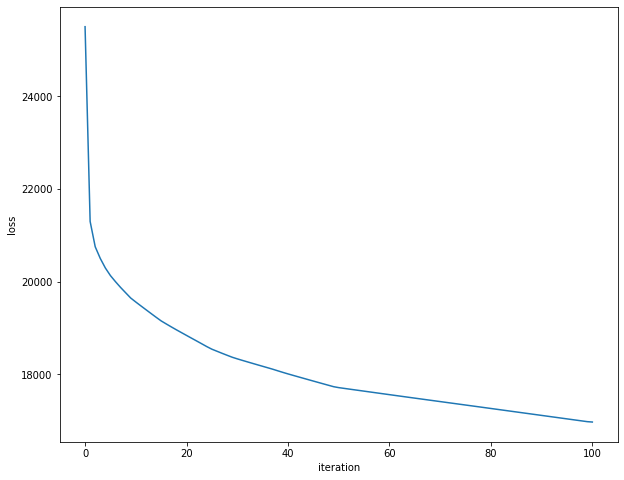

Lambda = 1.9789127006824145 done......
26925.946212747578 0
25836.97895761596 1
25205.964754780267 2
24734.073308752122 3
24330.245439588885 4
23991.976576774934 5
23651.450449944652 6
23360.858574279897 7
23112.898396429773 8
22868.07455935138 9
22624.903435266802 10
22378.908296525944 11
22183.749407592506 12
22002.11795803658 13
21833.12301633429 14
21682.062346244922 15
21525.70207260816 16
21407.617137195746 17
21280.753447680763 18
21155.040666402037 19
21029.915829643982 20
20905.340525749765 21
20782.311537565656 22
20659.400208638614 23
20564.293005098178 24
20501.807694375533 25
20439.754186760547 26
20377.955547191355 27
20316.34042578368 28
20254.834507303516 29
20193.456872122886 30
20132.242149519305 31
20071.167774188398 32
20010.215959263864 33
19949.370023327116 34
19888.621472462022 35
19827.94968832474 36
19767.34559055818 37
19706.53520255418 38
19645.701499364797 39
19584.88116222506 40
19524.075133737493 41
19463.286761519532 42
19402.51765026802 43
19341.76764242

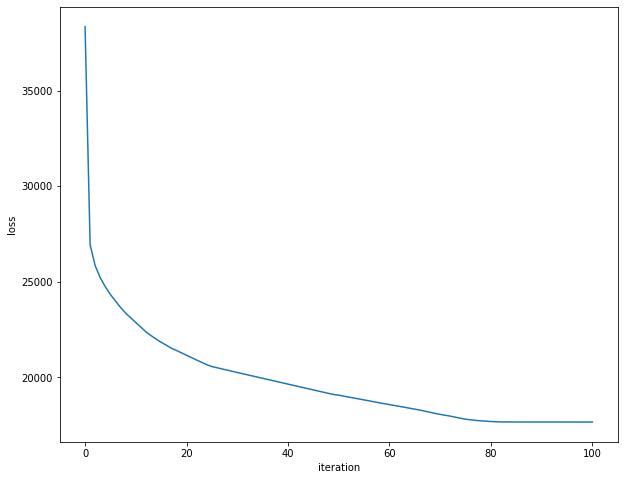

Lambda = 3.957825401364829 done......
31820.46018297958 0
30004.849660598782 1
28952.619603933003 2
28184.62067525721 3
27429.144461962293 4
26858.382700261798 5
26308.871407425424 6
25760.557820524555 7
25346.46174701235 8
24949.68128864882 9
24613.415923481196 10
24265.45011207279 11
23984.073581682904 12
23704.305046250665 13
23425.7069390462 14
23147.474461732178 15
22962.033918482375 16
22821.29124771942 17
22680.888398604915 18
22540.57467019139 19
22400.28547896978 20
22260.132874572766 21
22120.493773597293 22
21981.31128803338 23
21842.498079660174 24
21703.543187218213 25
21564.666038563166 26
21425.954396093694 27
21287.374969278164 28
21148.908402524343 29
21010.536654893498 30
20872.243959185893 31
20787.974541994397 32
20668.69391634495 33
20555.89278087062 34
20441.68750138665 35
20326.287882688102 36
20209.732426868224 37
20098.52609628119 38
19989.909858247607 39
19881.1364833485 40
19771.816337873293 41
19651.86957819645 42
19523.912285064736 43
19395.81984343602 44
1

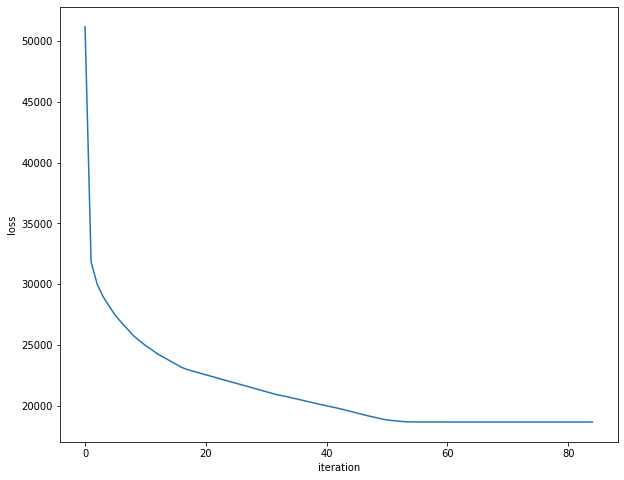

Lambda = 5.936738102047244 done......
36153.08970781597 0
33628.119389715124 1
32178.991968820774 2
30901.90025861596 3
29916.91834411685 4
28972.345636411163 5
28240.87920481738 6
27591.111242804054 7
26937.344085871257 8
26440.11317084456 9
25944.66915819033 10
25449.07503334528 11
25140.437974227832 12
24890.183402320687 13
24640.700060900723 14
24391.63140828987 15
24142.950700920574 16
23894.912261132686 17
23647.677807905427 18
23399.88307173453 19
23152.302254781505 20
22904.901872867445 21
22657.65041343651 22
22410.507396980953 23
22262.191287626323 24
22043.237758609634 25
21837.076174322523 26
21628.720298688117 27
21423.17349524753 28
21226.20798747935 29
21030.77590809571 30
20808.823612109765 31
20586.625322465403 32
20362.96348759176 33
20136.579858197383 34
19934.84898336075 35
19737.631343113095 36
19619.175046299926 37
19531.05230906749 38
19464.943034255197 39
19449.35805994385 40
19445.75928623239 41
19444.001914047403 42
19442.97285350528 43
19442.40833404913 44
19

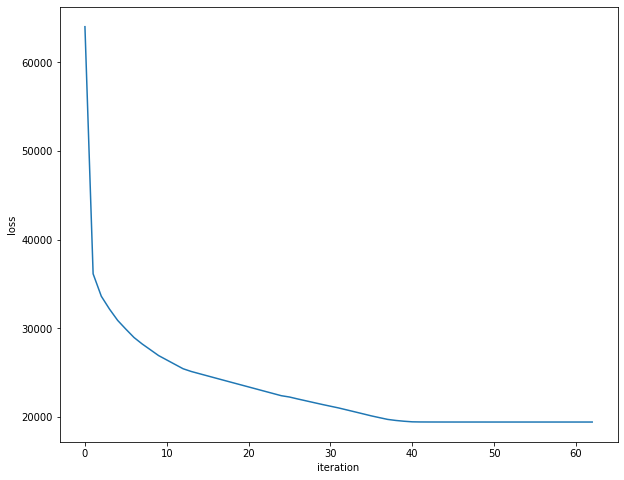

Lambda = 7.915650802729658 done......
40047.86109788878 0
36863.449063760665 1
34779.70150231323 2
33200.49925796998 3
31821.936509988347 4
30691.901803446606 5
29736.31858560542 6
28855.38120989479 7
28086.165150838304 8
27397.28840813492 9
27008.581083113793 10
26621.18876074316 11
26234.886584881126 12
25849.464139251308 13
25464.39730156783 14
25078.362367418846 15
24691.536785998735 16
24304.947674219977 17
23918.529920229117 18
23597.113612737732 19
23335.174597040324 20
23008.83396292525 21
22679.089074848336 22
22364.95572855352 23
22036.68705021079 24
21690.615062558583 25
21341.830899624474 26
20988.20619597567 27
20666.952092434778 28
20371.121632053793 29
20244.784877460457 30
20120.06561778392 31
20088.099029258992 32
20082.278081955155 33
20079.85946943535 34
20078.768879054252 35
20078.24699980801 36
20077.993024594944 37
20077.8403477149 38
20077.716620526786 39
20077.61185704741 40
20077.534392469894 41
20077.486052784996 42
20077.460155233406 43
20077.44767982136 44
2

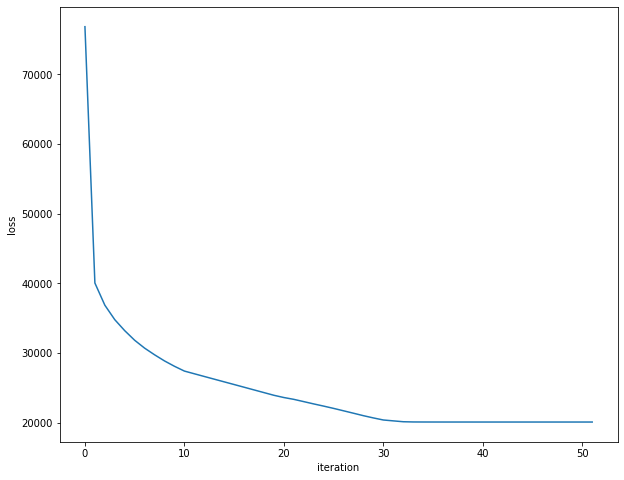

Lambda = 9.894563503412073 done......
43604.43156679149 0
39749.10738041383 1
37081.00589849168 2
35000.5212526173 3
33370.07094837896 4
32003.571551471618 5
30788.59932328215 6
29683.556015119713 7
29047.89910517627 8
28493.397385689423 9
27939.423646207662 10
27386.195225487427 11
26832.753260167985 12
26277.29735443961 13
25720.9526576779 14
25163.613126560616 15
24746.565310492406 16
24322.99655755121 17
23847.064109535568 18
23384.292449385088 19
22895.168239729748 20
22399.77936344644 21
21898.138332714887 22
21410.62761399513 23
20979.042767042047 24
20784.288115667357 25
20627.30231694579 26
20602.293602338472 27
20596.86145064357 28
20594.865673432152 29
20594.115598940974 30
20593.77766823961 31
20593.589752439064 32
20593.451724866503 33
20593.34461282332 34
20593.27225625349 35
20593.23117554661 36
20593.211160687442 37
20593.202514849974 38
20593.199028744573 39
20593.19762335654 40
20593.197011002434 41
20593.1966884866 42
20593.196460771385 43
20593.19626465612 44
20593.

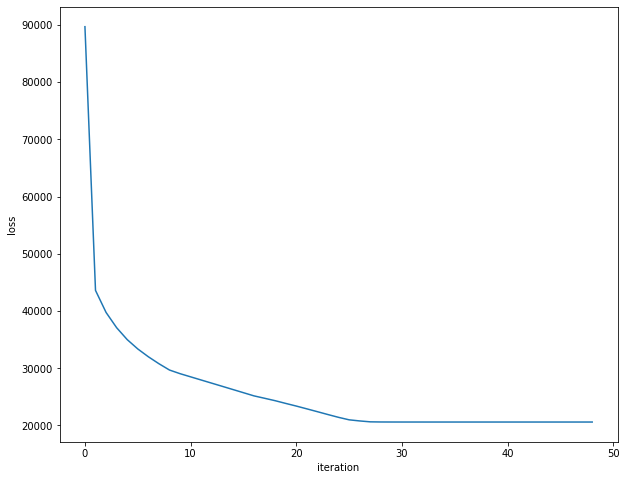

Lambda = 11.873476204094487 done......
46854.539311120374 0
42198.89445083416 1
38944.89132408252 2
36558.89792393621 3
34612.819528550164 4
32915.865365424776 5
31429.771503717442 6
30685.612916886203 7
29940.40300797557 8
29191.94056283657 9
28440.681747449602 10
27686.125821976137 11
26929.781499448538 12
26171.89981231511 13
25761.37927848613 14
25103.542692494855 15
24450.52333818844 16
23789.43699761472 17
23110.799081810677 18
22421.741645452134 19
21781.025339734748 20
21282.339532956586 21
21092.64281310551 22
21022.078355846843 23
21013.666803179807 24
21011.41591829972 25
21010.60038100335 26
21010.225619720048 27
21009.993550255957 28
21009.823600932395 29
21009.704947598308 30
21009.634800243875 31
21009.599765323455 32
21009.584611519866 33
21009.578738239397 34
21009.57660597139 35
21009.575820752172 36
21009.575469340758 37
21009.575239418144 38
21009.575047926577 39
21009.574889482847 40
21009.574772231394 41
21009.57469608343 42


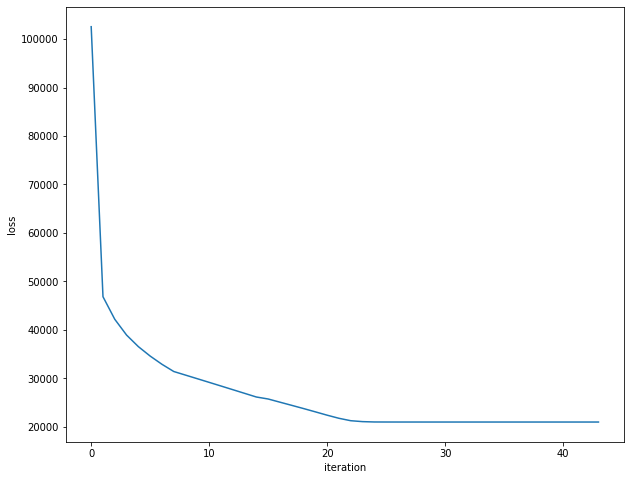

Lambda = 13.852388904776902 done......
49858.13416619519 0
44402.591445157814 1
40643.78201763236 2
37805.73622966002 3
35445.44671346471 4
33488.818348715635 5
32405.928150943917 6
31432.233526170377 7
30457.428937791283 8
29475.887842041113 9
28490.520463043842 10
27503.02254985348 11
26748.921193373993 12
26010.671550762723 13
25152.016360155725 14
24276.362511527812 15
23388.168211828357 16
22504.568886012432 17
21747.88582273801 18
21469.723663968554 19
21354.35964591429 20
21345.252999003882 21
21343.45251708156 22
21342.837621847364 23
21342.566897878773 24
21342.39697500432 25
21342.277490791977 26
21342.203286961187 27
21342.163542656286 28
21342.144508889978 29
21342.136017946134 30
21342.132272976443 31
21342.13047898758 32
21342.12947276613 33
21342.128829431458 34
21342.12839938983 35
21342.12811806328 36
21342.127942532486 37
21342.127837964188 38
21342.127777752223 39


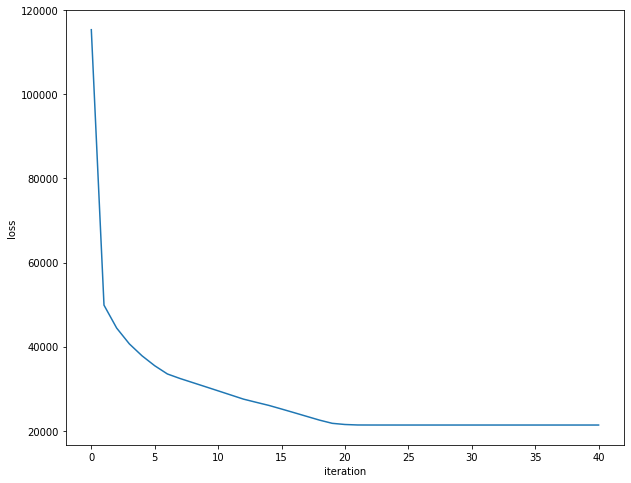

Lambda = 15.831301605459316 done......
52614.04998062263 0
46449.1955952406 1
42141.72688043982 2
38835.73440032515 3
36090.332518717696 4
34325.43634217511 5
33095.917845465505 6
31863.65558514634 7
30625.91532521437 8
29378.789548626788 9
28130.161290698125 10
27492.099313067873 11
26389.018299601856 12
25276.48454597682 13
24141.628970638514 14
23008.182493832024 15
22043.895808652807 16
21722.672883650273 17
21613.71928323803 18
21607.41723228681 19
21605.9511350741 20
21605.449695187548 21
21605.199391093138 22
21605.042233897966 23
21604.94737392773 24
21604.89545026385 25
21604.86903666114 26
21604.85599490321 27
21604.84940485669 28
21604.845848464996 29
21604.843786784066 30
21604.84253677626 31
21604.84176873113 32
21604.841299743475 33
21604.84101710927 34
21604.840848864103 35
21604.840749515384 36
21604.84069104376 37


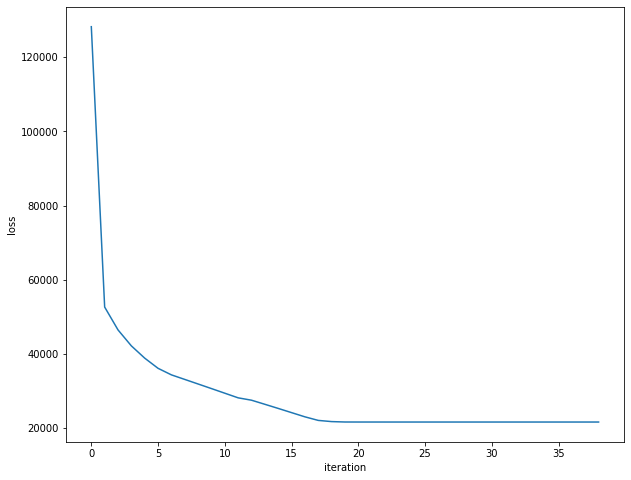

Lambda = 17.81021430614173 done......
55352.756127877394 0
48200.61769279049 1
43281.17741935721 2
39489.66279241357 3
36559.20125363786 4
35046.696238848985 5
33527.40489262012 6
32002.503275084142 7
30467.789756568993 8
28935.335090888584 9
28138.436198656782 10
26765.435592539063 11
25371.657279243598 12
23958.228149563212 13
22650.611097503926 14
22019.85372847432 15
21825.42263838143 16
21814.661083733918 17
21812.892460791074 18
21812.349234577538 19
21812.071361811977 20
21811.8988314472 21
21811.796278304057 22
21811.739633618472 23
21811.709863632615 24
21811.694401107667 25
21811.686158884753 26
21811.681557829685 27
21811.678878707633 28
21811.677279752166 29
21811.67631799563 30
21811.675740776394 31
21811.675396347506 32
21811.675191961167 33
21811.675071122954 34
21811.6749997995 35


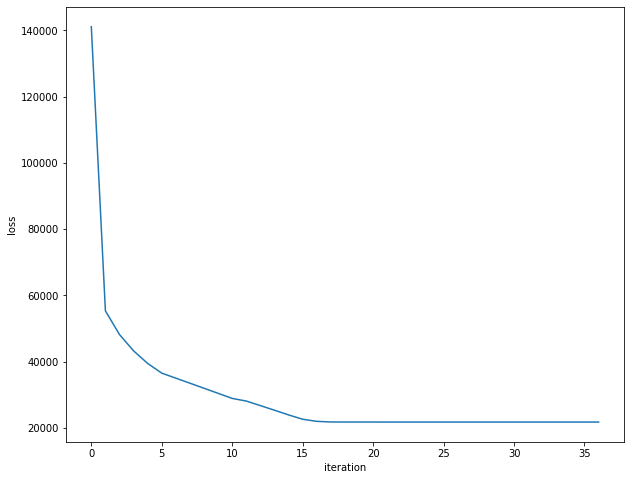

Lambda = 19.789127006824145 done......
57911.89978864943 0
49677.1039711069 1
44212.02262545223 2
40013.561766684754 3
37369.40598158575 4
35535.6165944635 5
33695.03722843022 6
31846.80238225043 7
29989.94395478001 8
29036.150940878244 9
27356.83923262933 10
25660.347505363734 11
23949.66161935521 12
22475.543591267713 13
22063.90324724482 14
21977.396613669156 15
21974.887649563654 16
21974.149014010836 17
21973.790099938782 18
21973.58278547321 19
21973.465492780637 20
21973.401166432563 21
21973.366556548717 22
21973.347840160735 23
21973.33744649506 24
21973.331483512062 25
21973.327976738798 26
21973.32588805024 27
21973.324639648916 28
21973.323894438174 29
21973.32345080424 30
21973.32318733691 31
21973.323031102995 32
21973.322938518377 33


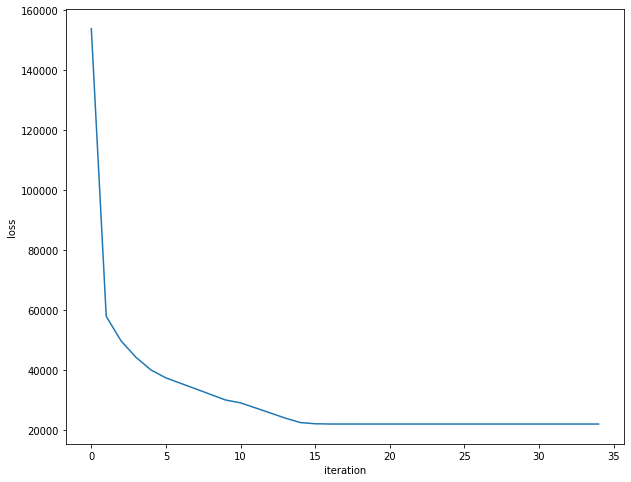

Lambda = 21.76803970750656 done......
60267.30399862975 0
51133.029622896924 1
44944.402258784656 2
40295.22366896916 3
37981.79485673636 4
35801.21872610854 5
33611.72743280037 6
31412.836289730716 7
29784.711707451606 8
28073.71867760686 9
26068.037843312835 10
24053.644095318283 11
22412.21189284521 12
22108.99037823083 13
22096.363244424247 14
22095.58361420243 15
22095.292837306974 16
22095.15296017241 17
22095.078945233134 18
22095.039040895786 19
22095.01761307616 20
22095.01084149439 21
22095.01043332849 22
22095.010333620492 23


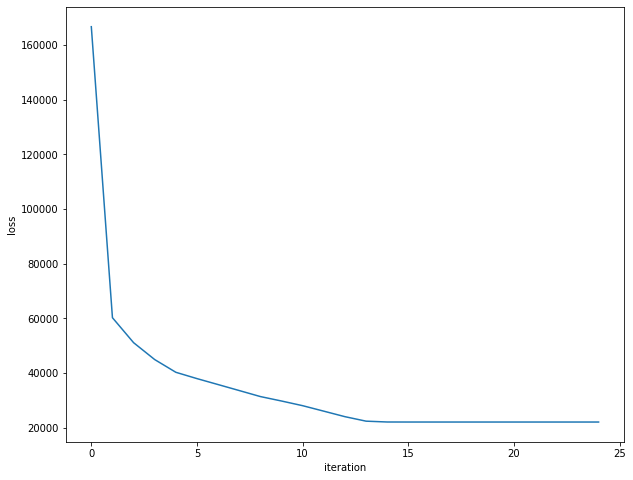

Lambda = 23.746952408188974 done......
62405.20008118157 0
52500.75777428913 1
45568.96275548741 2
40934.04686042672 3
38385.961374996725 4
35826.67456098994 5
33254.380326302635 6
30843.842829268753 7
29345.02855500691 8
26978.13637943191 9
24588.740476552797 10
22582.108594975965 11
22195.480690179513 12
22181.891428208633 13
22181.20712374333 14
22181.055076095487 15
22181.028464726864 16
22181.024963679127 17
22181.024439463272 18
22181.024305016414 19


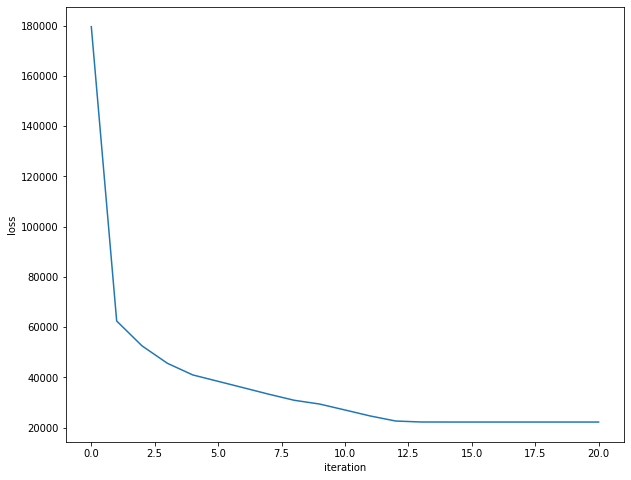

Lambda = 25.72586510887139 done......
64351.936109264934 0
53662.89441407747 1
46029.221287841974 2
41545.85680025321 3
38587.62635255126 4
35614.25244320294 5
32626.048078403997 6
30868.72042914031 7
28163.83523592696 8
25387.842979831355 9
22859.827261887393 10
22287.86844273793 11
22239.51575967537 12
22238.641626064906 13
22238.447009091433 14
22238.406023810323 15
22238.399779542517 16
22238.399073668566 17
22238.398976468037 18


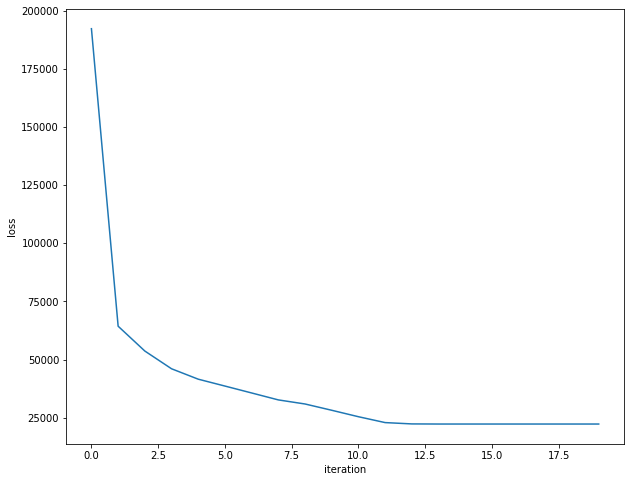

Lambda = 27.704777809553804 done......
66257.03081513516 0
54634.53349509326 1
46249.35016054151 2
42001.80217944803 3
38602.10952104101 4
35183.54340895669 5
32022.461995002577 6
29981.171744431682 7
26790.369814193386 8
23690.775525342917 9
22458.788843563852 10
22278.715920208604 11
22276.106587404047 12
22275.655973915607 13
22275.556816724406 14
22275.539453308746 15
22275.53721111463 16
22275.53698848225 17
22275.536964556555 18


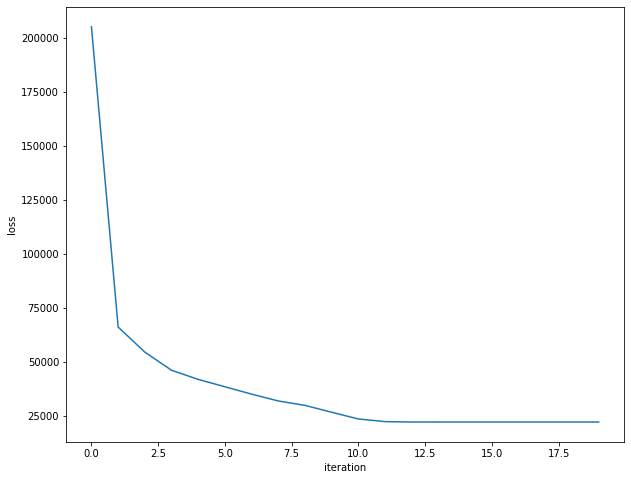

Lambda = 29.683690510236218 done......
68191.78679775463 0
55501.655380785436 1
46365.90606411261 2
42315.85645491151 3
38443.795084989964 4
34548.95174674062 5
31936.45350399999 6
28627.666432603153 7
25001.64059110278 8
22437.067210960406 9
22302.878793912965 10
22300.313445103315 11
22299.840880893247 12
22299.758734694846 13
22299.7486994619 14
22299.747815655515 15
22299.74776026499 16


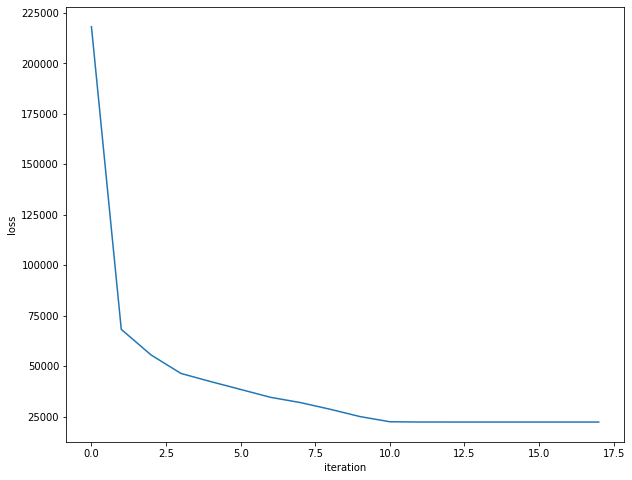

Lambda = 31.662603210918633 done......
70007.47856346569 0
56209.00056655502 1
46843.755090608414 2
42491.44414695306 3
38114.24730932551 4
33797.73793651324 5
31442.26073219265 6
27301.234128681743 7
23366.77909160254 8
22385.816864091754 9
22315.04039644481 10
22314.392262358924 11
22314.340412330577 12
22314.336264384183 13
22314.335932552945 14
22314.335906006803 15


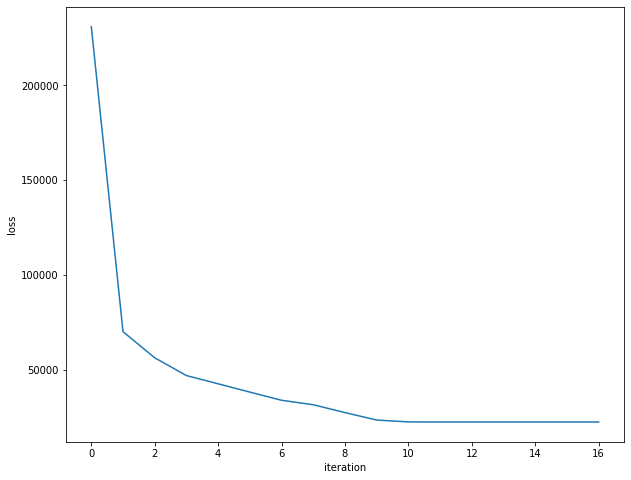

Lambda = 33.64151591160105 done......
71699.41093679862 0
56798.02464071649 1
47414.72150717979 2
42519.927518512515 3
37595.73552788089 4
33337.988869851884 5
30104.698714819555 6
25455.735090515325 7
22483.69188282301 8
22326.34204130913 9
22324.30341191031 10
22324.14032375552 11
22324.127276878902 12
22324.126233142833 13
22324.126149645075 14


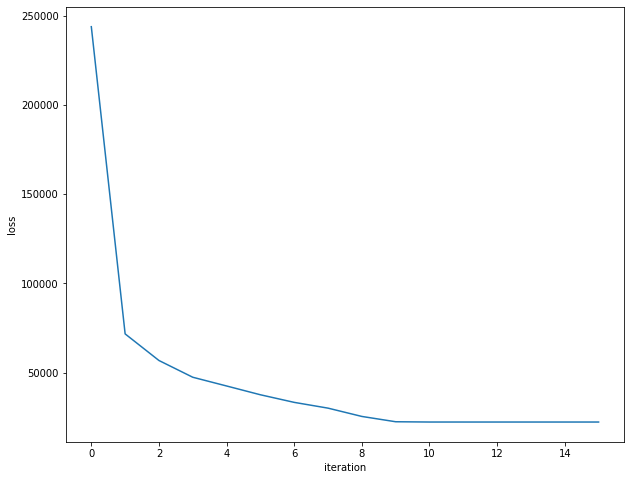

Lambda = 35.62042861228346 done......
73271.59564277099 0
57271.59218166524 1
47879.55629000519 2
42412.21747906774 3
36913.18029719283 4
33264.45453199966 5
28559.14331148443 6
23578.016900805083 7
22363.844581390076 8
22330.34139558095 9
22330.027574027285 10
22330.002468641214 11
22330.00046023738 12
22330.00029956724 13


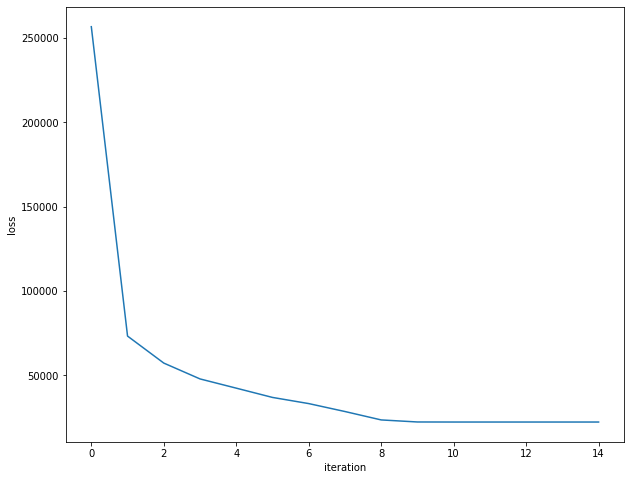

Lambda = 37.599341312965876 done......
74728.8607027367 0
57635.82720878054 1
48250.32557264099 2
42178.162982601476 3
36105.40420845627 4
32932.45648751576 5
27096.958930275112 6
22522.81192963561 7
22336.404444473254 8
22332.314017432764 9
22331.986787677954 10
22331.960609650236 11
22331.958515436232 12
22331.958347901367 13


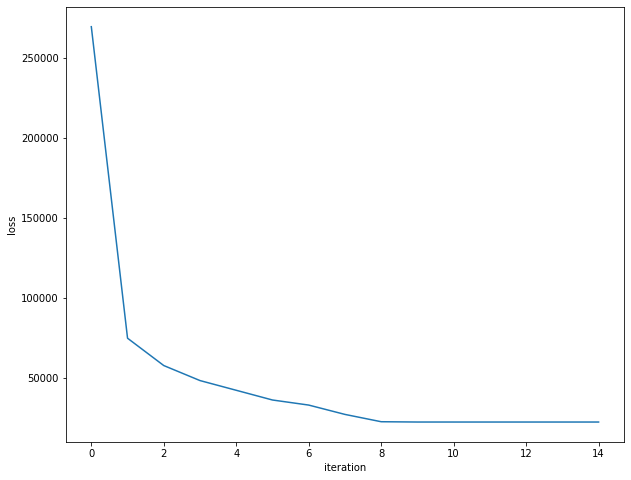

Lambda = 39.57825401364829 done......


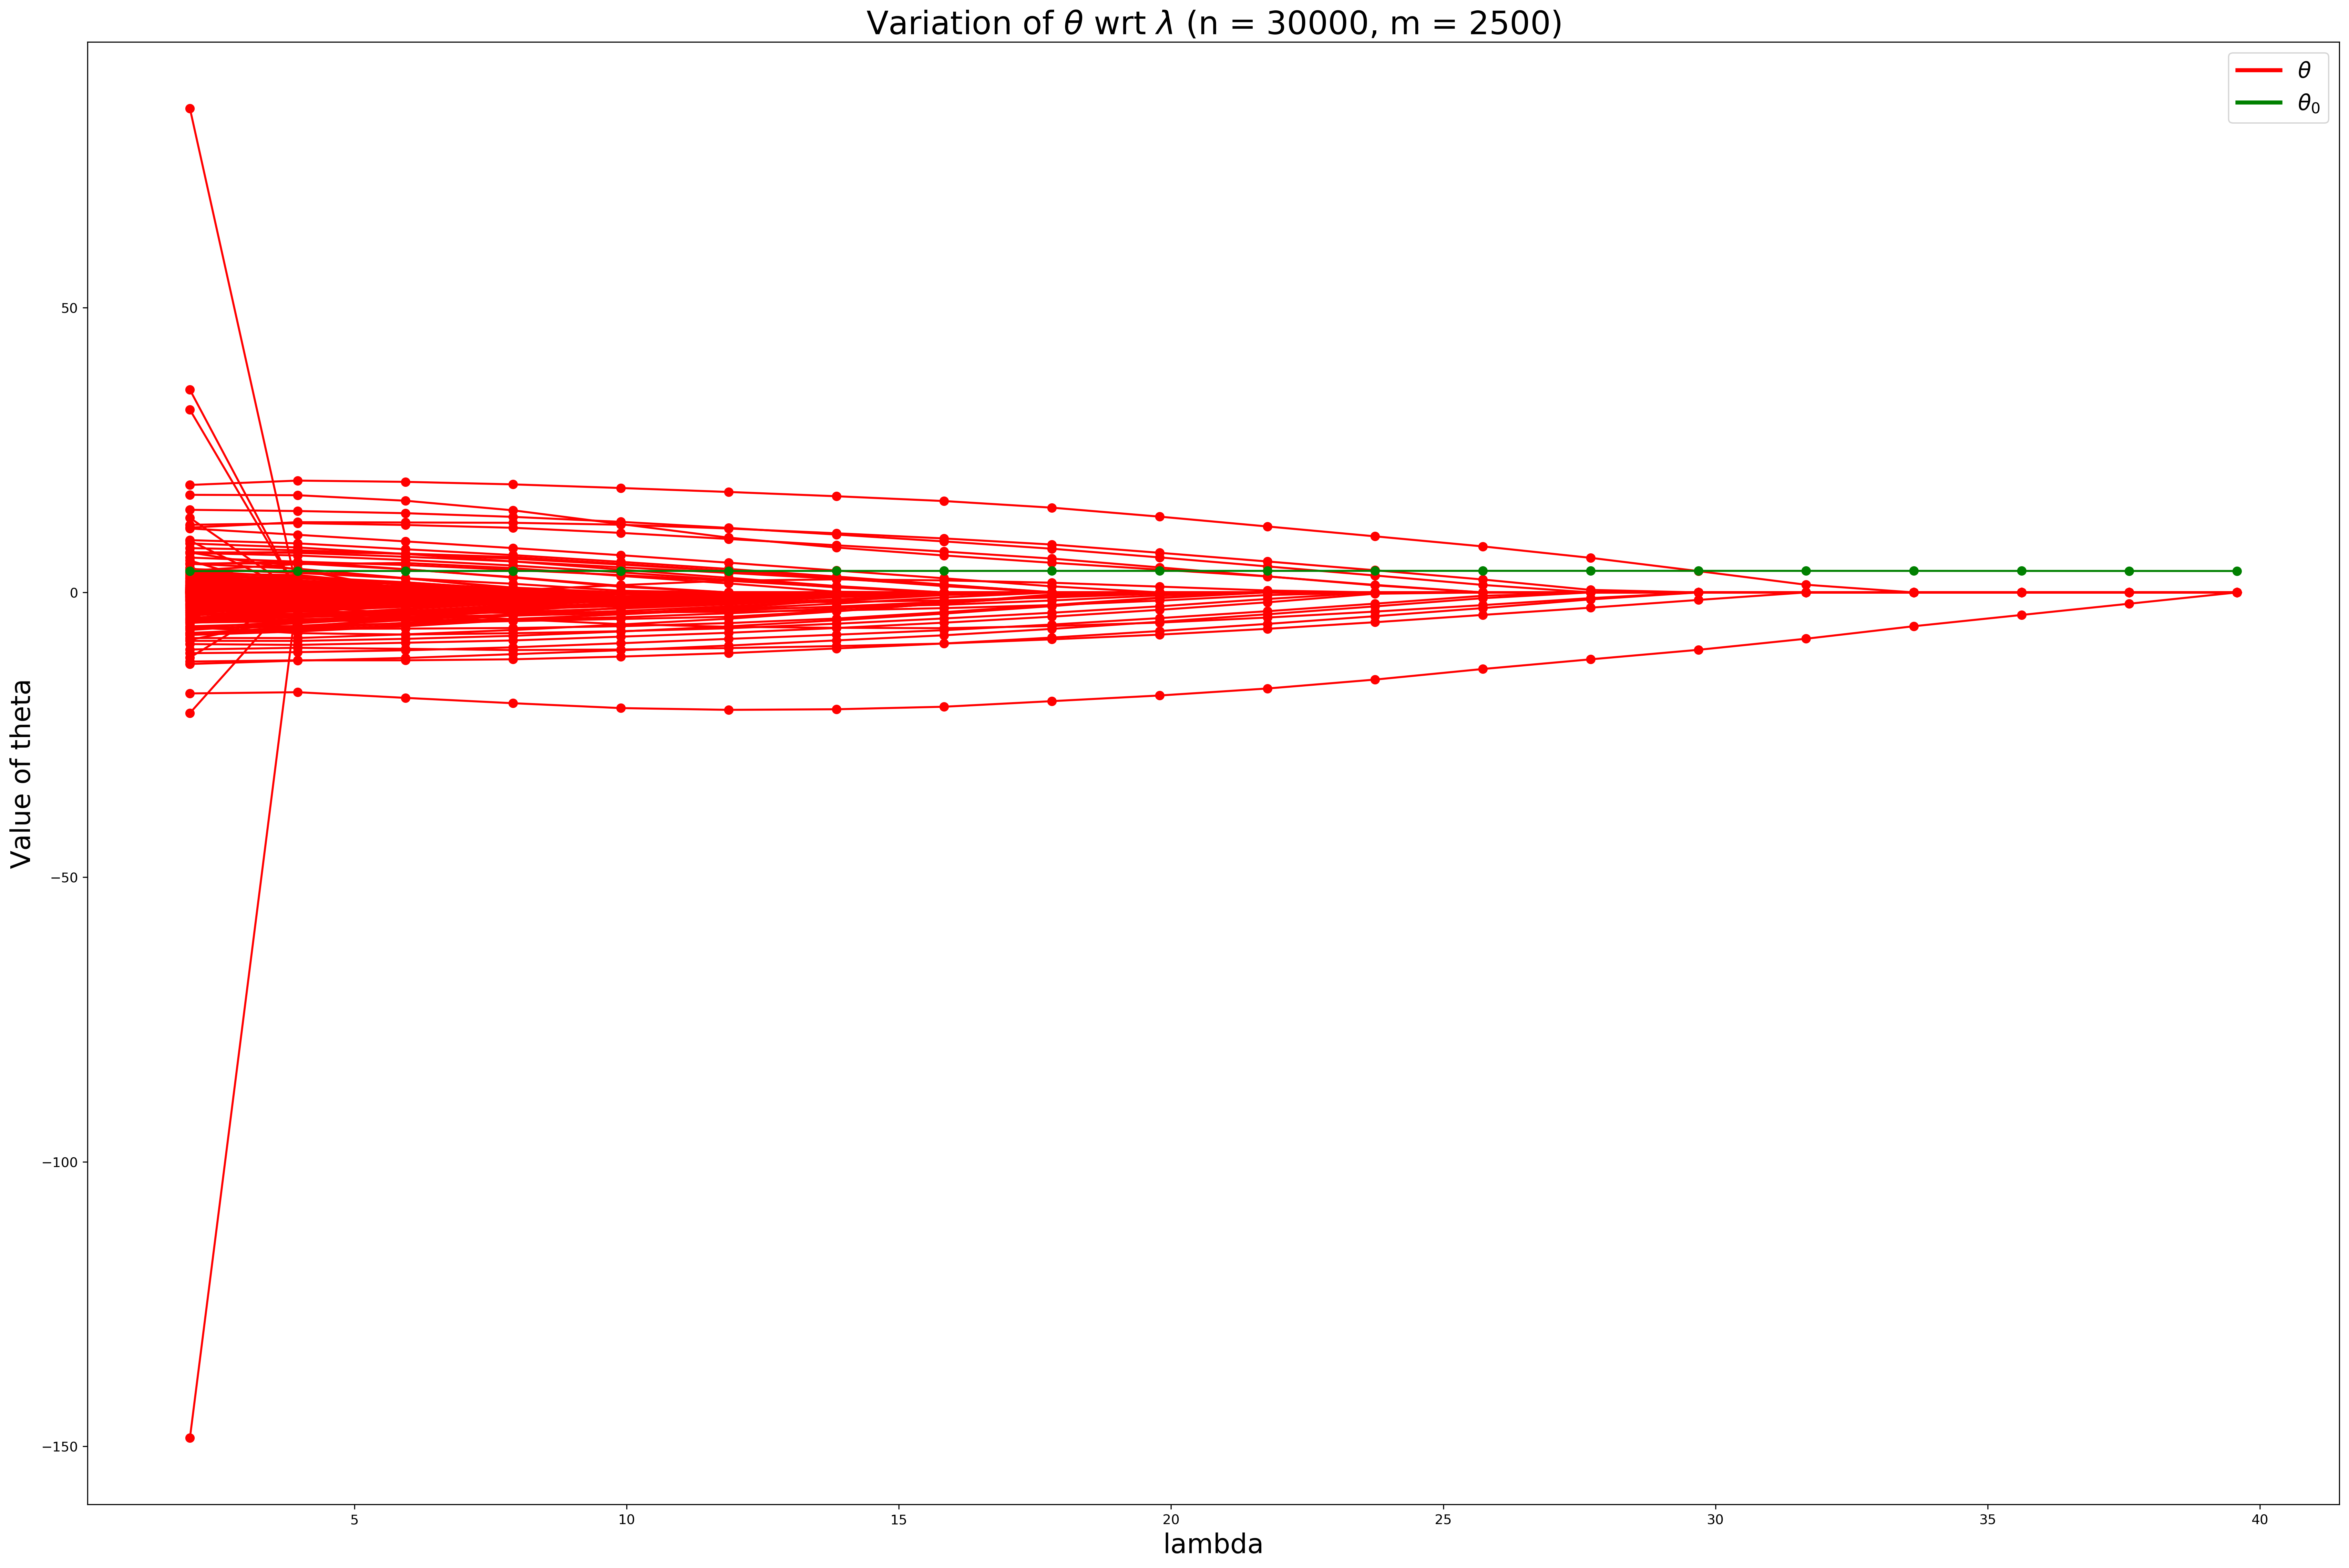

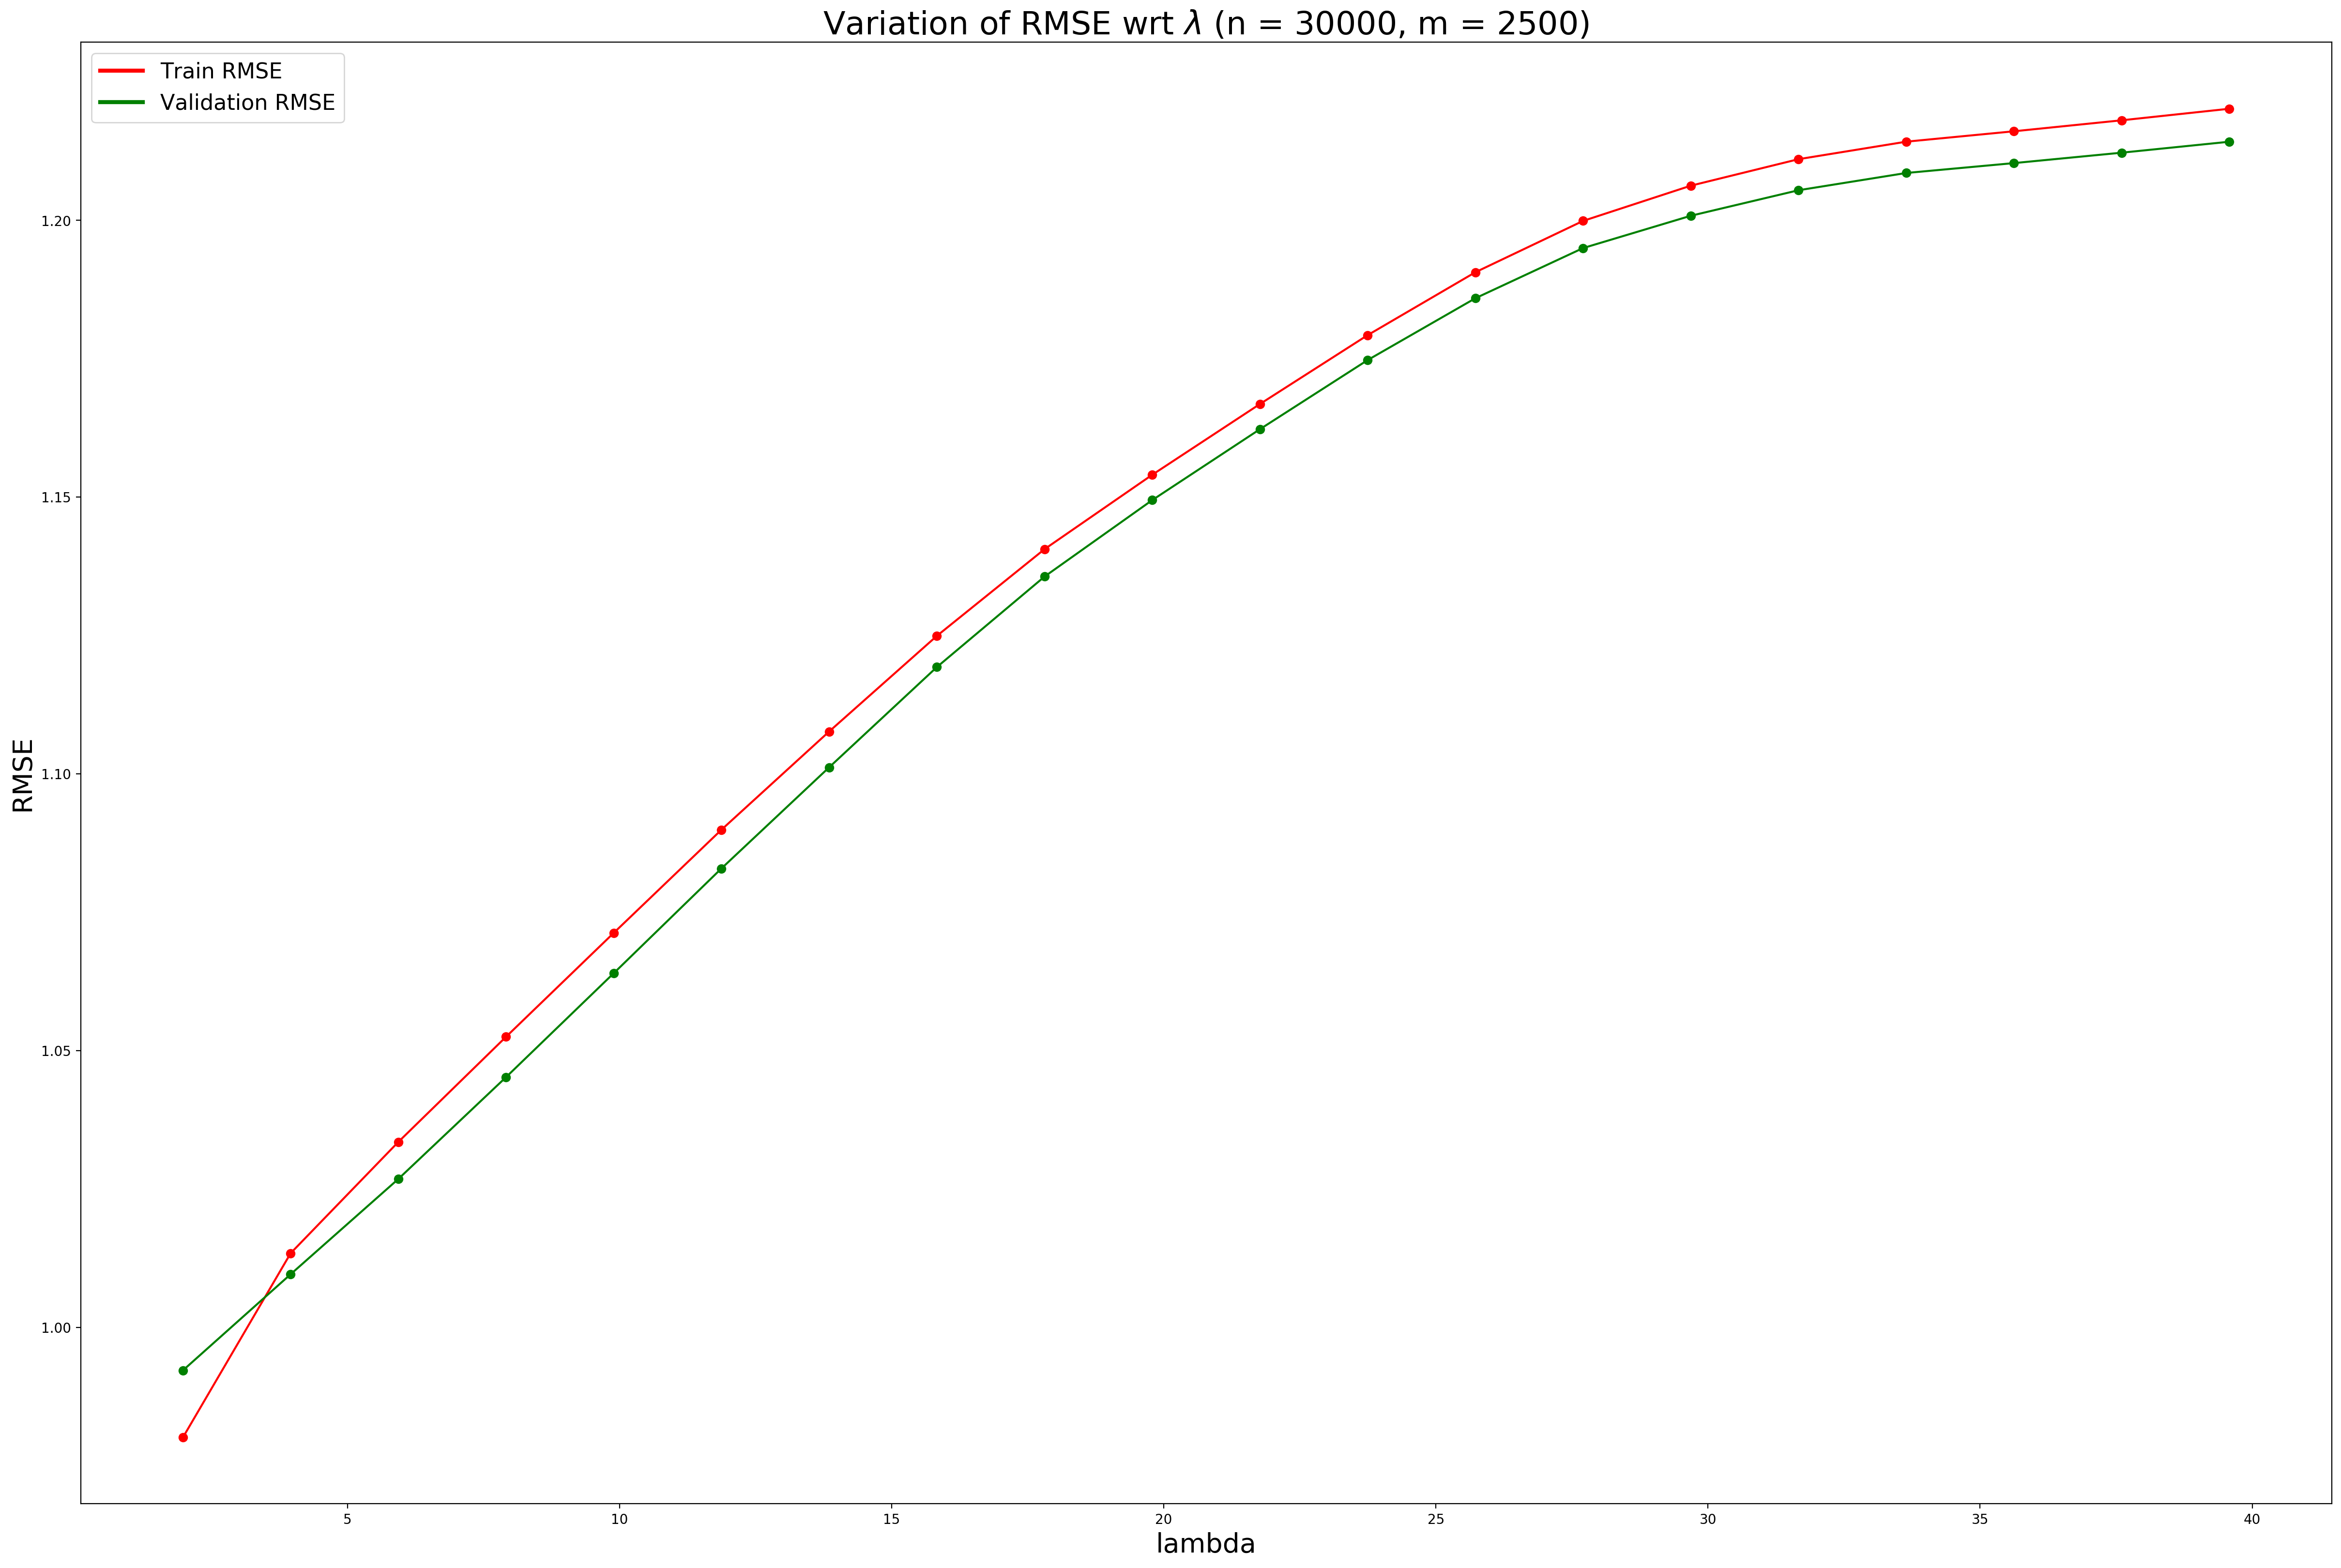

Time taken =  4541.11514210701


In [222]:
# evaluation
start_time = time.time()
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)
print ("Time taken = ", (time.time()-start_time))

In [224]:
print ("Best lambda value for which validation RMSE is smallest = %.5f"%lmda_best)
print ("Train RMSE : %.5f"%evaluate_rmse(X_train, y_train, w_lasso, w0_lasso))
print ("Validation RMSE : %.5f"%evaluate_rmse(X_valid, y_valid, w_lasso, w0_lasso))
print ("Test RMSE : %.5f"%evaluate_rmse(X_test, y_test, w_lasso, w0_lasso))

Best lambda value for which validation RMSE is smallest = 1.97891
Train RMSE : 0.98014
Validation RMSE : 0.99225
Test RMSE : 1.05320


In [225]:
# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

Lasso select features:
were soaked in -148.51253057525201
it was set 84.99399738649312
god whoever 35.58982484980407
the ####s 32.07301265597152
were -21.18998791141796
great 18.879212423873266
not -17.739962792980567
best 17.141929501582517
amazing 14.50777490156735
and 13.093322834698245


## other stuff
#### changed the return output of Validation function

In [226]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    
    W, W0, Lmda = LassoPath(X_train, y_train)
    
    best_rmse = np.inf
    for i, lmda in enumerate(Lmda):
        rmse = evaluate_rmse(X_valid, y_valid, W[i,:], W0[i])
        if rmse < best_rmse:
            best_rmse = rmse
            lmda_best = lmda
            w_lasso = W[i,:]
            w0_lasso = W0[i]
    
    return (w_lasso, w0_lasso, lmda_best, W, W0, Lmda) # modified return
    # modified return as I practically faced a situation where because of a bug in the last line of the method, I had to re-run
    # everything from scratch. So, I returned the weights array for this part of the code 

Lambda max: 39.5782540
21298.18881963706 0
20752.87738897066 1
20500.455516648406 2
20294.588573644774 3
20130.54727433846 4
19998.84752348697 5
19875.272748912186 6
19760.410199832564 7
19646.449419074303 8
19560.71907070142 9
19477.51494875655 10
19395.223665765137 11
19313.356805262832 12
19232.27535858255 13
19153.07717712008 14
19087.860917968104 15
19023.83954529732 16
18961.2505988097 17
18900.696611754945 18
18840.060077688802 19
18779.714627397218 20
18719.92570462186 21
18659.526193358273 22
18598.522585770363 23
18542.816371343506 24
18498.72905002586 25
18454.638010557985 26
18411.953130767215 27
18369.68072091203 28
18334.64451087607 29
18301.843094365468 30
18269.502047324524 31
18237.448437524425 32
18205.590792074112 33
18174.017355662712 34
18142.648642721837 35
18110.80949766427 36
18076.336851076358 37
18042.450014025624 38
18009.917209175546 39
17978.66577421914 40
17947.645400011457 41
17916.776818496633 42
17886.01674251785 43
17855.335823698075 44
17824.771718596

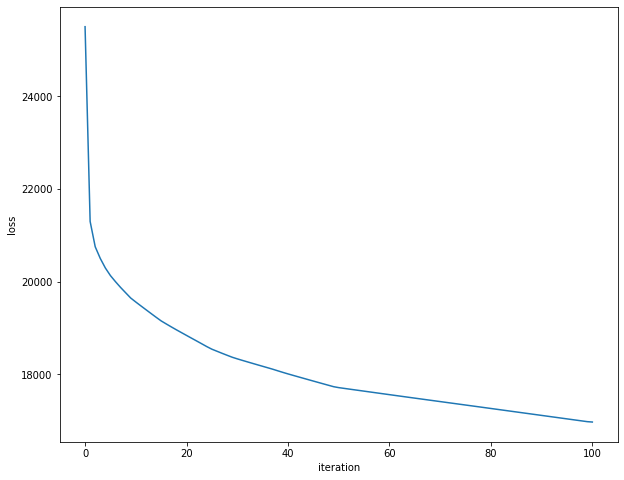

Lambda = 1.9789127006824145 done......
26925.946212747578 0
25836.97895761596 1
25205.964754780267 2
24734.073308752122 3
24330.245439588885 4
23991.976576774934 5
23651.450449944652 6
23360.858574279897 7
23112.898396429773 8
22868.07455935138 9
22624.903435266802 10
22378.908296525944 11
22183.749407592506 12
22002.11795803658 13
21833.12301633429 14
21682.062346244922 15
21525.70207260816 16
21407.617137195746 17
21280.753447680763 18
21155.040666402037 19
21029.915829643982 20
20905.340525749765 21
20782.311537565656 22
20659.400208638614 23
20564.293005098178 24
20501.807694375533 25
20439.754186760547 26
20377.955547191355 27
20316.34042578368 28
20254.834507303516 29
20193.456872122886 30
20132.242149519305 31
20071.167774188398 32
20010.215959263864 33
19949.370023327116 34
19888.621472462022 35
19827.94968832474 36
19767.34559055818 37
19706.53520255418 38
19645.701499364797 39
19584.88116222506 40
19524.075133737493 41
19463.286761519532 42
19402.51765026802 43
19341.76764242

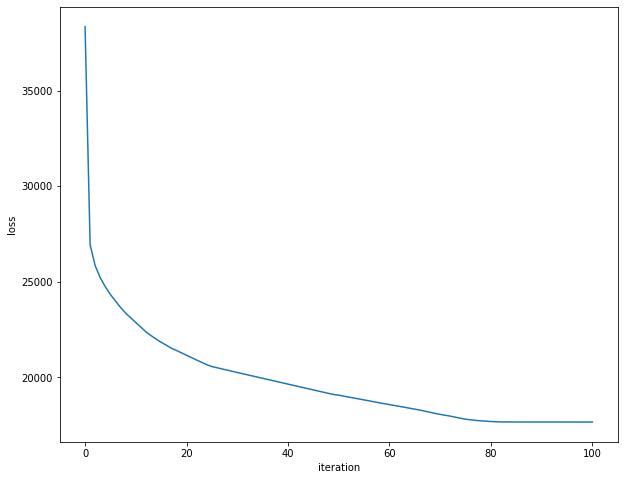

Lambda = 3.957825401364829 done......
31820.46018297958 0
30004.849660598782 1
28952.619603933003 2
28184.62067525721 3
27429.144461962293 4
26858.382700261798 5
26308.871407425424 6
25760.557820524555 7
25346.46174701235 8
24949.68128864882 9
24613.415923481196 10
24265.45011207279 11
23984.073581682904 12
23704.305046250665 13
23425.7069390462 14
23147.474461732178 15
22962.033918482375 16
22821.29124771942 17
22680.888398604915 18
22540.57467019139 19
22400.28547896978 20
22260.132874572766 21
22120.493773597293 22
21981.31128803338 23
21842.498079660174 24
21703.543187218213 25
21564.666038563166 26
21425.954396093694 27
21287.374969278164 28
21148.908402524343 29
21010.536654893498 30
20872.243959185893 31
20787.974541994397 32
20668.69391634495 33
20555.89278087062 34
20441.68750138665 35
20326.287882688102 36
20209.732426868224 37
20098.52609628119 38
19989.909858247607 39
19881.1364833485 40
19771.816337873293 41
19651.86957819645 42
19523.912285064736 43
19395.81984343602 44
1

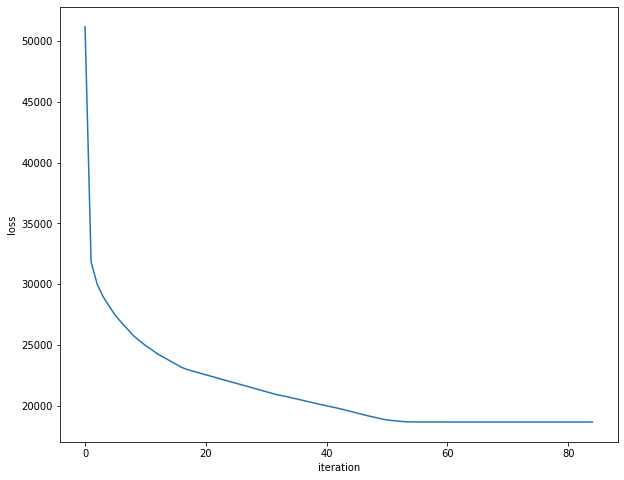

Lambda = 5.936738102047244 done......
36153.08970781597 0
33628.119389715124 1
32178.991968820774 2
30901.90025861596 3
29916.91834411685 4
28972.345636411163 5
28240.87920481738 6
27591.111242804054 7
26937.344085871257 8
26440.11317084456 9
25944.66915819033 10
25449.07503334528 11
25140.437974227832 12
24890.183402320687 13
24640.700060900723 14
24391.63140828987 15
24142.950700920574 16
23894.912261132686 17
23647.677807905427 18
23399.88307173453 19
23152.302254781505 20
22904.901872867445 21
22657.65041343651 22
22410.507396980953 23
22262.191287626323 24
22043.237758609634 25
21837.076174322523 26
21628.720298688117 27
21423.17349524753 28
21226.20798747935 29
21030.77590809571 30
20808.823612109765 31
20586.625322465403 32
20362.96348759176 33
20136.579858197383 34
19934.84898336075 35
19737.631343113095 36
19619.175046299926 37
19531.05230906749 38
19464.943034255197 39
19449.35805994385 40
19445.75928623239 41
19444.001914047403 42
19442.97285350528 43
19442.40833404913 44
19

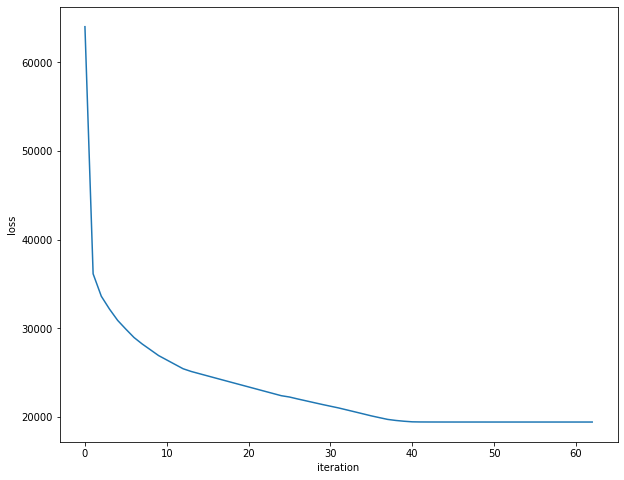

Lambda = 7.915650802729658 done......
40047.86109788878 0
36863.449063760665 1
34779.70150231323 2
33200.49925796998 3
31821.936509988347 4
30691.901803446606 5
29736.31858560542 6
28855.38120989479 7
28086.165150838304 8
27397.28840813492 9
27008.581083113793 10
26621.18876074316 11
26234.886584881126 12
25849.464139251308 13
25464.39730156783 14
25078.362367418846 15
24691.536785998735 16
24304.947674219977 17
23918.529920229117 18
23597.113612737732 19
23335.174597040324 20
23008.83396292525 21
22679.089074848336 22
22364.95572855352 23
22036.68705021079 24
21690.615062558583 25
21341.830899624474 26
20988.20619597567 27
20666.952092434778 28
20371.121632053793 29
20244.784877460457 30
20120.06561778392 31
20088.099029258992 32
20082.278081955155 33
20079.85946943535 34
20078.768879054252 35
20078.24699980801 36
20077.993024594944 37
20077.8403477149 38
20077.716620526786 39
20077.61185704741 40
20077.534392469894 41
20077.486052784996 42
20077.460155233406 43
20077.44767982136 44
2

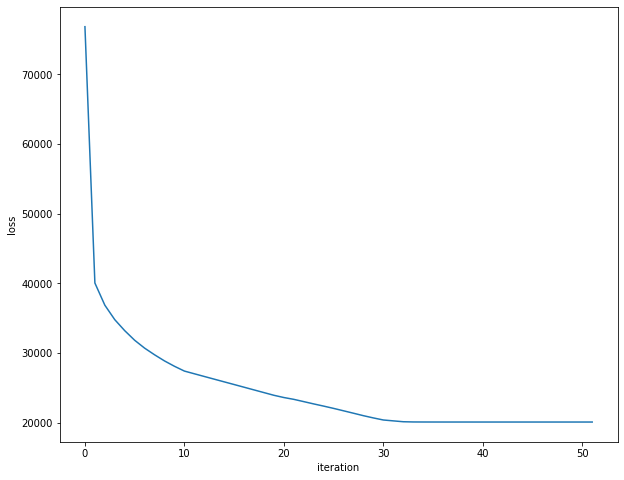

Lambda = 9.894563503412073 done......
43604.43156679149 0
39749.10738041383 1
37081.00589849168 2
35000.5212526173 3
33370.07094837896 4
32003.571551471618 5
30788.59932328215 6
29683.556015119713 7
29047.89910517627 8
28493.397385689423 9
27939.423646207662 10
27386.195225487427 11
26832.753260167985 12
26277.29735443961 13
25720.9526576779 14
25163.613126560616 15
24746.565310492406 16
24322.99655755121 17
23847.064109535568 18
23384.292449385088 19
22895.168239729748 20
22399.77936344644 21
21898.138332714887 22
21410.62761399513 23
20979.042767042047 24
20784.288115667357 25
20627.30231694579 26
20602.293602338472 27
20596.86145064357 28
20594.865673432152 29
20594.115598940974 30
20593.77766823961 31
20593.589752439064 32
20593.451724866503 33
20593.34461282332 34
20593.27225625349 35
20593.23117554661 36
20593.211160687442 37
20593.202514849974 38
20593.199028744573 39
20593.19762335654 40
20593.197011002434 41
20593.1966884866 42
20593.196460771385 43
20593.19626465612 44
20593.

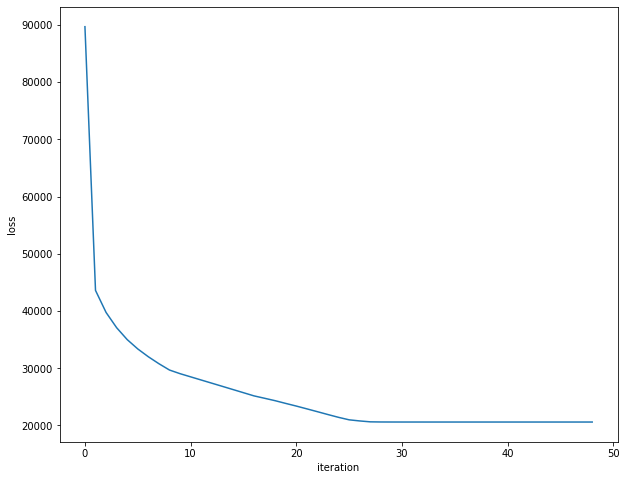

Lambda = 11.873476204094487 done......
46854.539311120374 0
42198.89445083416 1
38944.89132408252 2
36558.89792393621 3
34612.819528550164 4
32915.865365424776 5
31429.771503717442 6
30685.612916886203 7
29940.40300797557 8
29191.94056283657 9
28440.681747449602 10
27686.125821976137 11
26929.781499448538 12
26171.89981231511 13
25761.37927848613 14
25103.542692494855 15
24450.52333818844 16
23789.43699761472 17
23110.799081810677 18
22421.741645452134 19
21781.025339734748 20
21282.339532956586 21
21092.64281310551 22
21022.078355846843 23
21013.666803179807 24
21011.41591829972 25
21010.60038100335 26
21010.225619720048 27
21009.993550255957 28
21009.823600932395 29
21009.704947598308 30
21009.634800243875 31
21009.599765323455 32
21009.584611519866 33
21009.578738239397 34
21009.57660597139 35
21009.575820752172 36
21009.575469340758 37
21009.575239418144 38
21009.575047926577 39
21009.574889482847 40
21009.574772231394 41
21009.57469608343 42


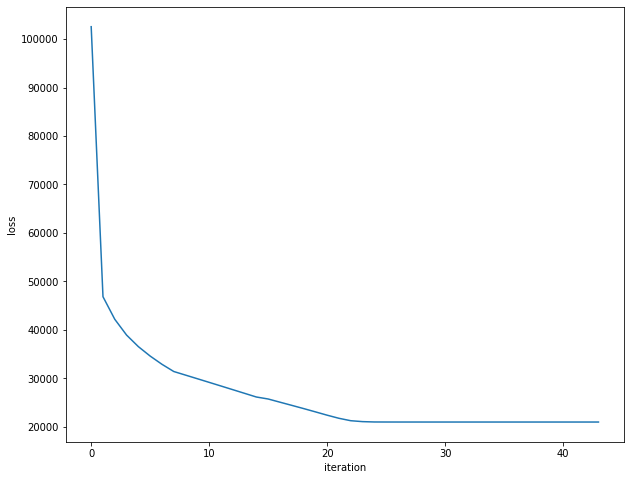

Lambda = 13.852388904776902 done......
49858.13416619519 0
44402.591445157814 1
40643.78201763236 2
37805.73622966002 3
35445.44671346471 4
33488.818348715635 5
32405.928150943917 6
31432.233526170377 7
30457.428937791283 8
29475.887842041113 9
28490.520463043842 10
27503.02254985348 11
26748.921193373993 12
26010.671550762723 13
25152.016360155725 14
24276.362511527812 15
23388.168211828357 16
22504.568886012432 17
21747.88582273801 18
21469.723663968554 19
21354.35964591429 20
21345.252999003882 21
21343.45251708156 22
21342.837621847364 23
21342.566897878773 24
21342.39697500432 25
21342.277490791977 26
21342.203286961187 27
21342.163542656286 28
21342.144508889978 29
21342.136017946134 30
21342.132272976443 31
21342.13047898758 32
21342.12947276613 33
21342.128829431458 34
21342.12839938983 35
21342.12811806328 36
21342.127942532486 37
21342.127837964188 38
21342.127777752223 39


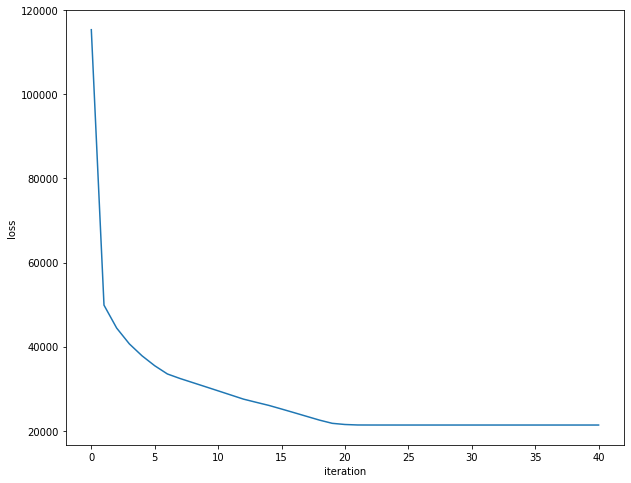

Lambda = 15.831301605459316 done......
52614.04998062263 0
46449.1955952406 1
42141.72688043982 2
38835.73440032515 3
36090.332518717696 4
34325.43634217511 5
33095.917845465505 6
31863.65558514634 7
30625.91532521437 8
29378.789548626788 9
28130.161290698125 10
27492.099313067873 11
26389.018299601856 12
25276.48454597682 13
24141.628970638514 14
23008.182493832024 15
22043.895808652807 16
21722.672883650273 17
21613.71928323803 18
21607.41723228681 19
21605.9511350741 20
21605.449695187548 21
21605.199391093138 22
21605.042233897966 23
21604.94737392773 24
21604.89545026385 25
21604.86903666114 26
21604.85599490321 27
21604.84940485669 28
21604.845848464996 29
21604.843786784066 30
21604.84253677626 31
21604.84176873113 32
21604.841299743475 33
21604.84101710927 34
21604.840848864103 35
21604.840749515384 36
21604.84069104376 37


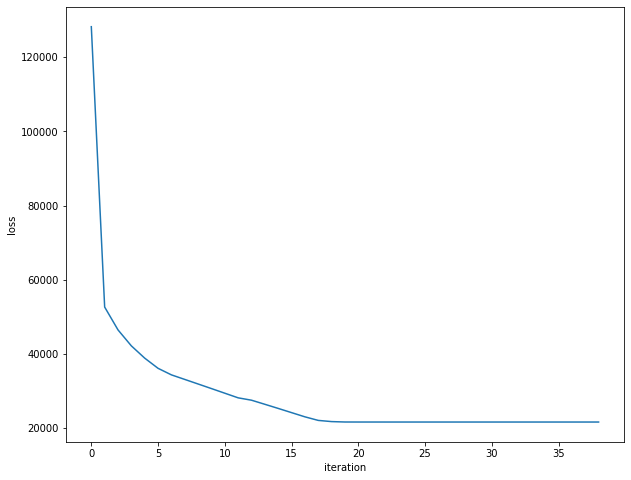

Lambda = 17.81021430614173 done......
55352.756127877394 0
48200.61769279049 1
43281.17741935721 2
39489.66279241357 3
36559.20125363786 4
35046.696238848985 5
33527.40489262012 6
32002.503275084142 7
30467.789756568993 8
28935.335090888584 9
28138.436198656782 10
26765.435592539063 11
25371.657279243598 12
23958.228149563212 13
22650.611097503926 14
22019.85372847432 15
21825.42263838143 16
21814.661083733918 17
21812.892460791074 18
21812.349234577538 19
21812.071361811977 20
21811.8988314472 21
21811.796278304057 22
21811.739633618472 23
21811.709863632615 24
21811.694401107667 25
21811.686158884753 26
21811.681557829685 27
21811.678878707633 28
21811.677279752166 29
21811.67631799563 30
21811.675740776394 31
21811.675396347506 32
21811.675191961167 33
21811.675071122954 34
21811.6749997995 35


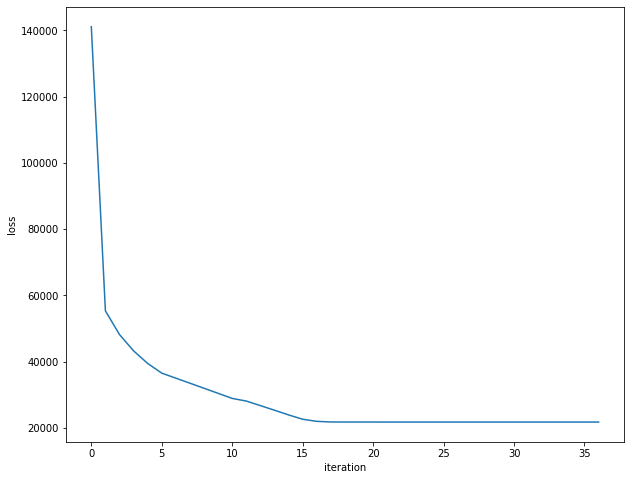

Lambda = 19.789127006824145 done......
57911.89978864943 0
49677.1039711069 1
44212.02262545223 2
40013.561766684754 3
37369.40598158575 4
35535.6165944635 5
33695.03722843022 6
31846.80238225043 7
29989.94395478001 8
29036.150940878244 9
27356.83923262933 10
25660.347505363734 11
23949.66161935521 12
22475.543591267713 13
22063.90324724482 14
21977.396613669156 15
21974.887649563654 16
21974.149014010836 17
21973.790099938782 18
21973.58278547321 19
21973.465492780637 20
21973.401166432563 21
21973.366556548717 22
21973.347840160735 23
21973.33744649506 24
21973.331483512062 25
21973.327976738798 26
21973.32588805024 27
21973.324639648916 28
21973.323894438174 29
21973.32345080424 30
21973.32318733691 31
21973.323031102995 32
21973.322938518377 33


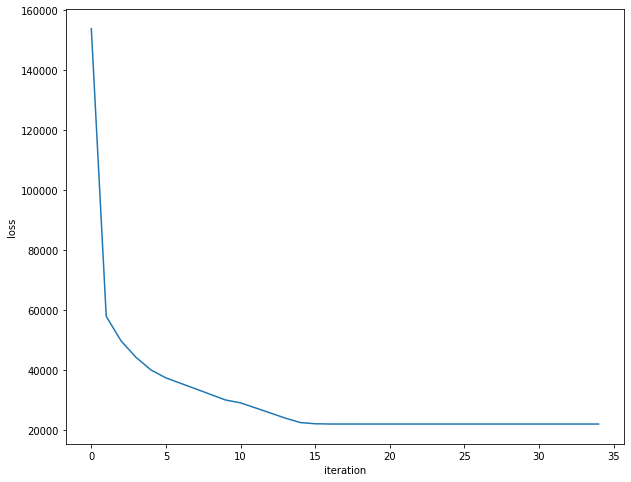

Lambda = 21.76803970750656 done......
60267.30399862975 0
51133.029622896924 1
44944.402258784656 2
40295.22366896916 3
37981.79485673636 4
35801.21872610854 5
33611.72743280037 6
31412.836289730716 7
29784.711707451606 8
28073.71867760686 9
26068.037843312835 10
24053.644095318283 11
22412.21189284521 12
22108.99037823083 13
22096.363244424247 14
22095.58361420243 15
22095.292837306974 16
22095.15296017241 17
22095.078945233134 18
22095.039040895786 19
22095.01761307616 20
22095.01084149439 21
22095.01043332849 22
22095.010333620492 23


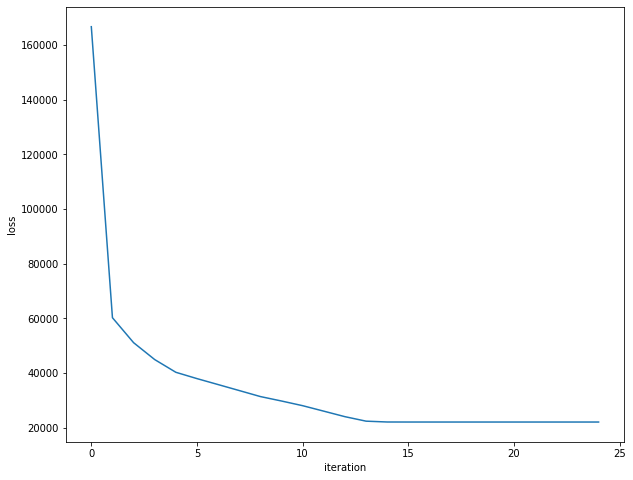

Lambda = 23.746952408188974 done......
62405.20008118157 0
52500.75777428913 1
45568.96275548741 2
40934.04686042672 3
38385.961374996725 4
35826.67456098994 5
33254.380326302635 6
30843.842829268753 7
29345.02855500691 8
26978.13637943191 9
24588.740476552797 10
22582.108594975965 11
22195.480690179513 12
22181.891428208633 13
22181.20712374333 14
22181.055076095487 15
22181.028464726864 16
22181.024963679127 17
22181.024439463272 18
22181.024305016414 19


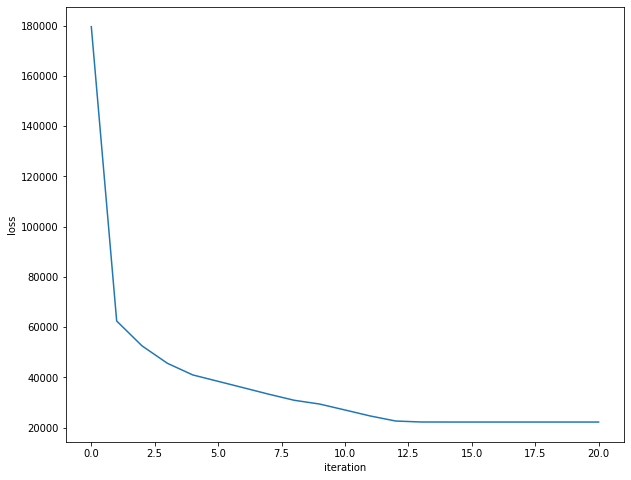

Lambda = 25.72586510887139 done......
64351.936109264934 0
53662.89441407747 1
46029.221287841974 2
41545.85680025321 3
38587.62635255126 4
35614.25244320294 5
32626.048078403997 6
30868.72042914031 7
28163.83523592696 8
25387.842979831355 9
22859.827261887393 10
22287.86844273793 11
22239.51575967537 12
22238.641626064906 13
22238.447009091433 14
22238.406023810323 15
22238.399779542517 16
22238.399073668566 17
22238.398976468037 18


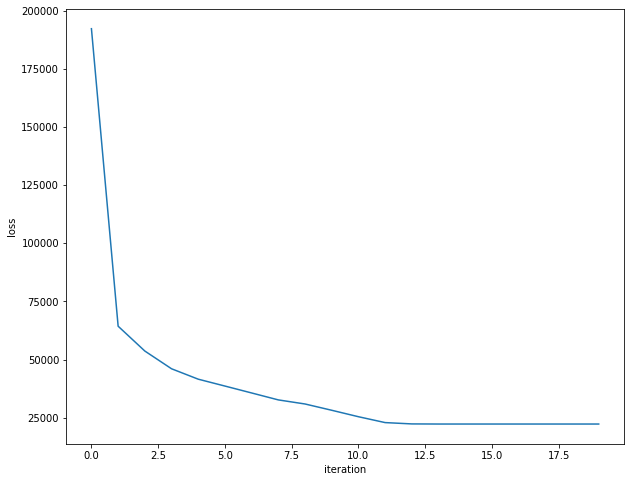

Lambda = 27.704777809553804 done......
66257.03081513516 0
54634.53349509326 1
46249.35016054151 2
42001.80217944803 3
38602.10952104101 4
35183.54340895669 5
32022.461995002577 6
29981.171744431682 7
26790.369814193386 8
23690.775525342917 9
22458.788843563852 10
22278.715920208604 11
22276.106587404047 12
22275.655973915607 13
22275.556816724406 14
22275.539453308746 15
22275.53721111463 16
22275.53698848225 17
22275.536964556555 18


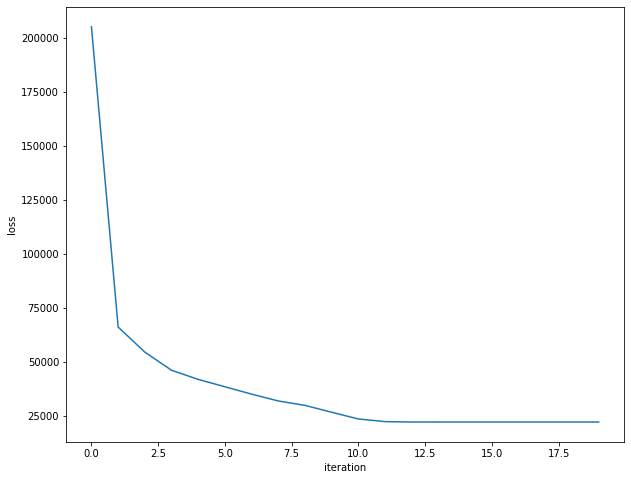

Lambda = 29.683690510236218 done......
68191.78679775463 0
55501.655380785436 1
46365.90606411261 2
42315.85645491151 3
38443.795084989964 4
34548.95174674062 5
31936.45350399999 6
28627.666432603153 7
25001.64059110278 8
22437.067210960406 9
22302.878793912965 10
22300.313445103315 11
22299.840880893247 12
22299.758734694846 13
22299.7486994619 14
22299.747815655515 15
22299.74776026499 16


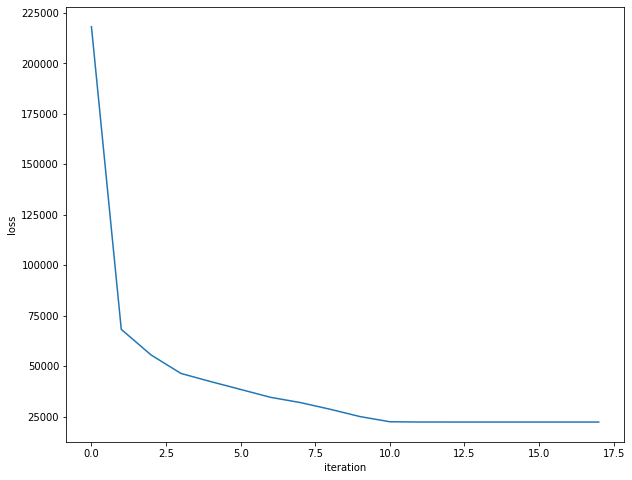

Lambda = 31.662603210918633 done......
70007.47856346569 0
56209.00056655502 1
46843.755090608414 2
42491.44414695306 3
38114.24730932551 4
33797.73793651324 5
31442.26073219265 6
27301.234128681743 7
23366.77909160254 8
22385.816864091754 9
22315.04039644481 10
22314.392262358924 11
22314.340412330577 12
22314.336264384183 13
22314.335932552945 14
22314.335906006803 15


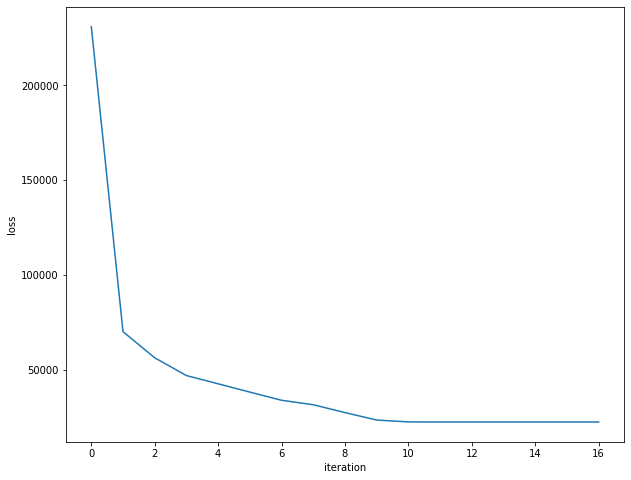

Lambda = 33.64151591160105 done......
71699.41093679862 0
56798.02464071649 1
47414.72150717979 2
42519.927518512515 3
37595.73552788089 4
33337.988869851884 5
30104.698714819555 6
25455.735090515325 7
22483.69188282301 8
22326.34204130913 9
22324.30341191031 10
22324.14032375552 11
22324.127276878902 12
22324.126233142833 13
22324.126149645075 14


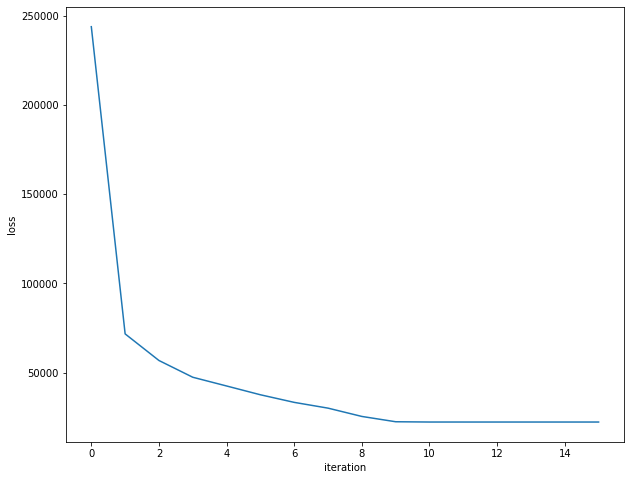

Lambda = 35.62042861228346 done......
73271.59564277099 0
57271.59218166524 1
47879.55629000519 2
42412.21747906774 3
36913.18029719283 4
33264.45453199966 5
28559.14331148443 6
23578.016900805083 7
22363.844581390076 8
22330.34139558095 9
22330.027574027285 10
22330.002468641214 11
22330.00046023738 12
22330.00029956724 13


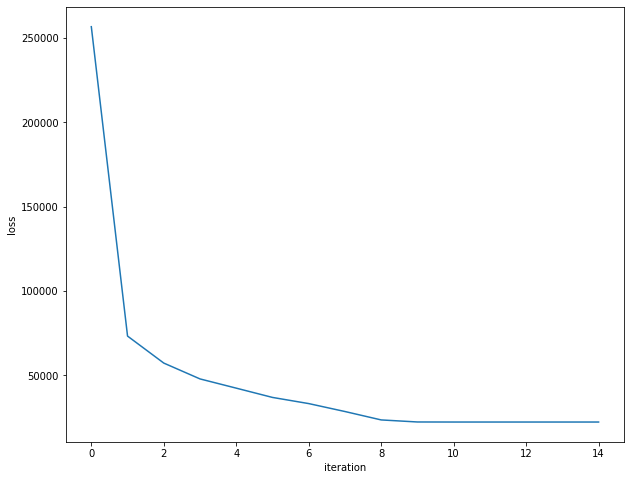

Lambda = 37.599341312965876 done......
74728.8607027367 0
57635.82720878054 1
48250.32557264099 2
42178.162982601476 3
36105.40420845627 4
32932.45648751576 5
27096.958930275112 6
22522.81192963561 7
22336.404444473254 8
22332.314017432764 9
22331.986787677954 10
22331.960609650236 11
22331.958515436232 12
22331.958347901367 13


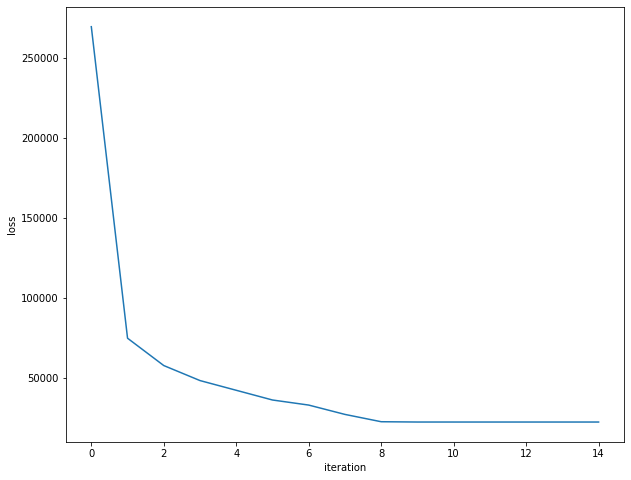

Lambda = 39.57825401364829 done......
Time taken =  4842.60991191864


In [29]:
# evaluation
start_time = time.time()
w_lasso, w0_lasso, lmda_best, W, W0, Lmda = Validation(X_train, y_train, X_valid, y_valid)
print ("Time taken = ", (time.time()-start_time))

In [210]:
print(Lmda)

[ 1.9789127   3.9578254   5.9367381   7.9156508   9.8945635  11.8734762
 13.8523889  15.83130161 17.81021431 19.78912701 21.76803971 23.74695241
 25.72586511 27.70477781 29.68369051 31.66260321 33.64151591 35.62042861
 37.59934131 39.57825401]


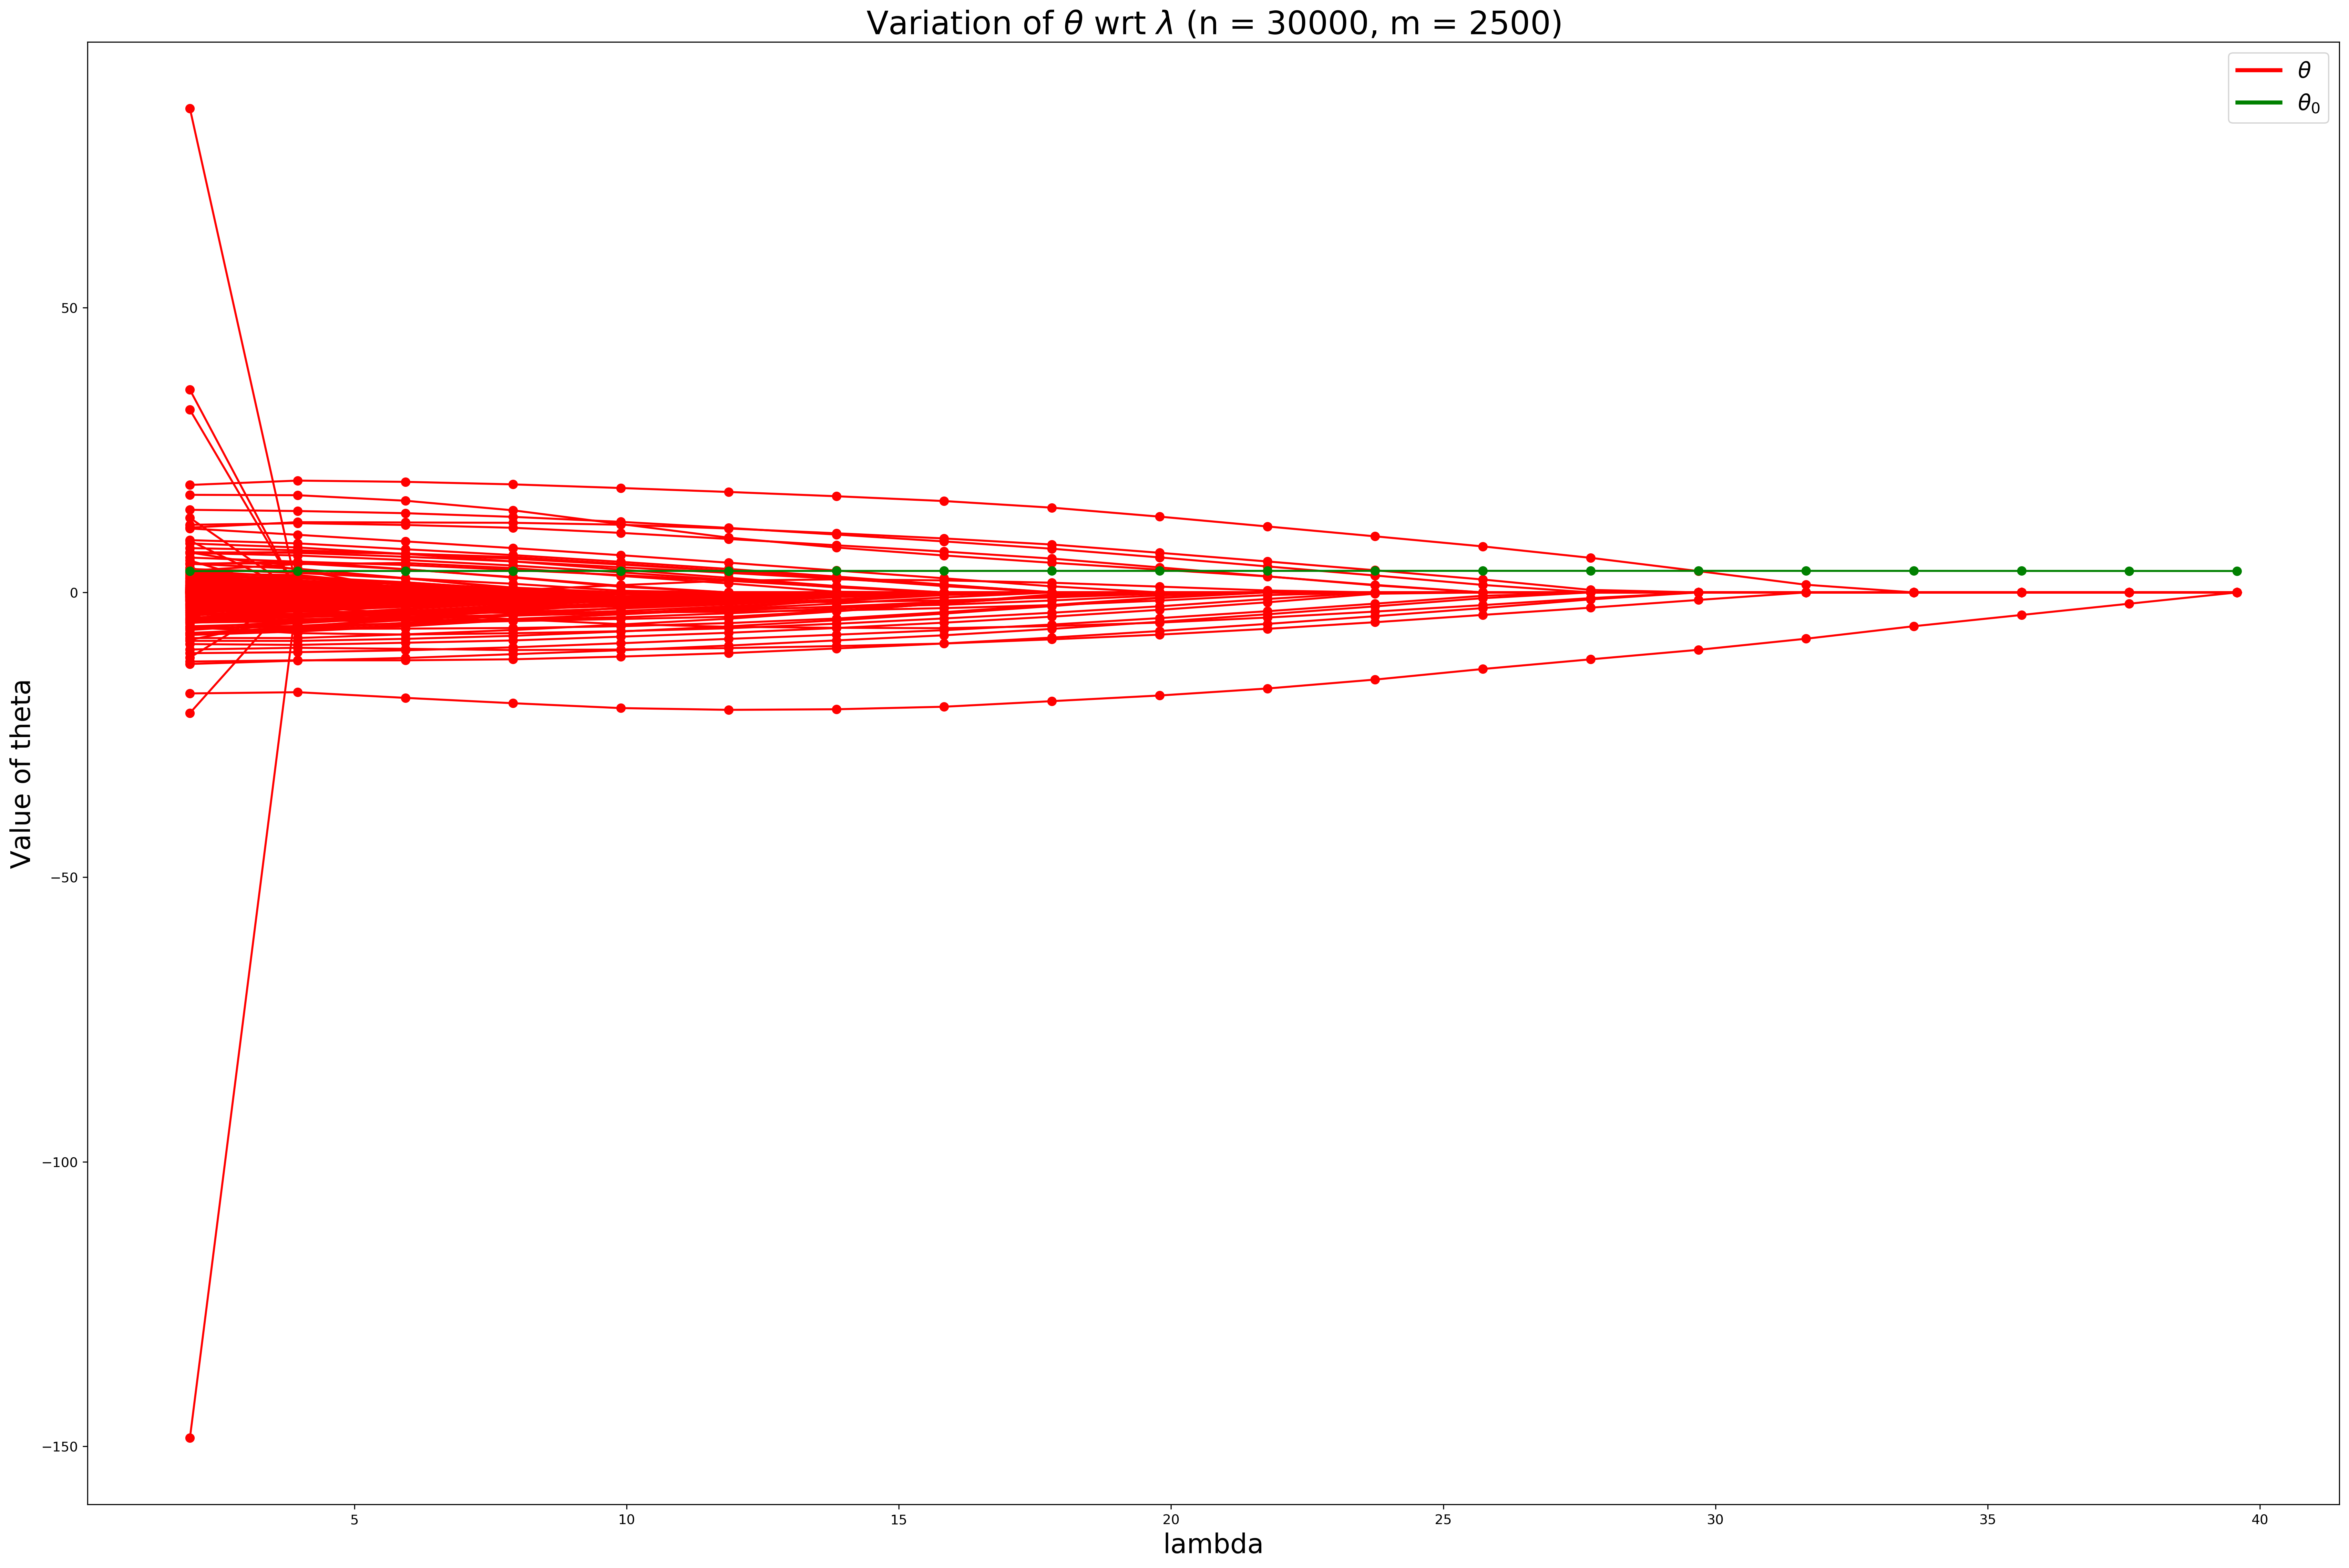

In [211]:
n,m = X_train.shape
fig, ax = plt.subplots(figsize=(30, 20), dpi=300)
for i in range(m):
    plt.plot(Lmda, W[:,i], c='red', label=str(i+1), marker='o')
plt.plot(Lmda, W0, c='green', label='0', marker='o')
colors = ['red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = [r'$\theta$', r'$\theta_{0}$']
plt.legend(lines, labels, fontsize=16)
plt.xlabel('lambda', fontsize=20)
plt.ylabel('Value of theta', fontsize=20)
plt.title(r'Variation of $\theta$ wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=24)
plt.show()


In [212]:
print ("Best lambda value for which validation RMSE is smallest = %.5f"%lmda_best)
print ("Train RMSE : %.5f"%evaluate_rmse(X_train, y_train, w_lasso, w0_lasso))
print ("Validation RMSE : %.5f"%evaluate_rmse(X_valid, y_valid, w_lasso, w0_lasso))
print ("Test RMSE : %.5f"%evaluate_rmse(X_test, y_test, w_lasso, w0_lasso))

Best lambda value for which validation RMSE is smallest = 1.97891
Train RMSE : 0.98014
Validation RMSE : 0.99225
Test RMSE : 1.05320


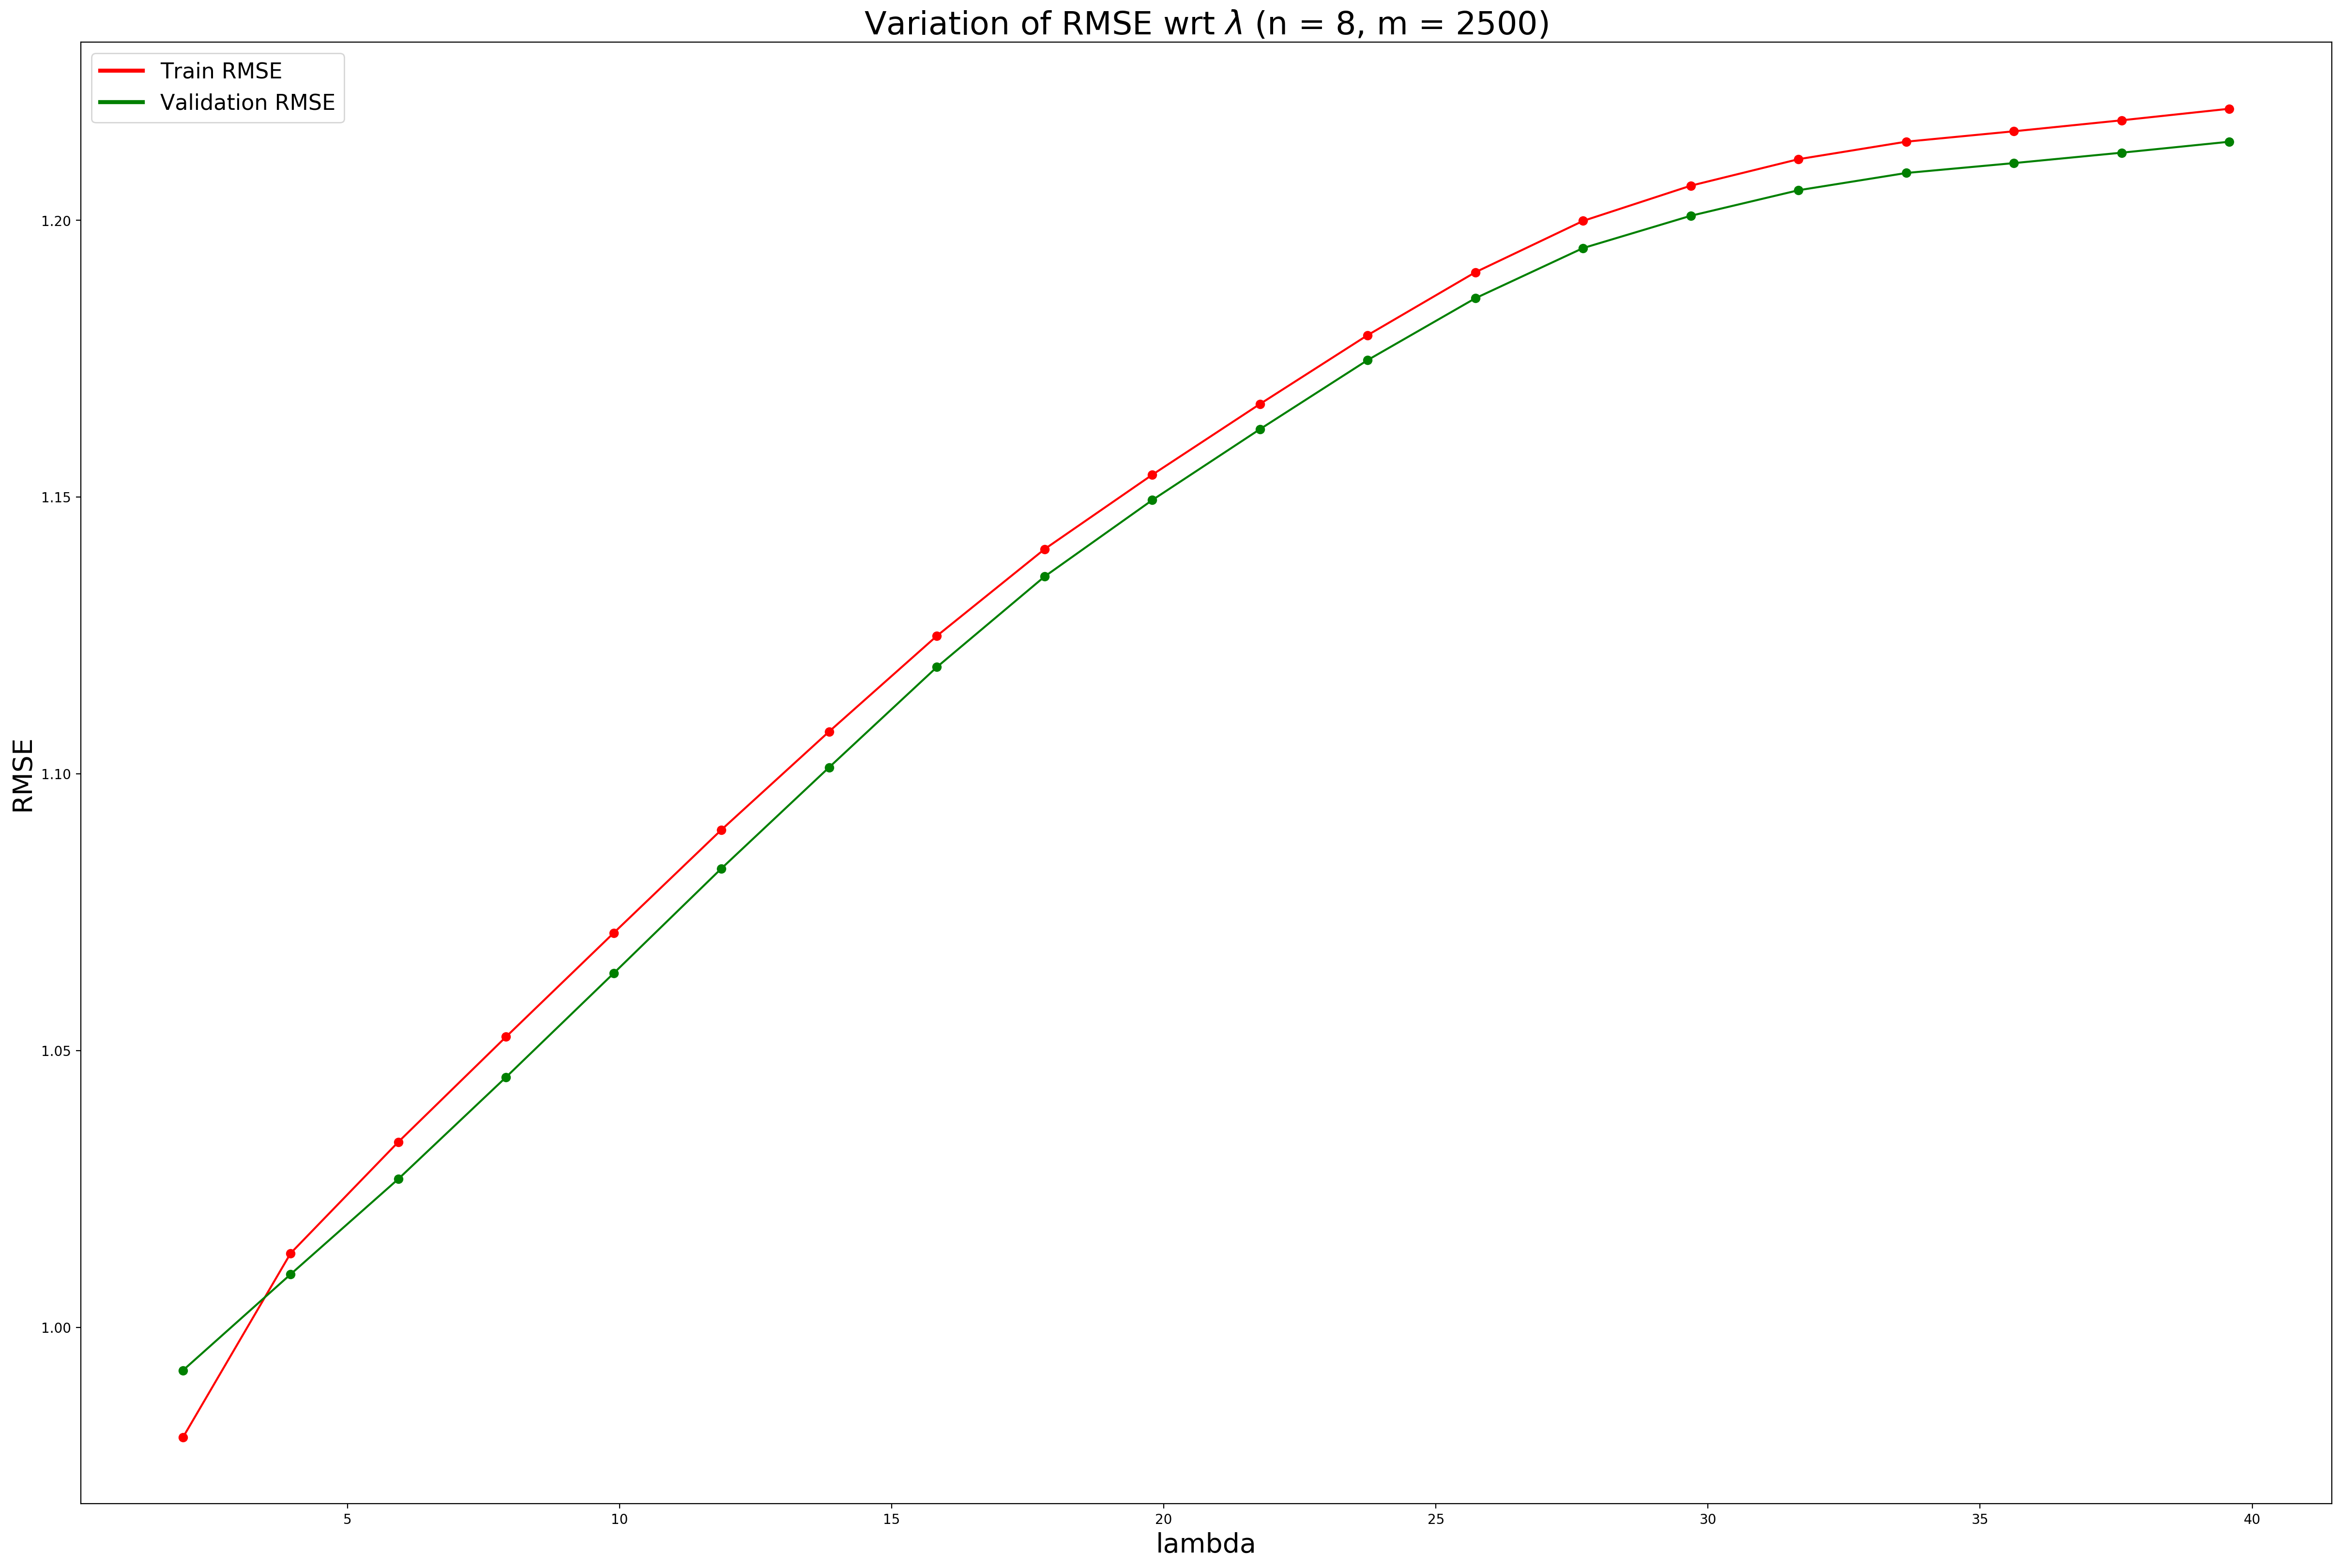

In [209]:
train_rmses = []
validation_rmses = []
for i,lmda in enumerate(Lmda):
    train_rmses.append(evaluate_rmse(X_train, y_train, W[i,:], W0[i]))
    validation_rmses.append(evaluate_rmse(X_valid, y_valid, W[i,:], W0[i]))
fig, ax = plt.subplots(figsize=(30, 20),dpi=200)    
plt.plot(Lmda, train_rmses, c='red', label='0', marker='o')
plt.plot(Lmda, validation_rmses, c='green', label='0', marker='o')

colors = ['red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = [r'Train RMSE', r'Validation RMSE']
plt.legend(lines, labels, fontsize=16)
plt.xlabel('lambda', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.title(r'Variation of RMSE wrt $\lambda$ (n = ' + str(n) + ', m = '+ str(m) + ')', fontsize=24)
plt.show()
    

In [185]:
# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:20]
print('Lasso select features:')
for i in range(20):
    print(fName[idx[i]],w_lasso[idx[i]])

Lasso select features:
were soaked in -148.51253057525201
it was set 84.99399738649312
god whoever 35.58982484980407
the ####s 32.07301265597152
were -21.18998791141796
great 18.879212423873266
not -17.739962792980567
best 17.141929501582517
amazing 14.50777490156735
and 13.093322834698245
rude -12.56667782225999
the worst -12.138448669876494
delicious 11.879204357014547
set -11.425024043489488
love 11.382233762054891
awesome 11.228086271576863
horrible -10.671572754012223
no -10.02410574577272
perfect 9.181172184547146
terrible -9.078681931782354


In [39]:
import pickle as pkl
with open('/Users/lkumari/Desktop/ece511/lasso.pkl', 'wb') as f:
    pkl.dump((w_lasso, w0_lasso, lmda_best, W, W0, Lmda), f)

In [206]:
with open('/Users/lkumari/Desktop/ece511/lasso.pkl', 'rb') as f:
    w_lasso, w0_lasso, lmda_best, W, W0, Lmda = pkl.load(f)